# Import libraries

In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict 
import multiprocessing
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy import sparse
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

# Functions

### Find the best K (number of clusters) in KMeans
Try different number of clusters and metrics in order to find the best K.

In [2]:
def find_k(X, k_min, k_max):
    
    K = range(k_min, k_max)
    
    # Inertia
    inertia = []

    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
    print("Elbow visualization: Inertia")
    plt.figure(figsize=(16,8))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.show()
    
    # Elbow Visualizer (Yellowbrick)
    model = KMeans(max_iter=100, random_state=42)
    visualizer = KElbowVisualizer(model, k=(k_min, k_max))

    visualizer.fit(X)    
    print("Elbow visualization: Distortion Score (KElbowVisualizer)")
    visualizer.poof() 
    
    # Silhouette score
    silhouette = []

    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
        kmeans.fit(X)
        silhouette.append(silhouette_score(X, kmeans.predict(X)))

    print("Silhouette score")
    plt.figure(figsize=(16,8))
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.show()

### Metrics to compare between models
- **Silhoutte score**: measures the quality of clustering by considering both the compactness of clusters and the separation between clusters. It ranges from -1 to 1, with higher values indicating better clustering.

In [3]:
def clustering_metrics(X, clusters):

    metrics = {}
    
    # Silhouette score
    metrics['Silhouette'] = silhouette_score(X, clusters)

    return metrics

### Visualize the clusters
In order to plot the results we need to perform feature transformation and reduce the dimensionality to 2 features. For that purpose we will apply TruncatedSVD, since it can handle sparse input such as the TF-IDF matrix (PCA does not handle sparse input).

In [4]:
def plot_clusters_kmeans(X, k):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_2D)
    clusters = kmeans.predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

In [5]:
def plot_clusters_dbscan(X, eps):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # DBSCAN
    dbscan = DBSCAN(eps=eps)
    clusters = dbscan.fit_predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

In [6]:
def plot_clusters_gaussian(X, n_components):
    
    # Reduce dimensionality with TruncatedSVD (can handle sparse input)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2D = svd.fit_transform(X)

    # Gaussian Mixtures
    model = GaussianMixture(n_components, random_state=42)
    clusters = model.fit_predict(X_2D)

    # Plot the results
    labels = np.unique(clusters)

    for i in labels:
        plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
    plt.legend()
    plt.show()

# Load the data

In [7]:
vinissimus = pd.read_csv("C:/Users/mboll/OneDrive/Documentos/DATA/Ironhack/Final_project/02-cleaning/vinissimus_short_cleaned.csv")
vinissimus.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

   price  bottle  type_wine type_wine_details type_agriculture  \
0   16.2    0.75        Red               Red     Conventional   
1    7.8    0.75  Sparkling   Frizzante white     Conventional   
2    9.4    0.75      White             White     Conventional   
3   16.2    0.75      White             White     Conventional   
4   13.0    0.75        Red               Red     Conventional   

             region         region_gi  ... alcohol_content customer_reviews  \
0   Castilla y León            Bierzo  ...            13.5              4.2   
1  Wines without GI  Wines without GI  ...            11.5              4.4   
2          Cataluña         Catalunya  ...            11.5              4.8   
3   Castilla y León             Rueda  ...            13.0              4.4   
4          La Rioja             Rioja  ...            13.5              4.4   

  customer_reviews_number parker_score  parker_score_num  penin_score  \
0                   217.0          NaN               NaN          NaN   
1                    45.0          NaN               NaN          NaN   
2                    95.0          NaN               NaN          NaN   
3                   147.0          NaN               NaN          NaN   
4                    94.0          NaN               NaN          NaN   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                        bouquet_norm  \
0                                  raspberry violets   
1              aromatic fruit_aromas highly_aromatic   
2  highly_aromatic complex fruit_aromas floral_sc...   
3                 white_fruit apricot fennel aniseed   
4                     ripe_fruit spicy_notes complex   

                                          mouth_norm  
0         red_fruit mineral voluminous medium-bodied  
1                           light pleasant sparkling  
2  good_entry structured balanced good_acidity fl...  
3                  rich unctuous pleasant_bitterness  
4               fleshy powerful ripe_tannins velvety  

[5 rows x 24 columns]

# Feature selection
Here we will use the features for different ends:
- **Clustering**: tasting-related features (bouquet and mouth, as we have seen)
- **Features for filtering the results of the recommender**: price, region (geographical indication), type of wine, grapes, type of agriculture...
- **Additional info to be displayed by the recommender**: the picture of the wine, link to the wine...

In [8]:
wine_data = vinissimus[['wine', 'price', 'type_wine', 'type_wine_details',
                        'type_agriculture', 'region_gi', 'grapes', 'tasting_bouquet',
                        'tasting_mouth', 'image', 'url']]

wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1          Aromatic / Fruit aromas / Highly aromatic   
2  Highly aromatic / Complex / Fruit aromas / Flo...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  
0  https://www.vinissimus.com/en/wine/ultreia-sai...  
1  https://www.vinissimus.com/en/wine/blanc-pesca...  
2  https://www.vinissimus.com/en/wine/bach-extris...  
3  https://www.vinissimus.com/en/wine/jose-parien...  
4  https://www.vinissimus.com/en/wine/coto-de-ima...

In [9]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345 entries, 0 to 5344
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wine               5345 non-null   object 
 1   price              5345 non-null   float64
 2   type_wine          5345 non-null   object 
 3   type_wine_details  5345 non-null   object 
 4   type_agriculture   5345 non-null   object 
 5   region_gi          5345 non-null   object 
 6   grapes             5345 non-null   object 
 7   tasting_bouquet    3816 non-null   object 
 8   tasting_mouth      3816 non-null   object 
 9   image              5345 non-null   object 
 10  url                5345 non-null   object 
dtypes: float64(1), object(10)
memory usage: 459.5+ KB


# Data preprocessing
First we will concatenate the tasting note columns into a single text representation. <br>

In [10]:
tasting_cols = ['tasting_bouquet', 'tasting_mouth']

wine_data = wine_data.dropna(subset=tasting_cols, how='all')
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 0 to 5342
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wine               3816 non-null   object 
 1   price              3816 non-null   float64
 2   type_wine          3816 non-null   object 
 3   type_wine_details  3816 non-null   object 
 4   type_agriculture   3816 non-null   object 
 5   region_gi          3816 non-null   object 
 6   grapes             3816 non-null   object 
 7   tasting_bouquet    3816 non-null   object 
 8   tasting_mouth      3816 non-null   object 
 9   image              3816 non-null   object 
 10  url                3816 non-null   object 
dtypes: float64(1), object(10)
memory usage: 357.8+ KB


In [11]:
wine_data.duplicated().value_counts()

False    3816
dtype: int64

Reset the index to avoid errors.

In [12]:
wine_data = wine_data.reset_index(drop=True)

In [13]:
# Obtain only one column with the tasting notes
wine_data["tasting_notes"] = wine_data["tasting_mouth"] + " / " + wine_data["tasting_bouquet"]

wine_data["tasting_notes"][0]

'Red fruit / Mineral / Voluminous / Medium-bodied / Raspberry / Violets'

### One-hot encoding

In [14]:
# Obtain list with all the terms 

tasting_terms = [value for sublist in wine_data["tasting_notes"].str.split(" / ") if isinstance(sublist, list) for value in sublist]
tasting_terms = [value for value in tasting_terms if not pd.isna(value)]
# tasting_terms

In [15]:
len(tasting_terms)

45382

In [16]:
# Remove duplicates from the list

tasting_terms = list(dict.fromkeys(tasting_terms))
len(tasting_terms)

651

In [17]:
# Create new df with the tasting notes
tasting_encoded = wine_data[["tasting_notes"]]  

# Add a new column for each term and fill it with zeros
for term in tasting_terms:
    tasting_encoded[term] = 0 

tasting_encoded.head()

tasting_notes  Red fruit  Mineral  \
0  Red fruit / Mineral / Voluminous / Medium-bodi...          0        0   
1  Light / Pleasant / Sparkling / Aromatic / Frui...          0        0   
2  Good entry / Structured / Balanced / Good acid...          0        0   
3  Rich / Unctuous / Pleasant bitterness / White ...          0        0   
4  Fleshy / Powerful / Ripe tannins / Velvety / R...          0        0   

   Voluminous  Medium-bodied  Raspberry  Violets  Light  Pleasant  Sparkling  \
0           0              0          0        0      0         0          0   
1           0              0          0        0      0         0          0   
2           0              0          0        0      0         0          0   
3           0              0          0        0      0         0          0   
4           0              0          0        0      0         0          0   

   ...  Raisined fruits  Macchia mediterranea  Oxidative notes  \
0  ...                0                     0                0   
1  ...                0                     0                0   
2  ...                0                     0                0   
3  ...                0                     0                0   
4  ...                0                     0                0   

   Blackberry liqueur  Soft caramel  Heather  Tea box  Roast notes  Soot  \
0                   0             0        0        0            0     0   
1                   0             0        0        0            0     0   
2                   0             0        0        0            0     0   
3                   0             0        0        0            0     0   
4                   0             0        0        0            0     0   

   Peanuts  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 652 columns]

In [18]:
# Iterate over the rows to replace the 0 with 1 if the term is present
for index, row in tasting_encoded.iterrows():
    tasting_note = row["tasting_notes"]
    for term in tasting_note.split(" / "):
        tasting_encoded.loc[index, term] = 1

# Drop the tasting_notes column
tasting_encoded = tasting_encoded.drop("tasting_notes", axis=1)

tasting_encoded.head()

Red fruit  Mineral  Voluminous  Medium-bodied  Raspberry  Violets  Light  \
0          1        1           1              1          1        1      0   
1          0        0           0              0          0        0      1   
2          0        0           0              0          0        0      0   
3          0        0           0              0          0        0      0   
4          0        0           0              0          0        0      0   

   Pleasant  Sparkling  Aromatic  ...  Raisined fruits  Macchia mediterranea  \
0         0          0         0  ...                0                     0   
1         1          1         1  ...                0                     0   
2         0          0         0  ...                0                     0   
3         0          0         0  ...                0                     0   
4         0          0         0  ...                0                     0   

   Oxidative notes  Blackberry liqueur  Soft caramel  Heather  Tea box  \
0                0                   0             0        0        0   
1                0                   0             0        0        0   
2                0                   0             0        0        0   
3                0                   0             0        0        0   
4                0                   0             0        0        0   

   Roast notes  Soot  Peanuts  
0            0     0        0  
1            0     0        0  
2            0     0        0  
3            0     0        0  
4            0     0        0  

[5 rows x 651 columns]

## Vector representation with TF-IDF
TF-IDF (term frequency-inverse document frequency) is a statistical measure that represents how important a word (or groups of words) is to a document or a corpus of text. The TF-IDF value increases proportionally to the number of times the word appears in a document and is offset by the number of documents that contain that word (or groups of words). <br>
Sources:
- https://towardsdatascience.com/how-to-easily-cluster-textual-data-in-python-ab27040b07d8
- https://youtu.be/IKgBLTeQQL8 (Bag of words intuition)
- https://youtu.be/D2V1okCEsiE (TF-IDF Intuition)

In [19]:
# Preprocess the text
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("/ ", "")
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.lower()  # Convert to lowercase
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("[^\w\s]", "")  # Remove punctuation
wine_data["tasting_notes"] = wine_data["tasting_notes"].str.replace("  ", " ") # Remove double spaces

wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [33]:
# Convert the preprocessed text into numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
wine_features = tfidf.fit_transform(wine_data['tasting_notes'])

In [34]:
wine_features

<3816x494 sparse matrix of type '<class 'numpy.float64'>'
	with 58030 stored elements in Compressed Sparse Row format>

In [35]:
wine_features.shape[0]

3816

In [36]:
wine_data["tasting_vectors"] = list(wine_features.toarray())

In [24]:
wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1          Aromatic / Fruit aromas / Highly aromatic   
2  Highly aromatic / Complex / Fruit aromas / Flo...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  red fruit mineral voluminous mediumbodied rasp...   
1  light pleasant sparkling aromatic fruit aromas...   
2  good entry structured balanced good acidity fl...   
3  rich unctuous pleasant bitterness white fruit ...   
4  fleshy powerful ripe tannins velvety ripe frui...   

                                     tasting_vectors  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1514694614067394, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [25]:
wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [26]:
# wine_data["tasting_vectors"][0]

## Scaling
Normally before applying KMeans we would have to scale the data using for example MinMaxScaler, to ensure that all the features are in the same scale, but in this case we don't need to since the values are already in the same scale.

# Clustering with KMeans
Find the optimum k (number of clusters) by looking at different metrics (inertia, distortion score and silhouette score)

### With encoded data

In [ ]:
# pip install threadpoolctl==3.1.0

Elbow visualization: Inertia


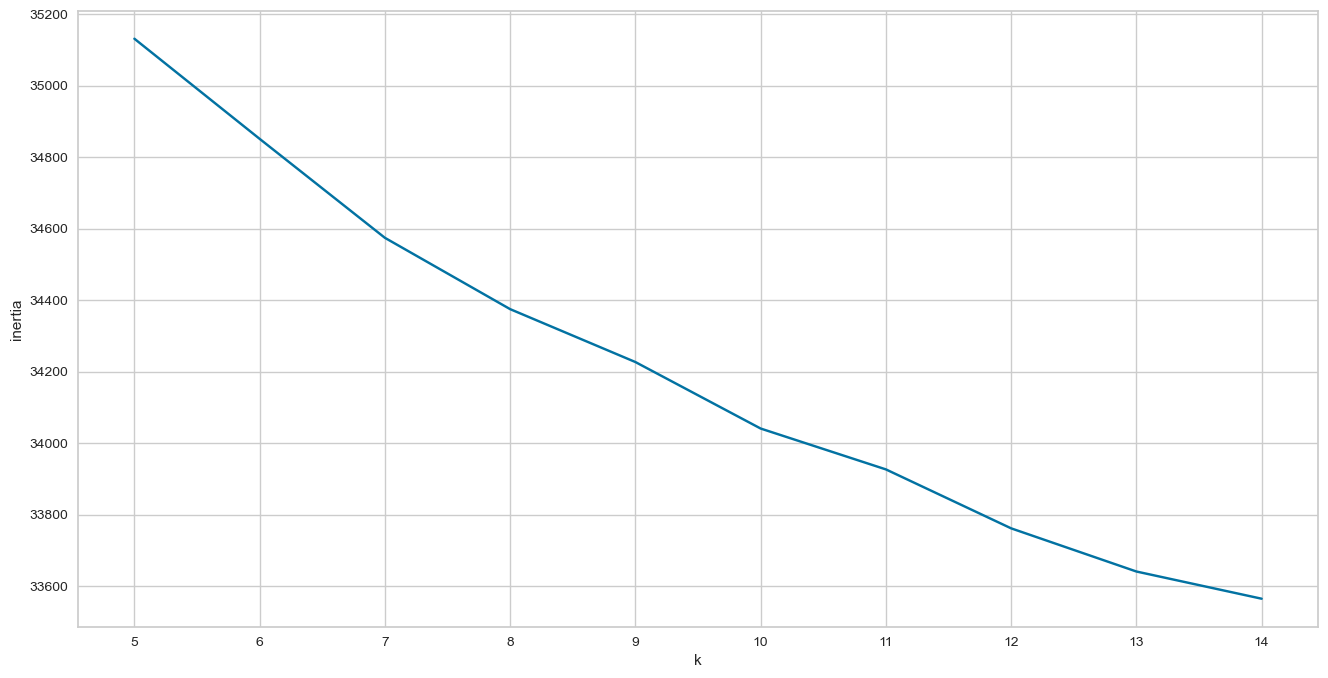

Elbow visualization: Distortion Score (KElbowVisualizer)


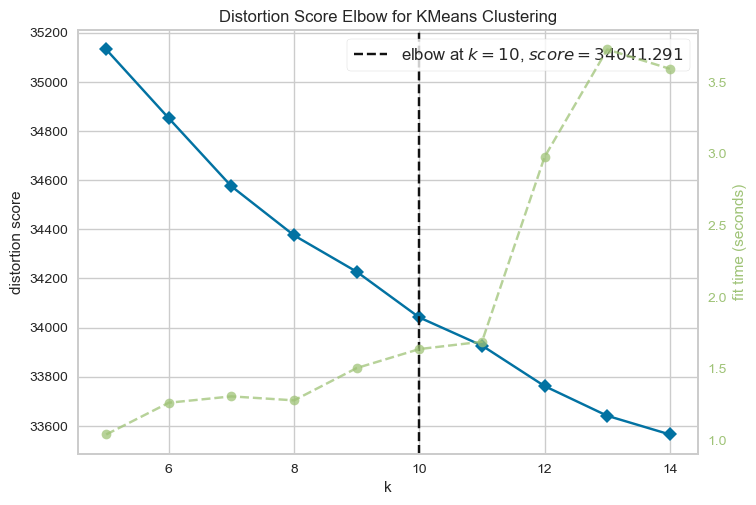

Silhouette score


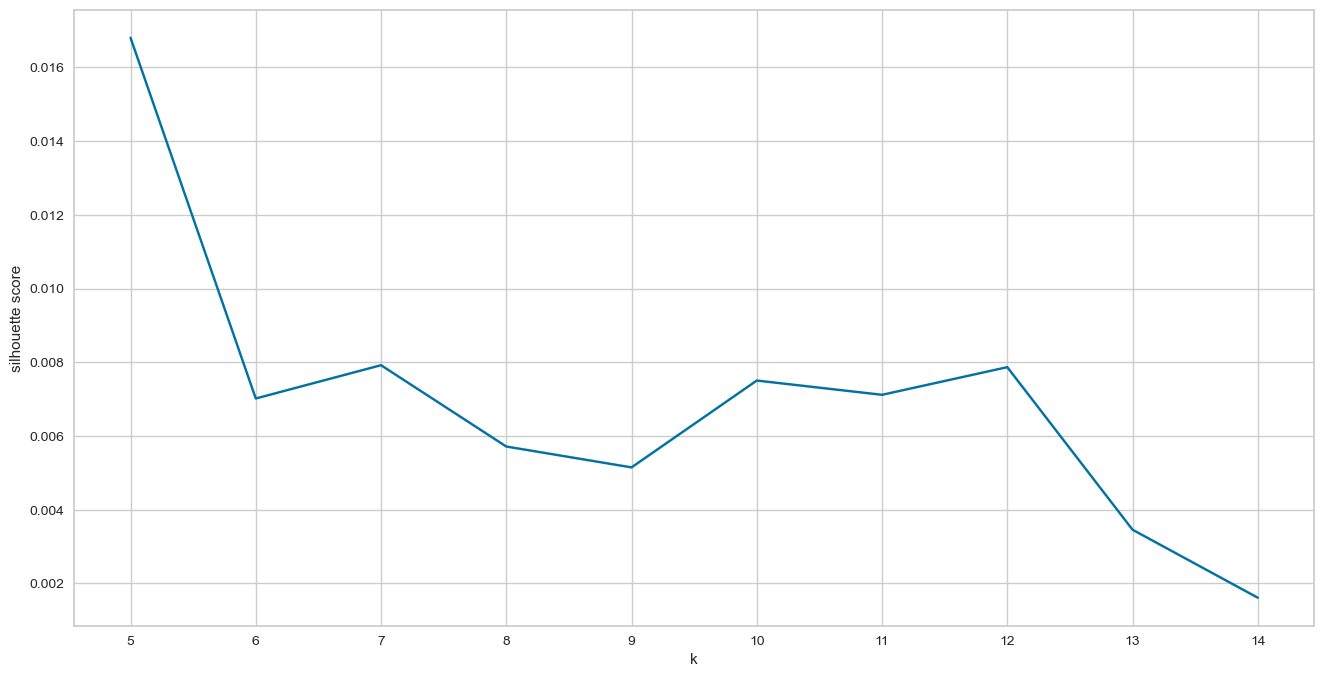

In [27]:
find_k(tasting_encoded, 5, 15)

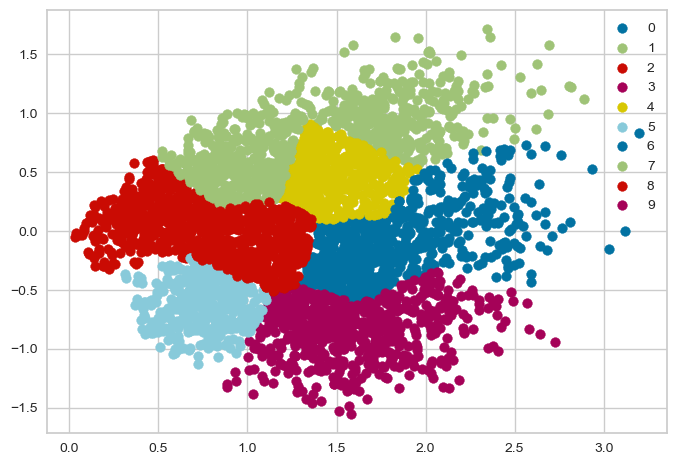

In [28]:
plot_clusters_kmeans(tasting_encoded, 10)

In [29]:
evaluation_results = {}

kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(tasting_encoded)
clusters = kmeans.predict(tasting_encoded)

tasting_encoded_metrics = clustering_metrics(tasting_encoded, clusters)
evaluation_results["Kmeans encoded"] = tasting_encoded_metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527}}

### With TF-IDF vectors

Elbow visualization: Inertia


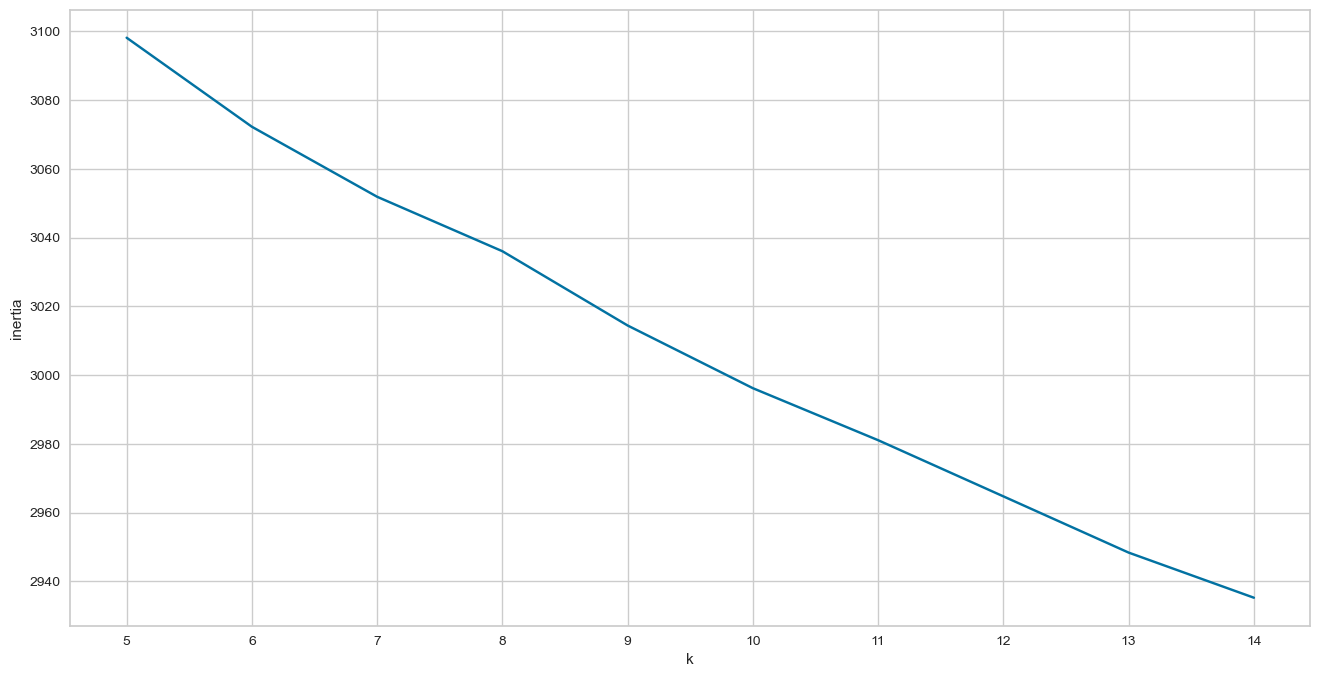

Elbow visualization: Distortion Score (KElbowVisualizer)


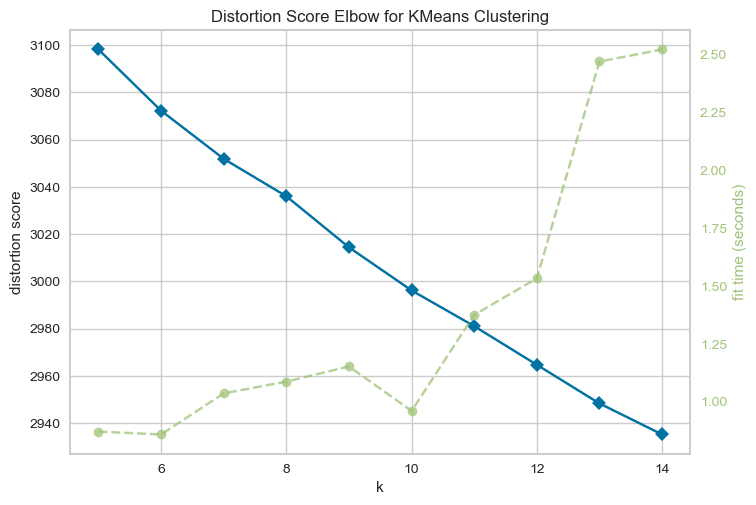

Silhouette score


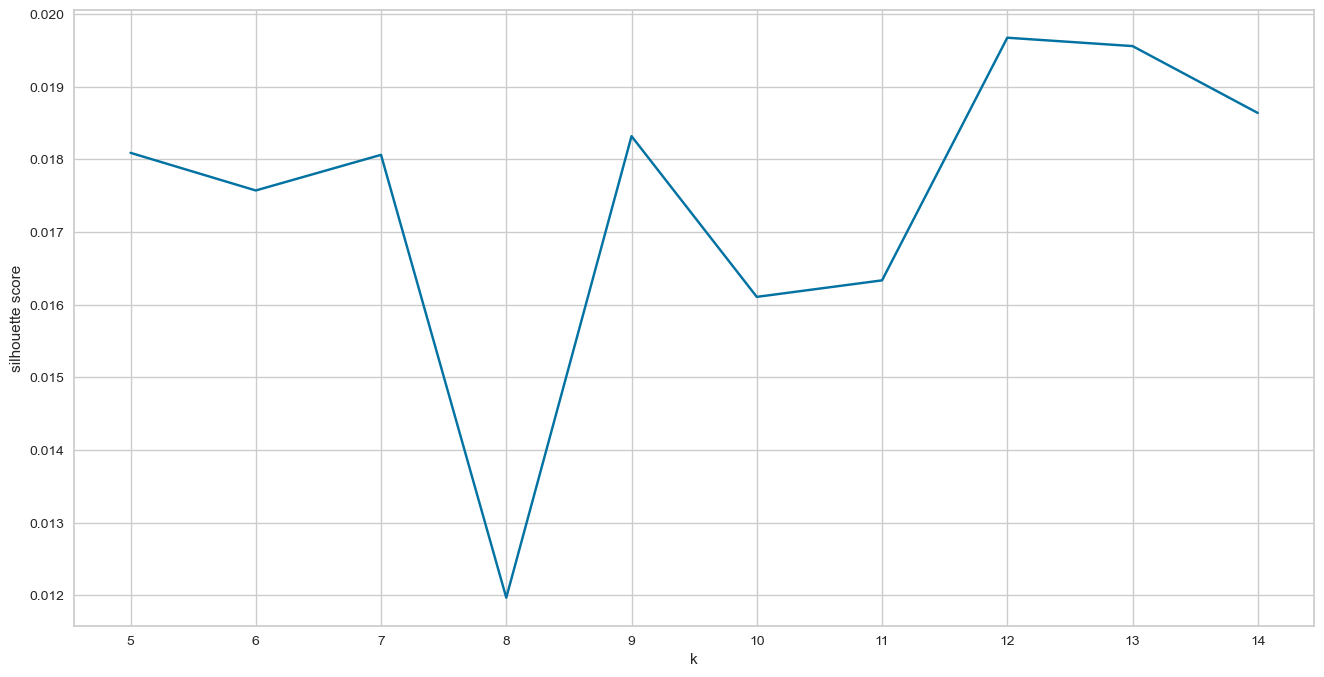

In [37]:
# Transform the matrix into a numpy array to be able to use KElbowVisualizer
wine_features = wine_features.toarray() 
find_k(wine_features, 5, 15)

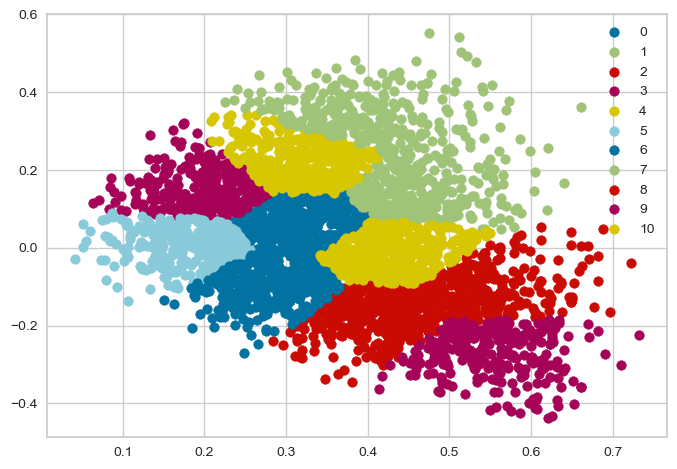

In [38]:
plot_clusters_kmeans(wine_features, 11)

In [39]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(wine_features)
clusters = kmeans.predict(wine_features)

wine_features_metrics = clustering_metrics(tasting_encoded, clusters)
evaluation_results["Kmeans TF-IDF"] = wine_features_metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905}}

# Clustering with DBSCAN

### Encoded data

In [40]:
eps = 0.5  # The maximum distance between two samples to be considered in the same neighborhood
min_samples = 5  # The minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(tasting_encoded)

In [41]:
# Clusters obtained
np.unique(clusters)

array([-1], dtype=int64)

We are only getting one cluster, labeled as -1. These are noise points (outliers): <br>
In DBSCAN, noise points are data points that do not belong to any cluster. They are often referred to as outliers or noise observations. In the DBSCAN algorithm, noise points are typically assigned a cluster label of -1. <br>
When you observe that all your data points are labeled as -1, it suggests that DBSCAN was unable to identify any dense regions or clusters in the data. This could be due to various factors such as a high eps value that makes the algorithm treat all points as noise, or the data itself may not exhibit clear clustering patterns.


In [42]:
eps = 0.3  
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(tasting_encoded)
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

In [43]:
metrics = clustering_metrics(tasting_encoded, cluster_labels)
evaluation_results["DBSCAN encoded"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404}}

### TF-IDF + Phrases

In [44]:
eps = 0.5
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(wine_features)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [45]:
metrics = clustering_metrics(wine_features, clusters)
evaluation_results["DBSCAN TF-IDF 0.5 eps 2 min samples"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548}}

In [46]:
eps = 0.3
min_samples = 2  
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(wine_features)
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19], dtype=int64)

In [47]:
metrics = clustering_metrics(wine_features, clusters)
evaluation_results["DBSCAN TF-IDF 0.3 eps 2 min samples"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797}}

Clearly the tasting notes need further transformations to be able to use them for clustering. 

## Word embeddings 
The main disadvantadge of TF-IDF is that it does not capture contextual semantics. To solve that, we will create word embeddings using Word2Vec. Word embeddings are vector representations that capture semantic and syntactic relationships between words based on their context. <br>
Resource:
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial <br>

The first step would be normalize the text (convert to lower case, remove punctuations...) but this has been done already. Normally the next step would be stemming or lemmatization (merge words that share the same root), preferably lemmatization since the resulting terms maintain a recognizable meaning. However, given the nature of our data where we have very simple words, we will try without lemmatization.

#### Use Phrases to capture terms that are more than one word
Some of the terms consist of more than one word (ie: "red fruit"). To avoid losing them, we will apply gensim's Phrases.

In [48]:
# Phrases takes a list of lists of words as an input
sent = [row.split() for row in wine_data["tasting_notes"]]

In [49]:
# Apply Phrases
phrases = Phrases(sent, min_count=1, threshold=1)
bigram = Phraser(phrases)
notes = bigram[sent] 

Check the most frequent words (sanity check)

In [50]:
word_freq = defaultdict(int)
for note in notes:
    for i in note:
        word_freq[i] += 1
len(word_freq)

1180

In [51]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['fruit_aromas',
 'fresh',
 'fruit',
 'balanced',
 'elegant',
 'spicy_notes',
 'notes',
 'complex',
 'highly_aromatic',
 'red_fruit']

#### Word2Vec implementation
- Parameters <br>
Here we played with the min_count (Ignores all words with total frequency lower than this) and the sample (The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5)).

In [52]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [53]:
w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

- Vocabulary table

In [54]:
w2v_model.build_vocab(notes, progress_per=10000)

- Train the model

In [55]:
w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(97851, 1412100)

#### Explore the model
Let's see how the model has capture the similarity between words.

In [56]:
w2v_model.wv.most_similar(positive=["red_fruit"])

[('smooth_tannins', 0.9996126294136047),
 ('black_fruit', 0.9996108412742615),
 ('violets', 0.9995871782302856),
 ('rounded', 0.9995852708816528),
 ('light', 0.9995839595794678),
 ('tobacco', 0.9995825290679932),
 ('vivacious', 0.9995816349983215),
 ('blackberries', 0.999580979347229),
 ('hardwoods', 0.9995777010917664),
 ('chocolate', 0.9995739459991455)]

In [57]:
w2v_model.wv.most_similar(positive=["white"])

[('fennel', 0.9996414184570312),
 ('white_flowers', 0.9996288418769836),
 ('green_apple', 0.9996170997619629),
 ('citrus_fruits', 0.9996015429496765),
 ('tropical_fruits', 0.9995919466018677),
 ('slightly_bitter', 0.9995875954627991),
 ('peach', 0.9995871186256409),
 ('stone_fruit', 0.9995840787887573),
 ('with_volume', 0.9995805621147156),
 ('crunchy', 0.999579131603241)]

In [58]:
w2v_model.wv.most_similar(positive=["vanilla"])

[('jam', 0.99964839220047),
 ('wellintegrated_wood', 0.9996293187141418),
 ('oak_wood', 0.9996277689933777),
 ('persistent', 0.9996178150177002),
 ('enveloping', 0.9996128082275391),
 ('cherries', 0.9996114373207092),
 ('liquorice', 0.9996009469032288),
 ('blackberries', 0.9995998740196228),
 ('roasted_notes', 0.9995997548103333),
 ('sweet_spices', 0.9995992183685303)]

All these terms look more or less related so it looks like the model it's not performing badly.

## Create vectors for each tasting note (using the word embeddings)

In [59]:
wine_data["tasting_notes"][0]

'red fruit mineral voluminous mediumbodied raspberry violets'

In [60]:
wine_data["tasting_notes"][91]

'powerful structured ripe tannins with volume balanced acidity pleasant finish tasty persistent varietal notes fruit aromas black fruit mediterranean herbs ageing notes'

In [61]:
# Define a custom tokenizer that preserves hyphenated words (to avoid errors with terms such as medium-bodied)
def custom_tokenizer(text):
    return text.split()

# Compute TF-IDF scores for each word in the tasting notes
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_data["tasting_notes"])

# Create TF-IDF weighted average vectors for each tasting note
tfidf_embeddings = []

for idx in range(len(wine_data)):
    tasting_note = wine_data["tasting_notes"][idx]
    words = tasting_note.split()
    word_vectors = []
    for word in words:
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
            word_vectors.append(word_vector * word_tfidf_score)
    if word_vectors:
        tfidf_avg_vector = np.mean(word_vectors, axis=0)
    else:
        tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
    tfidf_embeddings.append(tfidf_avg_vector)

In [62]:
wine_data["embeddings"] = tfidf_embeddings
wine_data.head()

wine  price  type_wine type_wine_details  \
0            Ultreia Saint Jacques 2021   16.2        Red               Red   
1                        Blanc Pescador    7.8  Sparkling   Frizzante white   
2  Bach Extrísimo Blanco Semidulce 2021    9.4      White             White   
3            José Pariente Verdejo 2022   16.2      White             White   
4             Coto de Imaz Reserva 2018   13.0        Red               Red   

  type_agriculture         region_gi                                grapes  \
0     Conventional            Bierzo                            ['Mencia']   
1     Conventional  Wines without GI  ['Macabeo', 'Parellada', 'Xarel·lo']   
2     Conventional         Catalunya               ['Xarel·lo', 'Macabeo']   
3     Conventional             Rueda                           ['Verdejo']   
4     Conventional             Rioja                       ['Tempranillo']   

                                     tasting_bouquet  \
0                                Raspberry / Violets   
1          Aromatic / Fruit aromas / Highly aromatic   
2  Highly aromatic / Complex / Fruit aromas / Flo...   
3           White fruit / Apricot / Fennel / Aniseed   
4                 Ripe fruit / Spicy notes / Complex   

                                       tasting_mouth  \
0   Red fruit / Mineral / Voluminous / Medium-bodied   
1                       Light / Pleasant / Sparkling   
2  Good entry / Structured / Balanced / Good acid...   
3              Rich / Unctuous / Pleasant bitterness   
4         Fleshy / Powerful / Ripe tannins / Velvety   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...   
1  https://www.vinissimus.com/en/wine/blanc-pesca...   
2  https://www.vinissimus.com/en/wine/bach-extris...   
3  https://www.vinissimus.com/en/wine/jose-parien...   
4  https://www.vinissimus.com/en/wine/coto-de-ima...   

                                       tasting_notes  \
0  red fruit mineral voluminous mediumbodied rasp...   
1  light pleasant sparkling aromatic fruit aromas...   
2  good entry structured balanced good acidity fl...   
3  rich unctuous pleasant bitterness white fruit ...   
4  fleshy powerful ripe tannins velvety ripe frui...   

                                     tasting_vectors  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1514694614067394, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          embeddings  
0  [-0.0060737776, 0.043948285, -0.019237146, 0.0...  
1  [-0.0061991643, 0.0424472, -0.01890534, 0.0117...  
2  [-0.0029396513, 0.022201415, -0.010121698, 0.0...  
3  [-0.0040080077, 0.031835973, -0.014615529, 0.0...  
4  [-0.0057605403, 0.045773916, -0.021381665, 0.0...

### With embeddings

In [63]:
# Transform the embeddings into a 2D NumPy array to be able to use KElbowVisualizer 
tfidf_embeddings = np.vstack(tfidf_embeddings)

Elbow visualization: Inertia


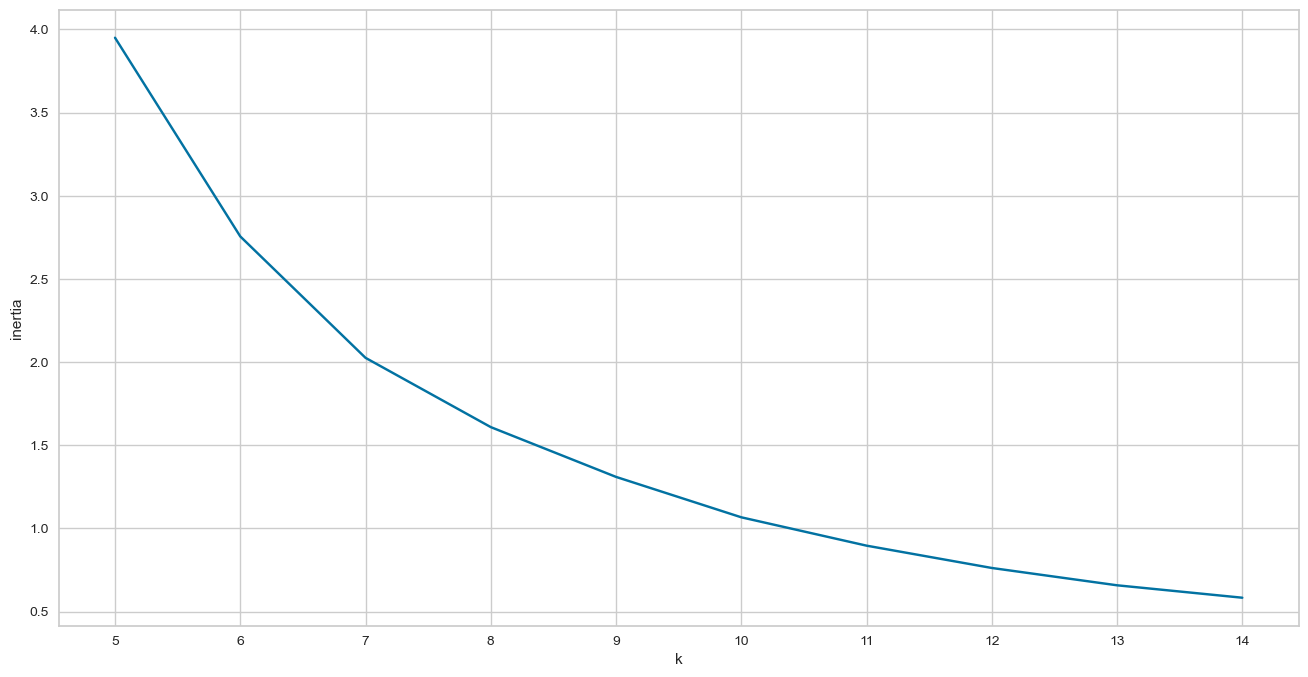

Elbow visualization: Distortion Score (KElbowVisualizer)


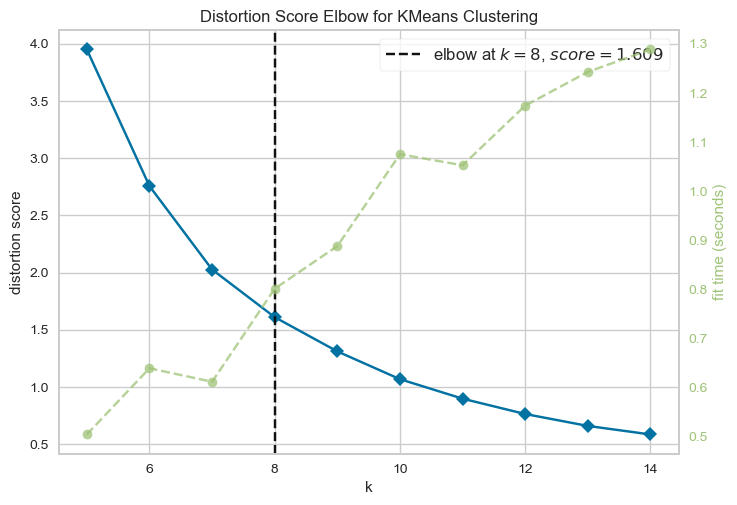

Silhouette score


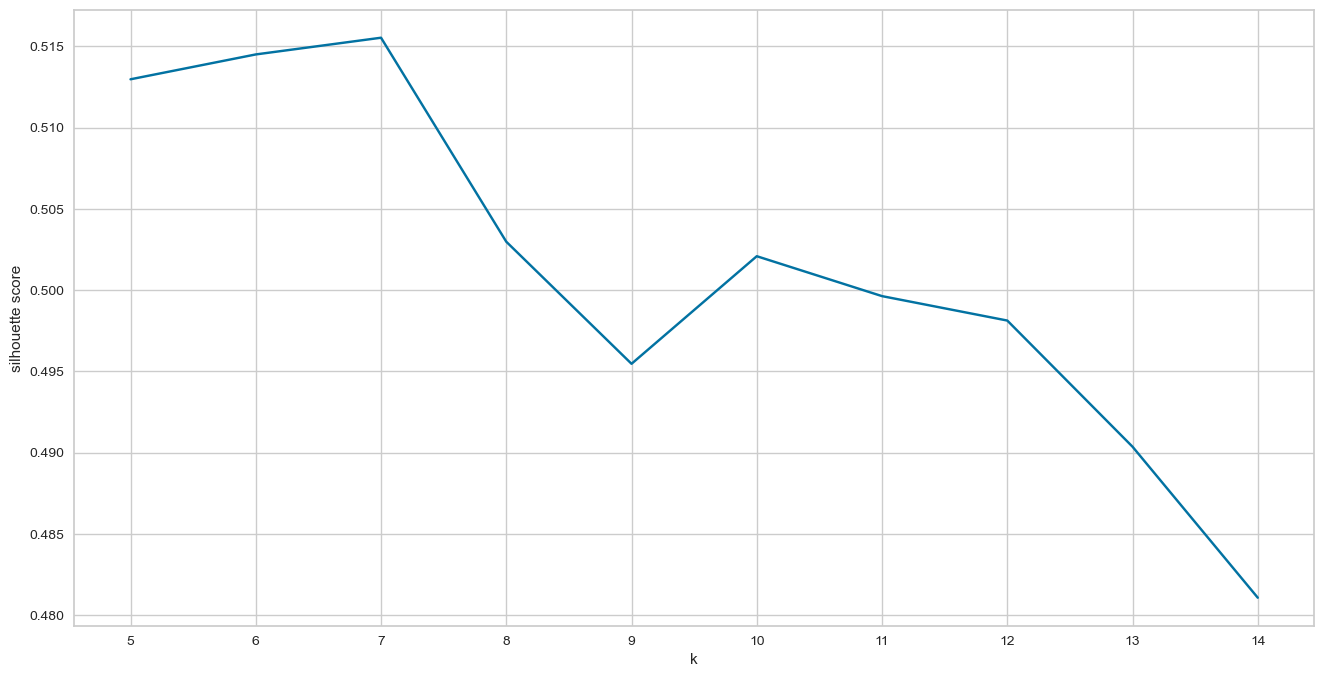

In [64]:
find_k(tfidf_embeddings, 5, 15)

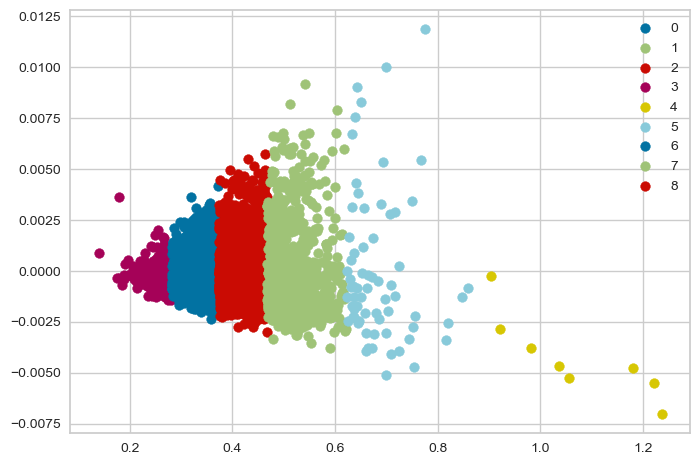

In [65]:
plot_clusters_kmeans(tfidf_embeddings, 9)

In [66]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(tfidf_embeddings)
clusters = kmeans.predict(tfidf_embeddings)

metrics = clustering_metrics(tfidf_embeddings, clusters)
evaluation_results["Kmeans Embeddings"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614}}

There is a significant improvement thanks to the use of word embeddings. Now we will try to see if we can improve our results by doing some feature engineering in the tasting notes.

# Reduced tasting notes
After doing some EDA, we have significantly reduced the terms in the tasting notes. We will now perform the same transformations (encoding, TF-IDF, Word2Vec) and run a quick KMeans to see how they perform.

In [67]:
text_data = pd.read_csv("C:/Users/mboll/OneDrive/Documentos/DATA/Ironhack/Final_project/03-eda/text_data_new_clean.csv")
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

   price  bottle  type_wine type_wine_details type_agriculture  \
0   16.2    0.75        Red               Red     Conventional   
1    7.8    0.75  Sparkling   Frizzante white     Conventional   
2    9.4    0.75      White             White     Conventional   
3   16.2    0.75      White             White     Conventional   
4   13.0    0.75        Red               Red     Conventional   

             region         region_gi  ...  \
0   Castilla y León            Bierzo  ...   
1  Wines without GI  Wines without GI  ...   
2          Cataluña         Catalunya  ...   
3   Castilla y León             Rueda  ...   
4          La Rioja             Rioja  ...   

                          notes_norm_removed_reduced  \
0  red_fruit mineral voluminous medium-bodied bla...   
1  light pleasant sparkling aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3  rich unctuous pleasant_bitterness white_fruit ...   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                                               lists  \
0  ['red_fruit', 'mineral', 'black_fruit', 'floral']   
1                           ['pleasant', 'aromatic']   
2  ['structured', 'balanced', 'good_acidity', 'pe...   
3  ['rich', 'unctuous', 'white_fruit', 'stone_fru...   
4  ['powerful', 'tannins', 'black_fruit', 'spices...   

                        notes_norm_removed_reduced50  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced100  \
0  red_fruit mineral voluminous black_fruit flora...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced150  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3              rich unctuous white_fruit other_herbs   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced200  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced250  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced300  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  structured balanced good_acidity persistent hi...   
3                          rich unctuous white_fruit   
4                 powerful ripe_fruit spices complex   

                    notes_norm_removed_new_reduction  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant sparkling aromatic fruit   
2  good_entry structured balanced good_acidity

In [68]:
text_data.isna().sum()

wine                                           0
year                                         378
winery                                         0
price                                          0
bottle                                       381
type_wine                                      0
type_wine_details                              0
type_agriculture                               0
region                                         0
region_gi                                      0
grapes                                         0
num_varieties                                  0
tasting_bouquet                                0
tasting_mouth                                  0
alcohol_content                               14
customer_reviews                               0
customer_reviews_number                        0
parker_score                                3557
parker_score_num                            3557
penin_score                                 3705
image               

#### One-hot encoding

In [69]:
# Obtain list with all the terms 

tasting_terms = [value for sublist in text_data["notes_norm_removed_reduced"].str.split(" ") if isinstance(sublist, list) for value in sublist]
tasting_terms = [value for value in tasting_terms if not pd.isna(value)]

In [70]:
len(tasting_terms)

39153

In [71]:
# Remove duplicates from the list

tasting_terms = list(dict.fromkeys(tasting_terms))
len(tasting_terms)

332

We have reduced the number of unique tasting terms from 651 to 332.

In [72]:
 # Create new df with the tasting notes
reduced_tasting_encoded = text_data[["notes_norm_removed_reduced"]] 

# Add a new column for each term and fill it with zeros
for term in tasting_terms:
    reduced_tasting_encoded[term] = 0 

# Iterate over the rows to replace the 0 with 1 if the term is present
for index, row in reduced_tasting_encoded.iterrows():
    tasting_note = row["notes_norm_removed_reduced"]
    for term in tasting_note.split(" "):
        reduced_tasting_encoded.loc[index, term] = 1

# Drop the tasting_notes column
reduced_tasting_encoded = reduced_tasting_encoded.drop("notes_norm_removed_reduced", axis=1)

reduced_tasting_encoded.head()    

red_fruit  mineral  voluminous  medium-bodied  black_fruit  floral_red  \
0          1        1           1              1            1           1   
1          0        0           0              0            0           0   
2          0        0           0              0            0           0   
3          0        0           0              0            0           0   
4          0        0           0              0            0           0   

   light  pleasant  sparkling  aromatic  ...  of_freshly_shaved_wood  \
0      0         0          0         0  ...                       0   
1      1         1          1         1  ...                       0   
2      0         0          0         0  ...                       0   
3      0         0          0         0  ...                       0   
4      0         0          0         0  ...                       0   

   wood_varnish  hot_spices  caramelised_apple  acid_fruit  iced_fruit  \
0             0           0                  0           0           0   
1             0           0                  0           0           0   
2             0           0                  0           0           0   
3             0           0                  0           0           0   
4             0           0                  0           0           0   

   gunpowder  straw  raisined_fruit  oxidative  
0          0      0               0          0  
1          0      0               0          0  
2          0      0               0          0  
3          0      0               0          0  
4          0      0               0          0  

[5 rows x 332 columns]

#### Vector representation with TF-IDF

In [73]:
# Convert the preprocessed text into numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
wine_features = tfidf.fit_transform(text_data['notes_norm_removed_reduced'])

In [74]:
wine_features

<3816x333 sparse matrix of type '<class 'numpy.float64'>'
	with 39381 stored elements in Compressed Sparse Row format>

In [75]:
wine_features.shape[0]

3816

In [76]:
text_data["tasting_vectors"] = list(wine_features.toarray())

#### Word embeddings with Word2Vec

In [77]:
text_data["lists_notes_norm_removed_reduced"] = text_data["notes_norm_removed_reduced"].str.split()
notes = text_data["lists_notes_norm_removed_reduced"]

In [78]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [79]:
w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [80]:
w2v_model.build_vocab(notes, progress_per=10000)

In [81]:
w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(85995, 1174590)

#### Explore the model
Let's see how the model has capture the similarity between words.

In [82]:
w2v_model.wv.most_similar(positive=["red_fruit"])

[('smooth_tannins', 0.999656081199646),
 ('cinnamon', 0.999653697013855),
 ('balsamic', 0.9996346235275269),
 ('easy_to_drink', 0.9996316432952881),
 ('sweet_tannins', 0.9996309280395508),
 ('clove', 0.9996286630630493),
 ('mineral', 0.9996272921562195),
 ('mint', 0.9996269941329956),
 ('ripe_red_fruit', 0.9996189475059509),
 ('characterful', 0.9996188282966614)]

In [83]:
w2v_model.wv.most_similar(positive=["white_fruit"])

[('stone_fruit', 0.9995399117469788),
 ('white_flowers', 0.9995186924934387),
 ('fresh', 0.9994909763336182),
 ('floral_white', 0.9994836449623108),
 ('tropical_fruit', 0.9994835257530212),
 ('bitter', 0.9994805455207825),
 ('aniseed', 0.9994766712188721),
 ('citrus_fruit', 0.9994745850563049),
 ('confectionery', 0.9994711875915527),
 ('other_herbs', 0.9994650483131409)]

In [84]:
w2v_model.wv.most_similar(positive=["vanilla"])

[('sweet_tannins', 0.9996395707130432),
 ('wood', 0.9996234774589539),
 ('powerful', 0.999616801738739),
 ('cinnamon', 0.9996157288551331),
 ('redcurrants', 0.999614953994751),
 ('sweet_spices', 0.9995942711830139),
 ('clove', 0.9995940923690796),
 ('ripe_tannins', 0.9995895624160767),
 ('ripe', 0.9995760917663574),
 ('ripe_red_fruit', 0.9995733499526978)]

#### Create vectors for each tasting note (using the word embeddings)

In [85]:
# Define a custom tokenizer that preserves hyphenated words (to avoid errors with terms such as medium-bodied)
def custom_tokenizer(text):
    return text.split()

# Compute TF-IDF scores for each word in the tasting notes using the custom tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data["notes_norm_removed_reduced"])

# Create TF-IDF weighted average vectors for each tasting note
tfidf_embeddings = []

for idx in range(len(text_data)):
    tasting_note = text_data["notes_norm_removed_reduced"][idx]
    words = tasting_note.split()
    word_vectors = []
    for word in words:
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
            word_vectors.append(word_vector * word_tfidf_score)
    if word_vectors:
        tfidf_avg_vector = np.mean(word_vectors, axis=0)
    else:
        tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
    tfidf_embeddings.append(tfidf_avg_vector)

In [86]:
text_data["embeddings"] = tfidf_embeddings
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

   price  bottle  type_wine type_wine_details type_agriculture  \
0   16.2    0.75        Red               Red     Conventional   
1    7.8    0.75  Sparkling   Frizzante white     Conventional   
2    9.4    0.75      White             White     Conventional   
3   16.2    0.75      White             White     Conventional   
4   13.0    0.75        Red               Red     Conventional   

             region         region_gi  ...  \
0   Castilla y León            Bierzo  ...   
1  Wines without GI  Wines without GI  ...   
2          Cataluña         Catalunya  ...   
3   Castilla y León             Rueda  ...   
4          La Rioja             Rioja  ...   

                       notes_norm_removed_reduced100  \
0  red_fruit mineral voluminous black_fruit flora...   
1            light pleasant aromatic highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3      rich unctuous white_fruit other_herbs aniseed   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced150  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3              rich unctuous white_fruit other_herbs   
4  fleshy powerful ripe_tannins velvety ripe_frui...   

                       notes_norm_removed_reduced200  \
0           red_fruit mineral black_fruit floral_red   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced250  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  good_entry structured balanced good_acidity fl...   
3                          rich unctuous white_fruit   
4          fleshy powerful ripe_fruit spices complex   

                       notes_norm_removed_reduced300  \
0                      red_fruit mineral black_fruit   
1                           pleasant highly_aromatic   
2  structured balanced good_acidity persistent hi...   
3                          rich unctuous white_fruit   
4                 powerful ripe_fruit spices complex   

                    notes_norm_removed_new_reduction  \
0  red_fruit mineral voluminous medium-bodied bla...   
1            light pleasant sparkling aromatic fruit   
2  good_entry structured balanced good_acidity fl...   
3  rich unctuous pleasant_bitterness white_fruit ...   
4  fleshy powerful tannins velvety black_fruit sp...   

            notes_norm_removed_new_reduction_dropped  \
0               red_fruit mineral black_fruit floral   
1                                  pleasant aromatic   
2  structured balanced good_acidity persistent ar...   
3        rich unctuous white_fruit stone_fruit herbs   
4        powerful tannins black_fruit spices complex   

                                     tasting_vectors  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.4724600440658182, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.3879363070698506, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                    lists_notes_norm_removed_reduced  \
0  [red_fruit, mineral, voluminous, medium-bodied...   
1  [light, pleasant, sparkling, aromatic, highly_...   
2  [good_entry, structured, balanced, good_aci

### Reduced tasting notes + encoding

Elbow visualization: Inertia


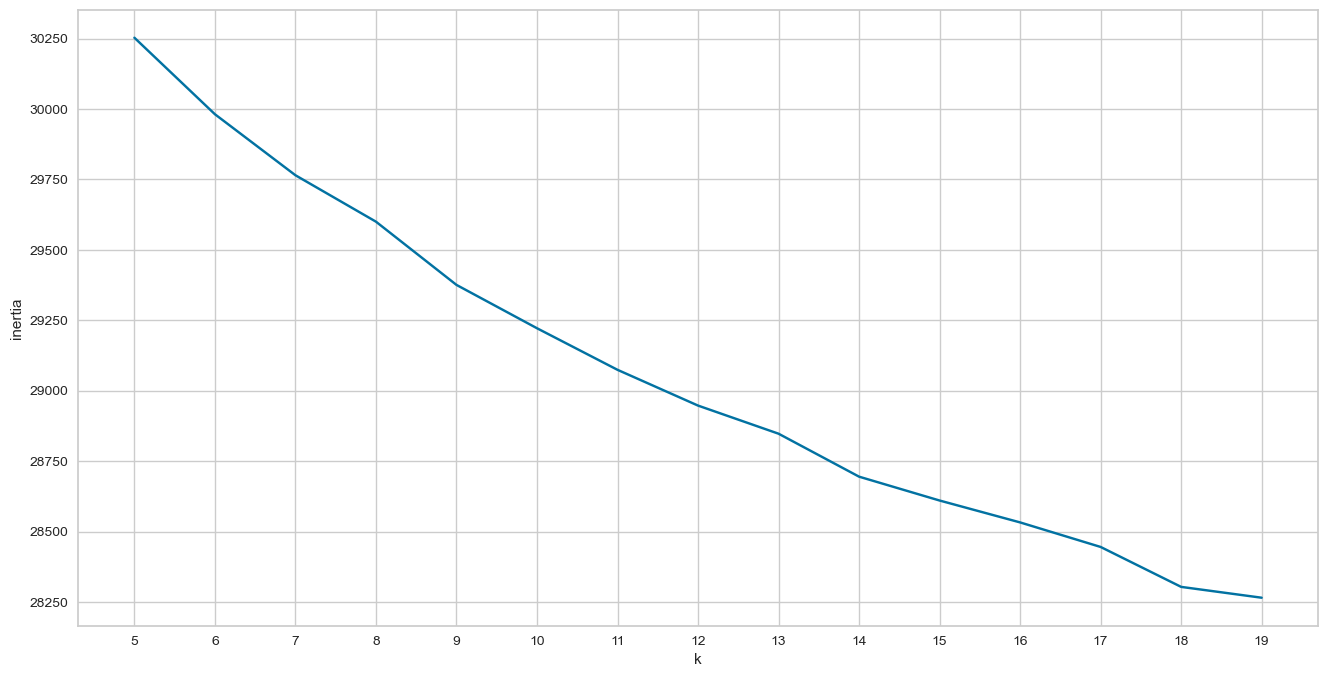

Elbow visualization: Distortion Score (KElbowVisualizer)


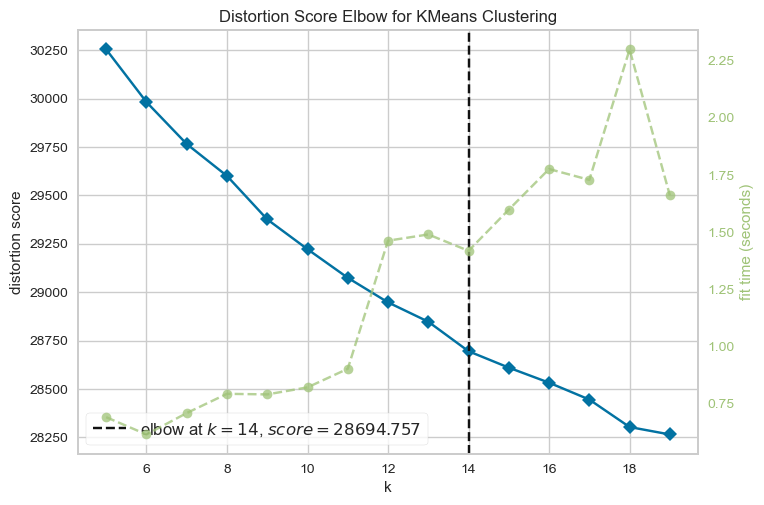

Silhouette score


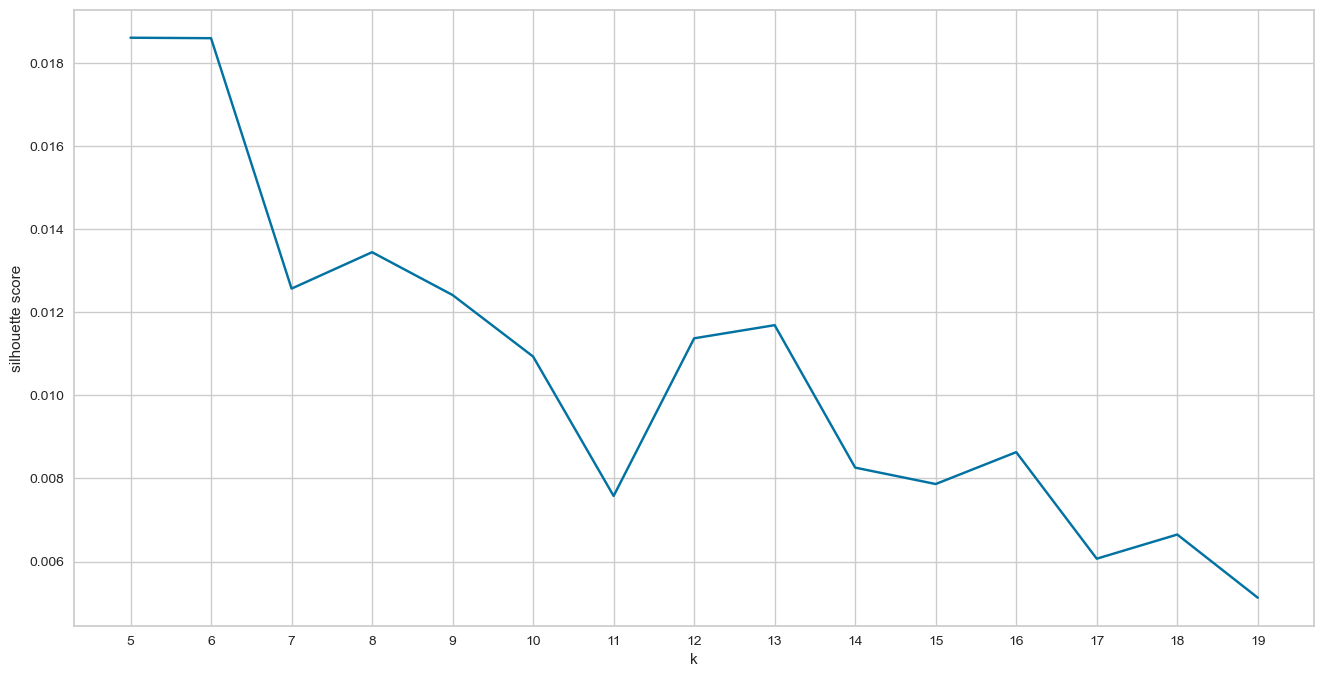

In [87]:
find_k(reduced_tasting_encoded, 5, 20)

In [88]:
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(reduced_tasting_encoded)
clusters = kmeans.predict(reduced_tasting_encoded)

metrics = clustering_metrics(reduced_tasting_encoded, clusters)
evaluation_results["Reduced tasting notes + encoding"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449}}

Elbow visualization: Inertia


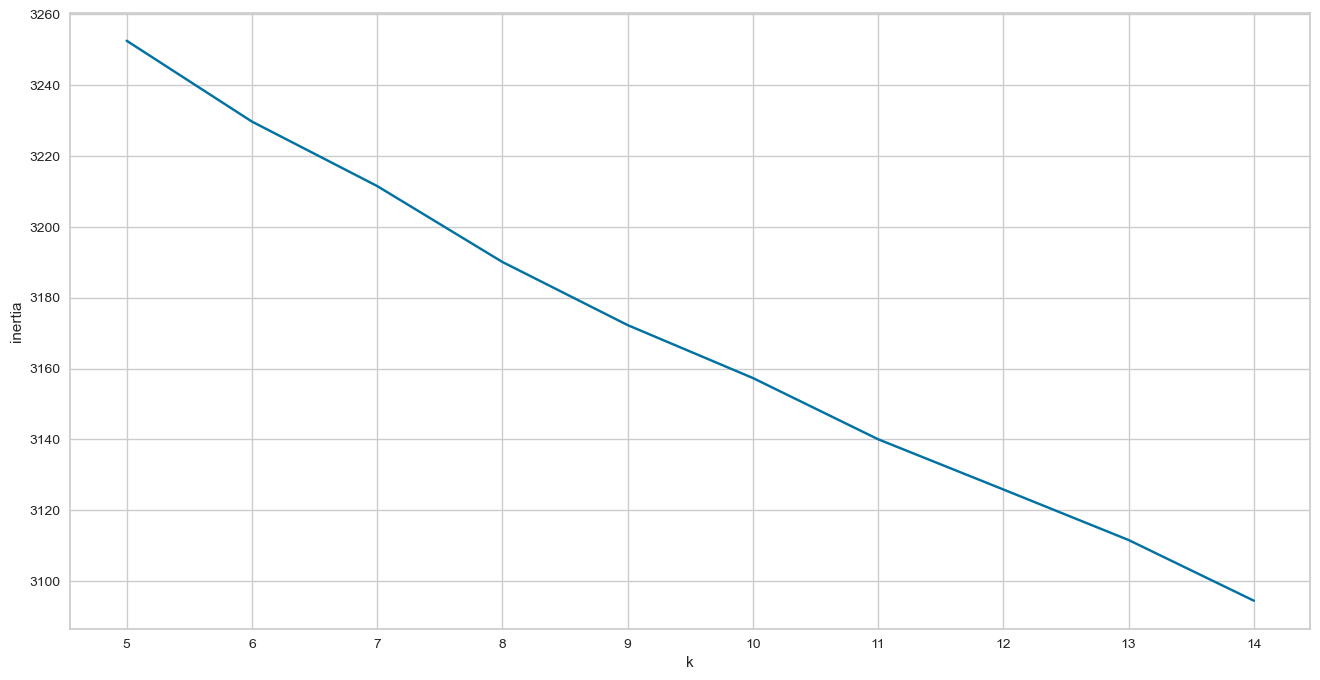

Elbow visualization: Distortion Score (KElbowVisualizer)


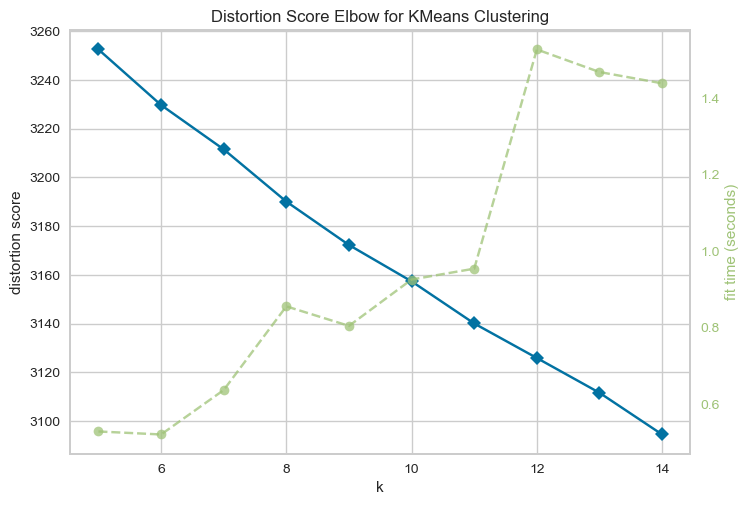

Silhouette score


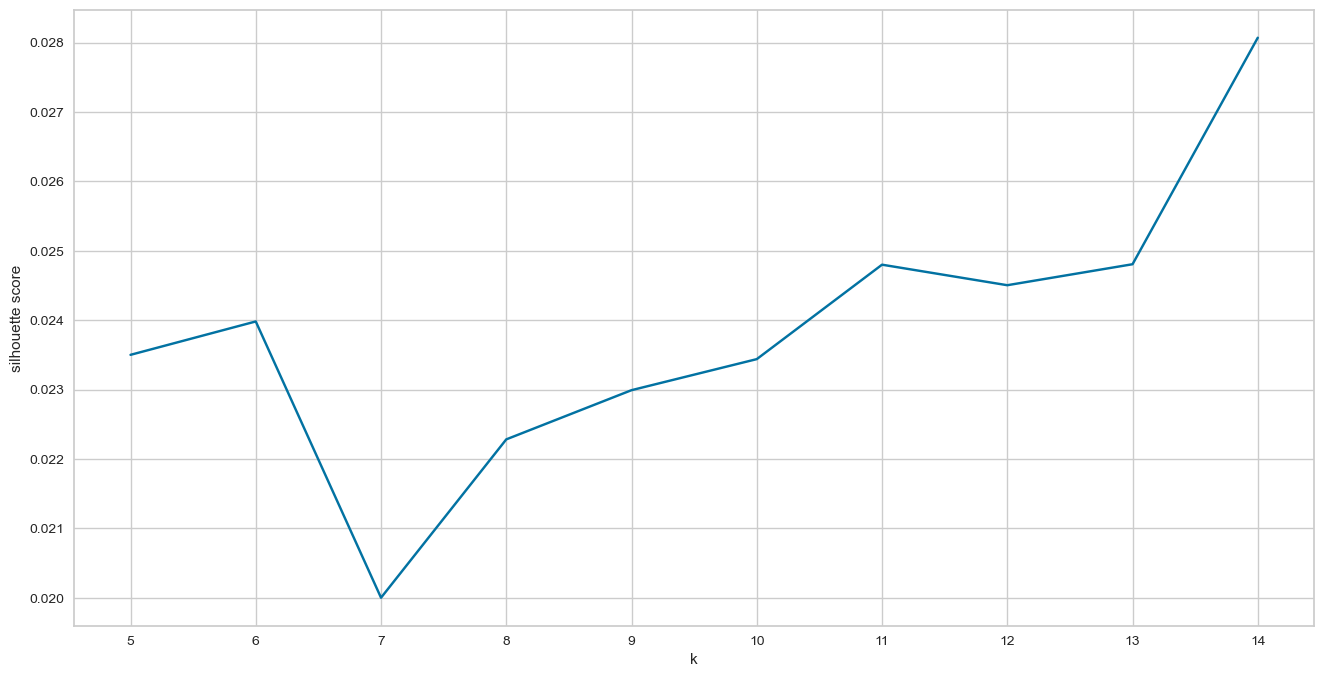

In [89]:
wine_features = wine_features.toarray() 

find_k(wine_features, 5, 15)

In [90]:
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit(wine_features)
clusters = kmeans.predict(wine_features)

metrics = clustering_metrics(wine_features, clusters)
evaluation_results["Reduced tasting notes + td idf"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116}}

Elbow visualization: Inertia


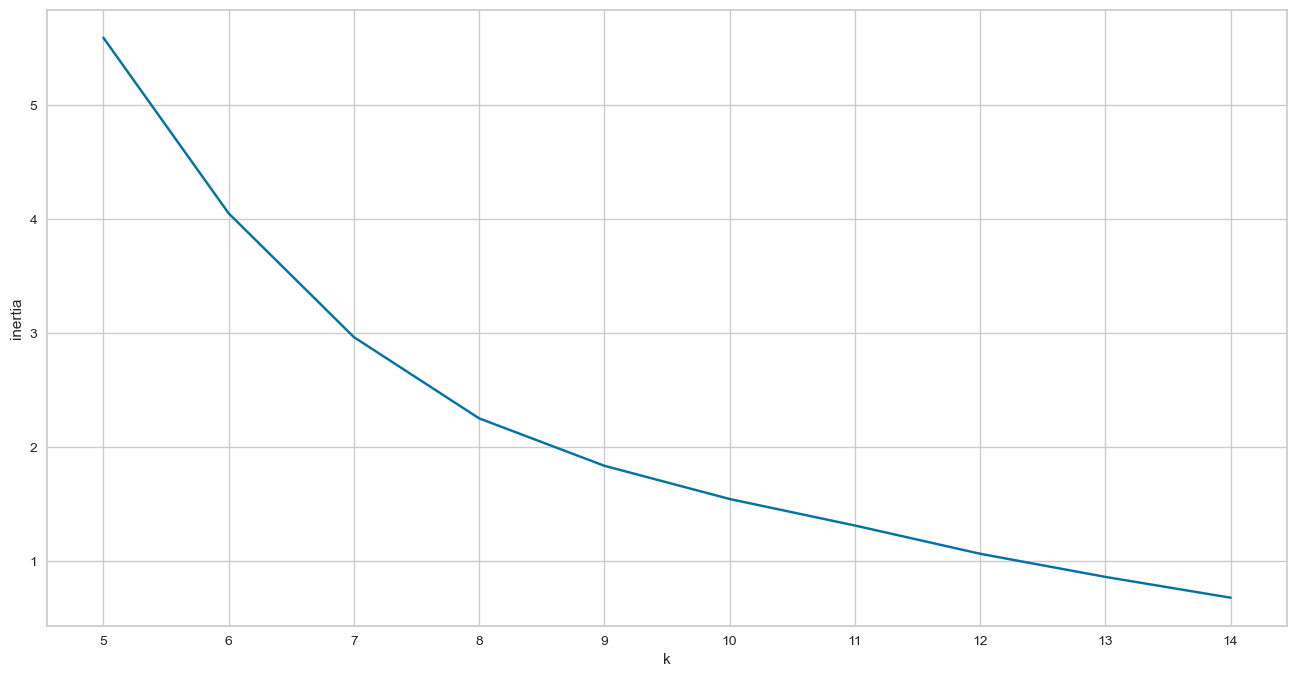

Elbow visualization: Distortion Score (KElbowVisualizer)


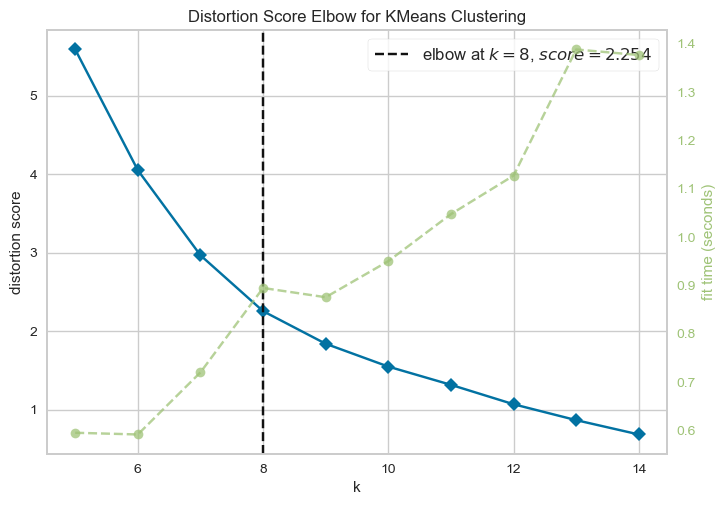

Silhouette score


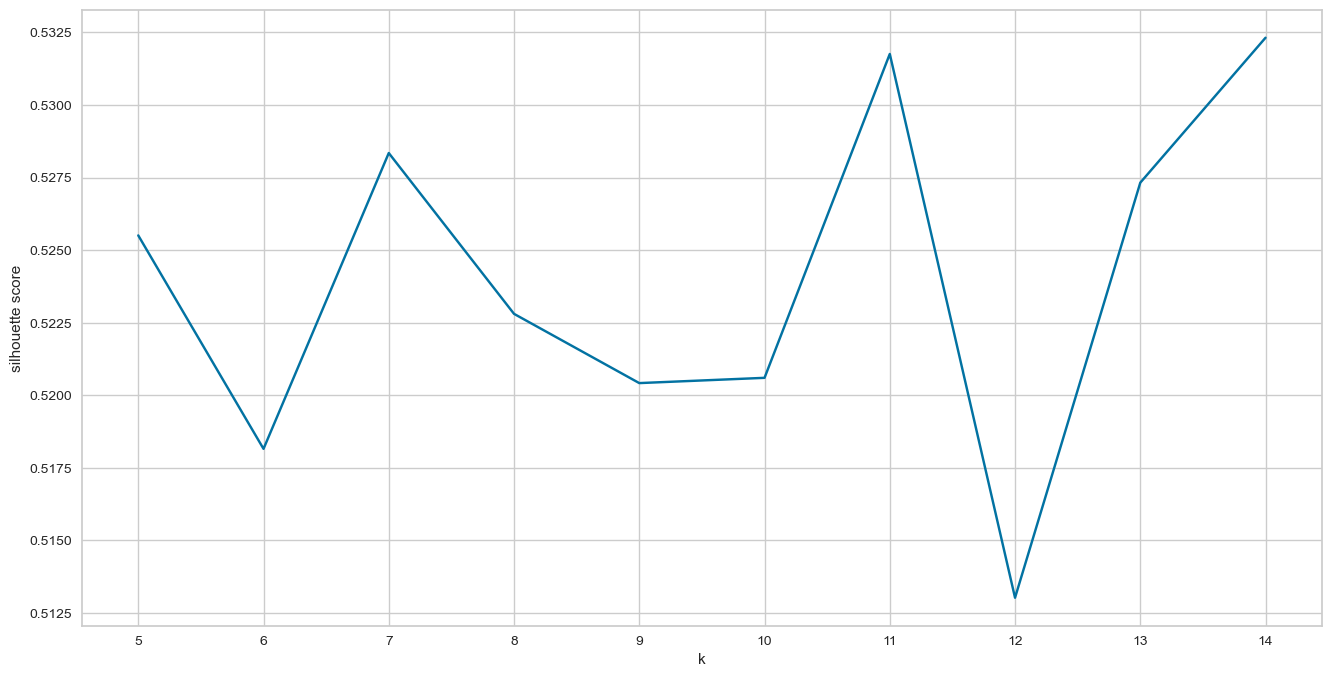

In [91]:
tfidf_embeddings = np.vstack(tfidf_embeddings)
find_k(tfidf_embeddings, 5, 15)

In [92]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(tfidf_embeddings)
clusters = kmeans.predict(tfidf_embeddings)

metrics = clustering_metrics(tfidf_embeddings, clusters)
evaluation_results["Reduced tasting notes + embeddings"] = metrics
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004}}

There has not been a great improvement, probably because there are still too many descriptors that appear in very few wines (noise for the model).

# Increased proportion of dropped words

In [93]:
# Functions to do the transformations and return the recommended K (using KElbowVisualizer)

tfidf = TfidfVectorizer(stop_words='english')
cores = multiprocessing.cpu_count() 

def elbow_visualizer(X, k_min, k_max):
    model = KMeans(max_iter=100, random_state=42)
    visualizer = KElbowVisualizer(model, k=(k_min, k_max))
    visualizer.fit(X)
    plt.close()
    return visualizer.elbow_value_

def onehot_and_find_k_short(df, column, mink, maxk):
    # One hot encoding
    tasting_terms = [value for sublist in df[column].str.split(" ") if isinstance(sublist, list) for value in sublist]
    tasting_terms = [value for value in tasting_terms if not pd.isna(value)]
    tasting_terms = list(dict.fromkeys(tasting_terms))

    tasting_encoded = df[[column]] 
    for term in tasting_terms:
        tasting_encoded[term] = 0 

    for index, row in tasting_encoded.iterrows():
        tasting_note = row[column]
        for term in tasting_note.split(" "):
            tasting_encoded.loc[index, term] = 1
            
    tasting_encoded = tasting_encoded.drop(column, axis=1)

    one_hot_k = elbow_visualizer(tasting_encoded, 5, 15)
    
    return tasting_encoded, one_hot_k

def tfidf_and_find_k_short(df, column, mink, maxk):
    # TF-IDF
    wine_features = tfidf.fit_transform(df[column]).toarray()
    tfidf_k = elbow_visualizer(wine_features, 5, 15)    
    return wine_features, tfidf_k

def embeddings_and_find_k_short(df, column, mink, maxk):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    tfidf_embeddings_array = np.array(tfidf_embeddings)

    embeddings_k = elbow_visualizer(tfidf_embeddings_array, 5, 15)    
    
    return w2v_model, tfidf_embeddings, embeddings_k

In [94]:
# One hot encoding

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        tasting_encoded, one_hot_k = onehot_and_find_k_short(text_data, col, 5, 20)
        if one_hot_k != None:
            kmeans = KMeans(n_clusters=one_hot_k, random_state=42)
            kmeans.fit(tasting_encoded)
            clusters = kmeans.predict(tasting_encoded)
            metrics = clustering_metrics(tasting_encoded, clusters)
            evaluation_results[f"Kmeans one hot with {one_hot_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans one hot {col}"] = None

evaluation_results      

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004},
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced': {'Silhouette': 0.012412601773760289},
 'Kmeans one hot notes_norm_removed_reduced50': None,
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced100': {'Silhouette': 0.018287928536725197},
 'Kmeans one hot notes_norm_removed_reduced150': None,
 'Kmeans one hot with 11 clusters in notes_norm_removed_reduced200': {'Silhouette': 0.0155

In [95]:
# TF-IDF

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        wine_features, tfidf_k = tfidf_and_find_k_short(text_data, col, 5, 20)
        if tfidf_k != None:
            kmeans = KMeans(n_clusters=tfidf_k, random_state=42)
            kmeans.fit(wine_features)
            clusters = kmeans.predict(wine_features)
            metrics = clustering_metrics(wine_features, clusters)
            evaluation_results[f"Kmeans TF-IDF with {tfidf_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans TF-IDF {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004},
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced': {'Silhouette': 0.012412601773760289},
 'Kmeans one hot notes_norm_removed_reduced50': None,
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced100': {'Silhouette': 0.018287928536725197},
 'Kmeans one hot notes_norm_removed_reduced150': None,
 'Kmeans one hot with 11 clusters in notes_norm_removed_reduced200': {'Silhouette': 0.0155

In [96]:
# TF-IDF with 9 clusters

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        wine_features, tfidf_k = tfidf_and_find_k_short(text_data, col, 5, 20)
        tfidf_k = 9
        if tfidf_k != None:
            kmeans = KMeans(n_clusters=tfidf_k, random_state=42)
            kmeans.fit(wine_features)
            clusters = kmeans.predict(wine_features)
            metrics = clustering_metrics(wine_features, clusters)
            evaluation_results[f"Kmeans TF-IDF with {tfidf_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans TF-IDF {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004},
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced': {'Silhouette': 0.012412601773760289},
 'Kmeans one hot notes_norm_removed_reduced50': None,
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced100': {'Silhouette': 0.018287928536725197},
 'Kmeans one hot notes_norm_removed_reduced150': None,
 'Kmeans one hot with 11 clusters in notes_norm_removed_reduced200': {'Silhouette': 0.0155

In [97]:
# Embeddings

for col in text_data.columns:
    if col.startswith("notes_norm_removed_reduced"):
        w2v_model, tfidf_embeddings, embeddings_k = embeddings_and_find_k_short(text_data, col, 5, 20)
        if embeddings_k != None:
            kmeans = KMeans(n_clusters=embeddings_k, random_state=42)
            kmeans.fit(tfidf_embeddings)
            clusters = kmeans.predict(tfidf_embeddings)
            metrics = clustering_metrics(tfidf_embeddings, clusters)
            evaluation_results[f"Kmeans embeddings with {embeddings_k} clusters in {col}"] = metrics
        else:
            evaluation_results[f"Kmeans embeddings {col}"] = None
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004},
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced': {'Silhouette': 0.012412601773760289},
 'Kmeans one hot notes_norm_removed_reduced50': None,
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced100': {'Silhouette': 0.018287928536725197},
 'Kmeans one hot notes_norm_removed_reduced150': None,
 'Kmeans one hot with 11 clusters in notes_norm_removed_reduced200': {'Silhouette': 0.0155

The best results are cleary obtained with the word embeddings. Regarding the threshold for the dropped terms, the highest silhouette score was obtained with 300, but we have to bear in mind that this removes 88% of our descriptors (compared with threshold = 1).<br>
Therefore we will try also the clustering with 200 (leaves out 74% of the descriptors) and with 1.

In [98]:
# Function that transforms to embeddings and displays visualizations for finding the optimal K

def embeddings_and_find_k(df, column, mink, maxk):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    tfidf_embeddings_array = np.array(tfidf_embeddings)
    
    find_k(tfidf_embeddings_array, mink, maxk)
    
    return w2v_model, tfidf_embeddings_array

Elbow visualization: Inertia


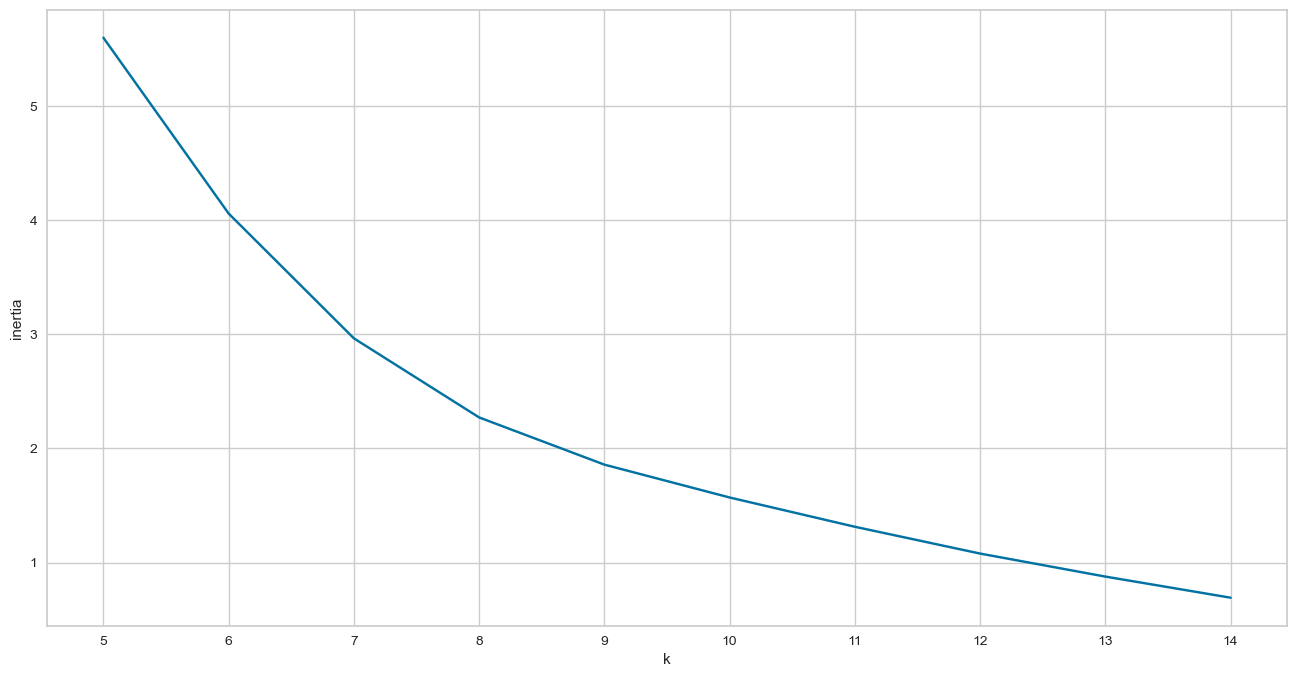

Elbow visualization: Distortion Score (KElbowVisualizer)


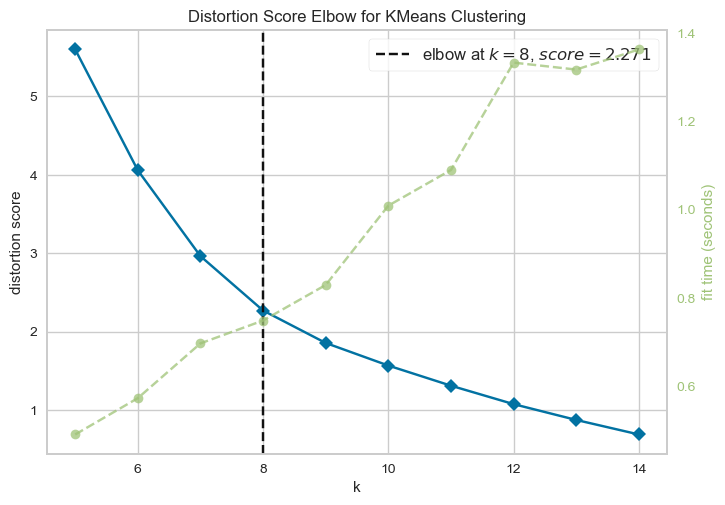

Silhouette score


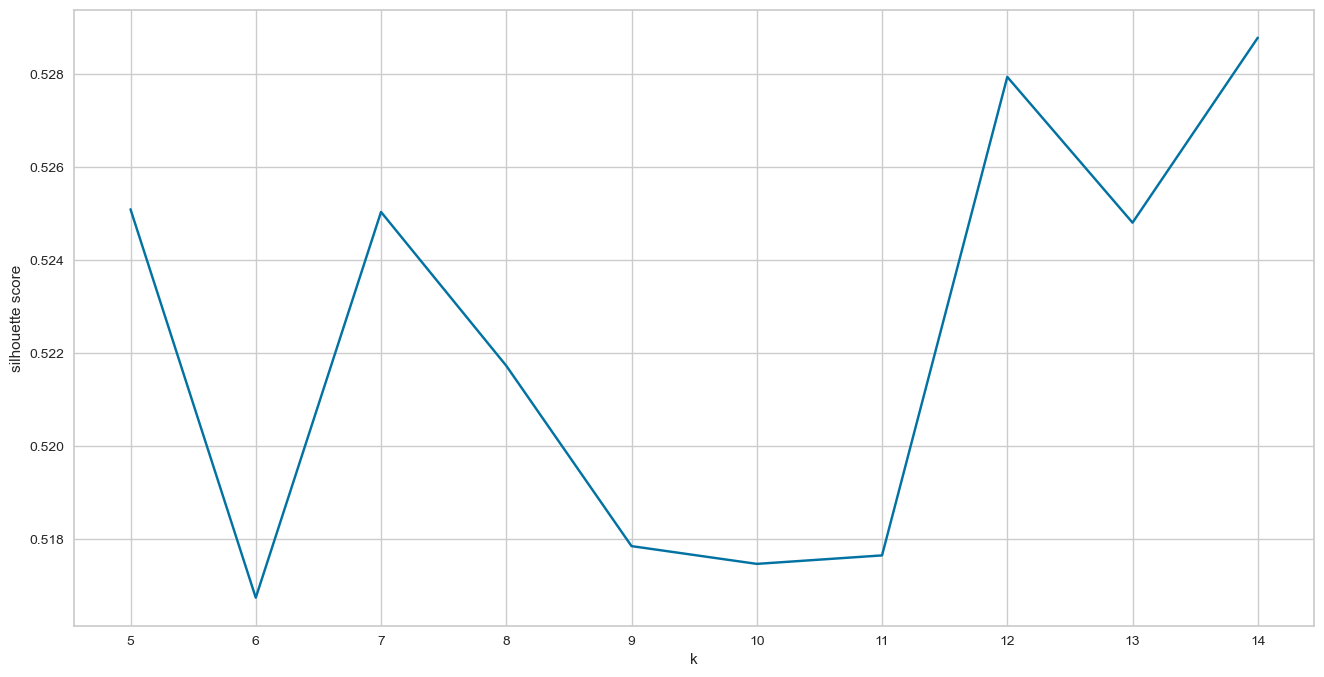

In [99]:
w2v_model, embeddings1 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced", 5, 15)

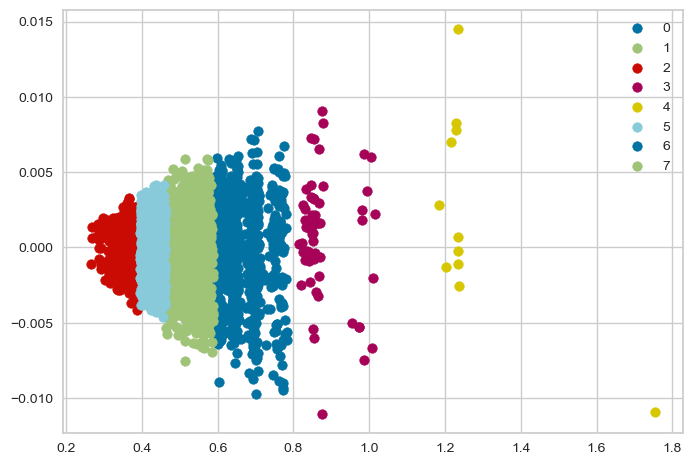

In [100]:
plot_clusters_kmeans(embeddings1, 8)

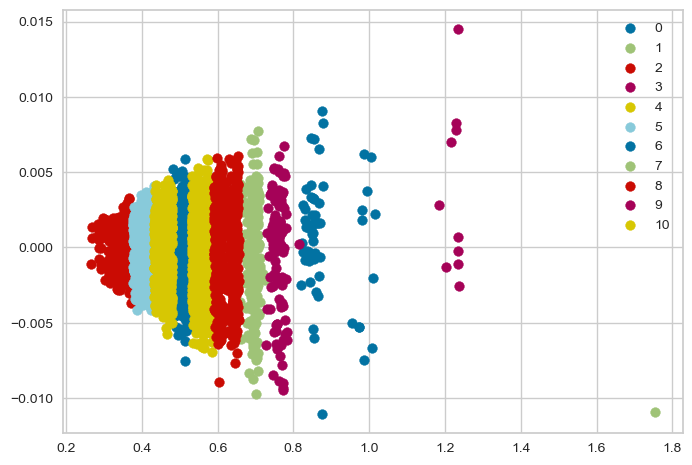

In [101]:
plot_clusters_kmeans(embeddings1, 11)

Elbow visualization: Inertia


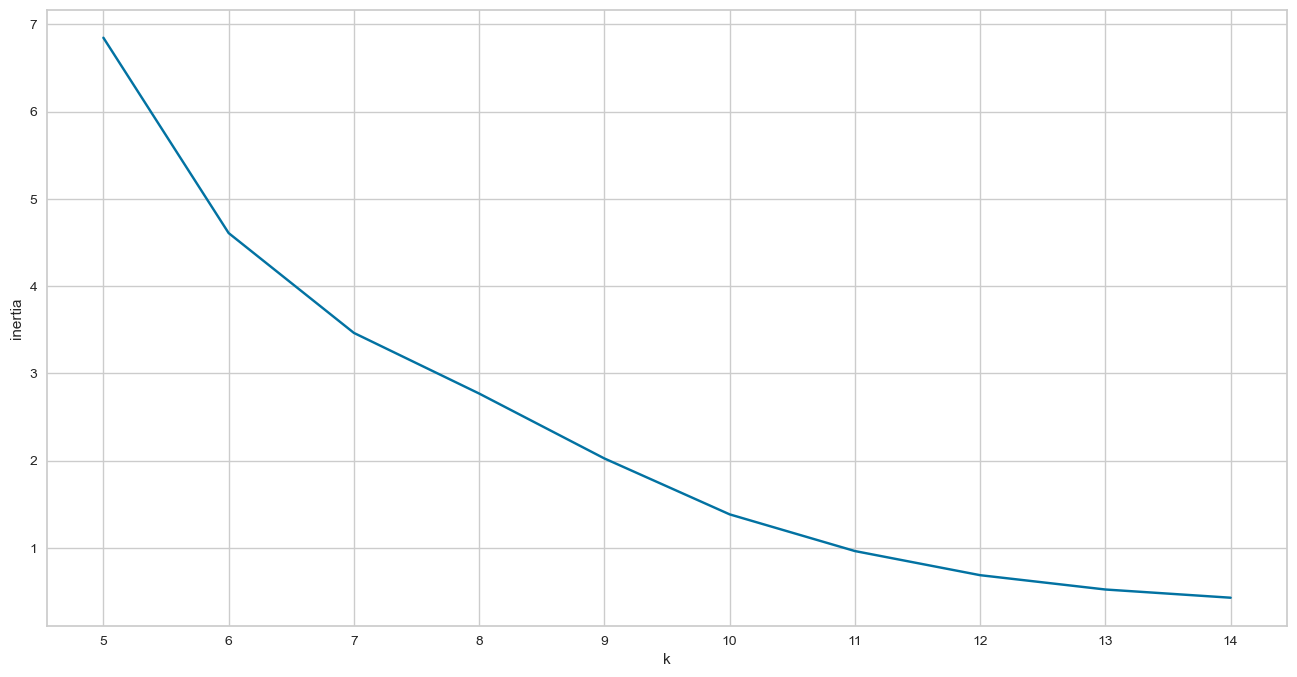

Elbow visualization: Distortion Score (KElbowVisualizer)


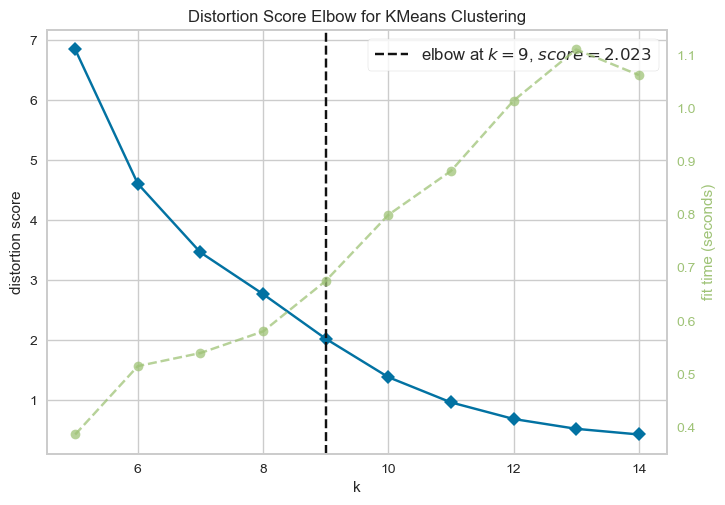

Silhouette score


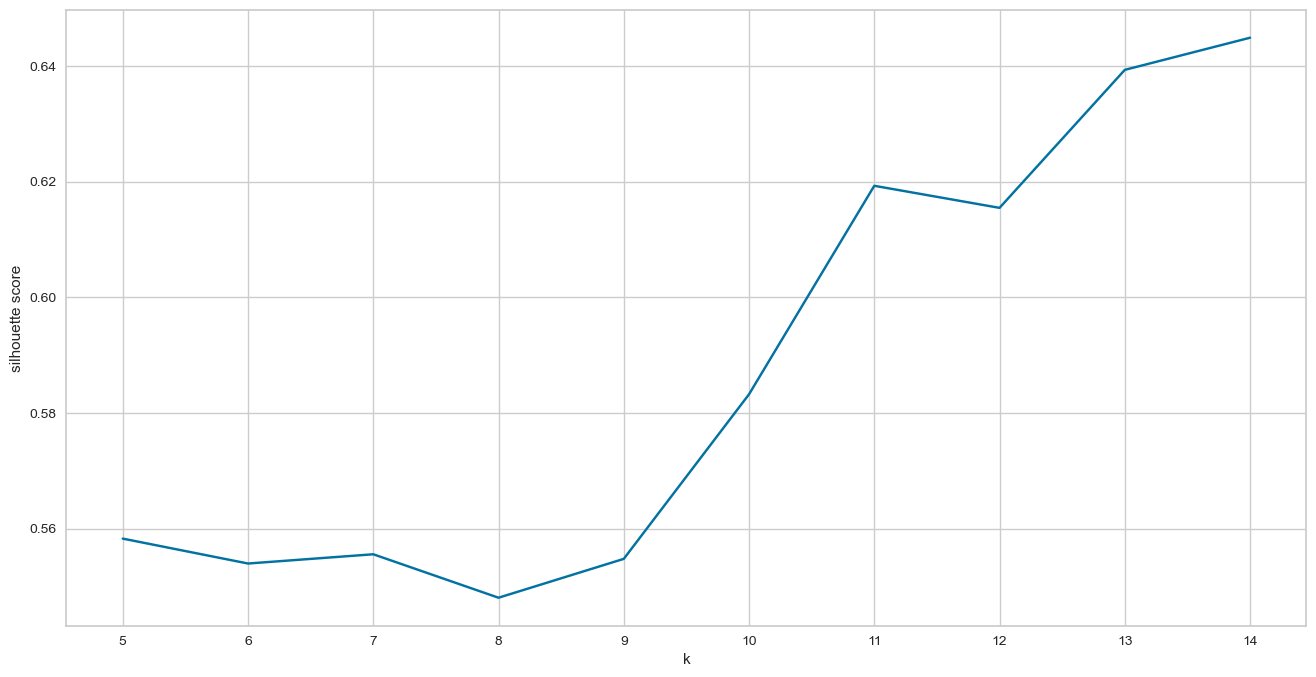

In [102]:
w2v_model, embeddings100 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced100", 5, 15)

In the inertia visualization there is a potential elbow in 7. We will try also with 9 (elbow detected by KElbowVisualizer) and 14 (higher SC)

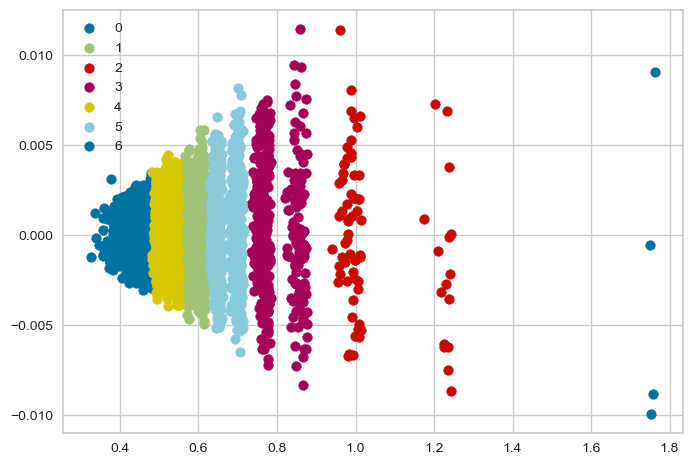

In [104]:
plot_clusters_kmeans(embeddings100, 7)

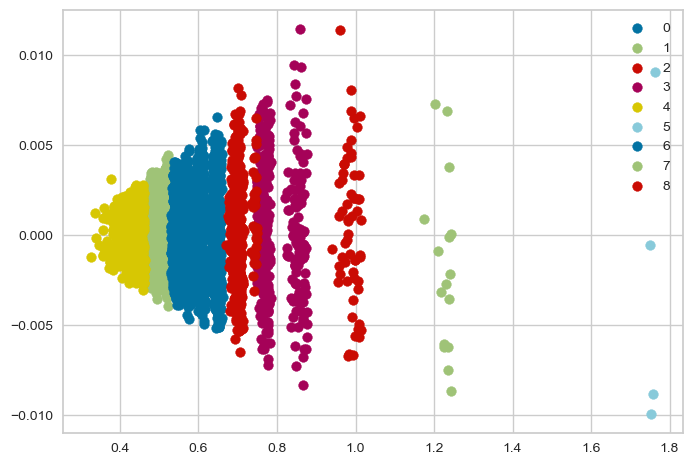

In [105]:
plot_clusters_kmeans(embeddings100, 9)

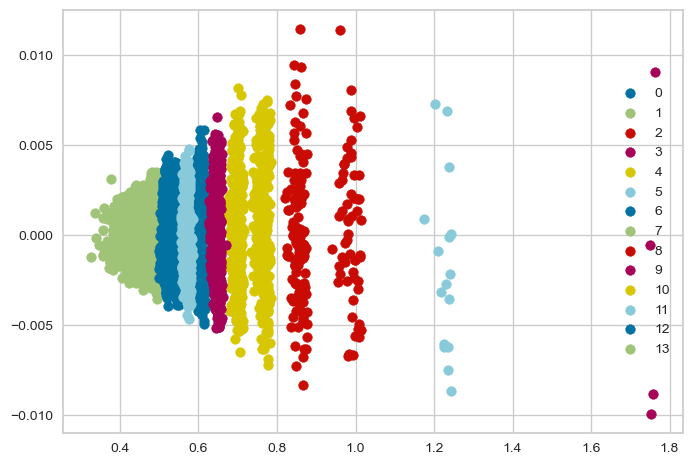

In [106]:
plot_clusters_kmeans(embeddings100, 14)

Elbow visualization: Inertia


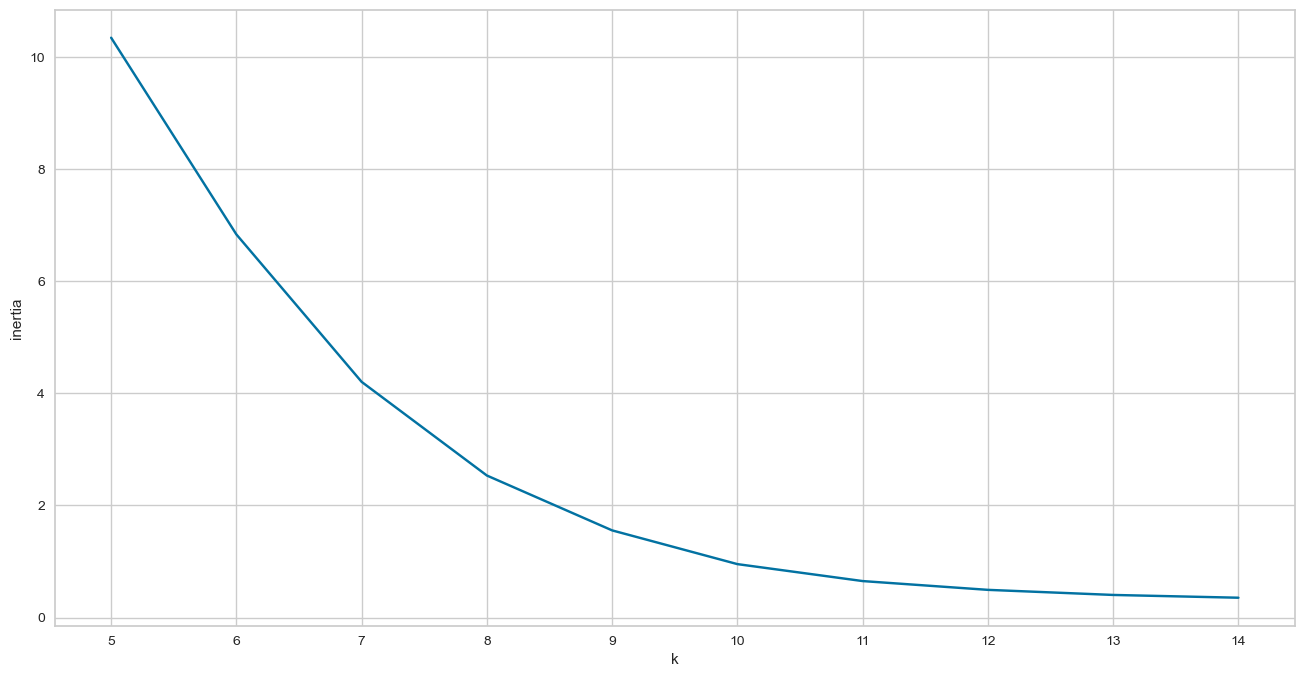

Elbow visualization: Distortion Score (KElbowVisualizer)


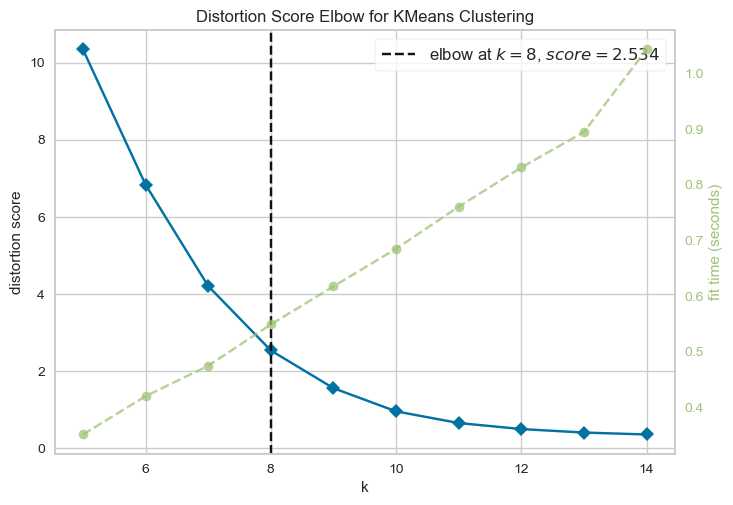

Silhouette score


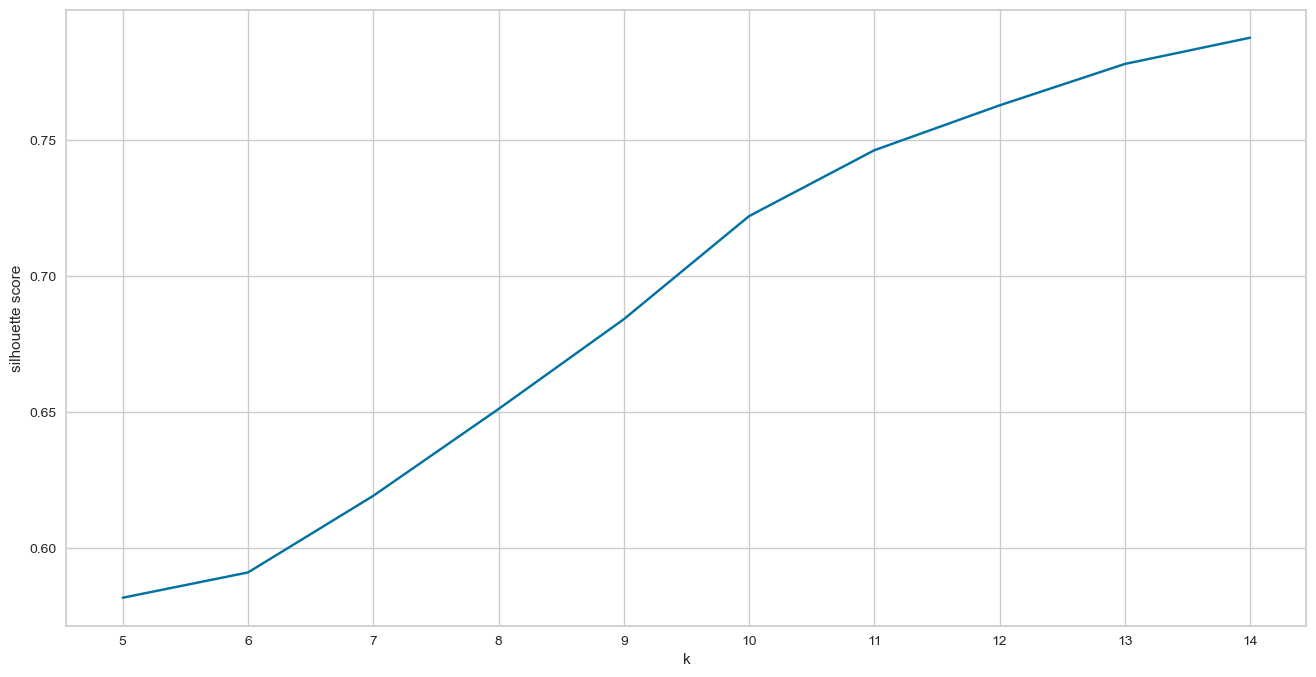

In [107]:
w2v_model, embeddings300 = embeddings_and_find_k(text_data, "notes_norm_removed_reduced300", 5, 15)

K=8 is the elbow but 14 has a much higher silhouette score. 

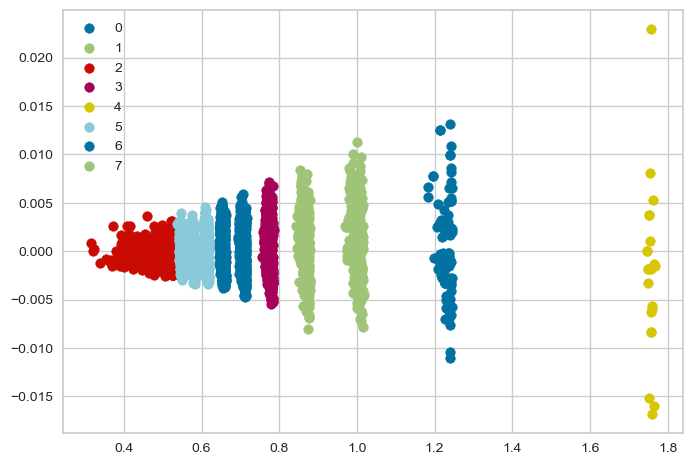

In [108]:
plot_clusters_kmeans(embeddings300, 8)

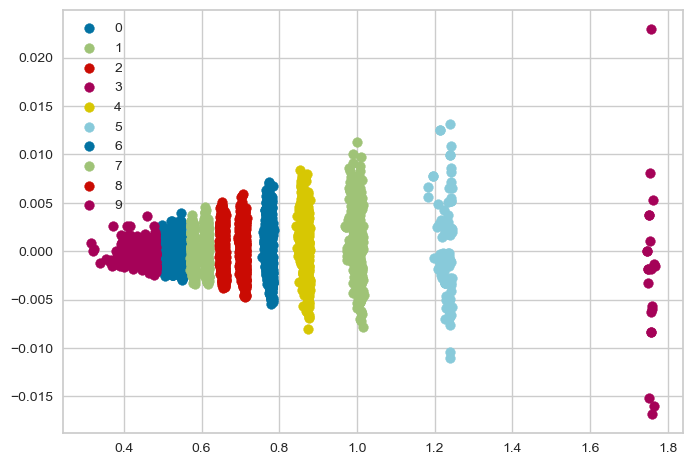

In [109]:
plot_clusters_kmeans(embeddings300, 10)

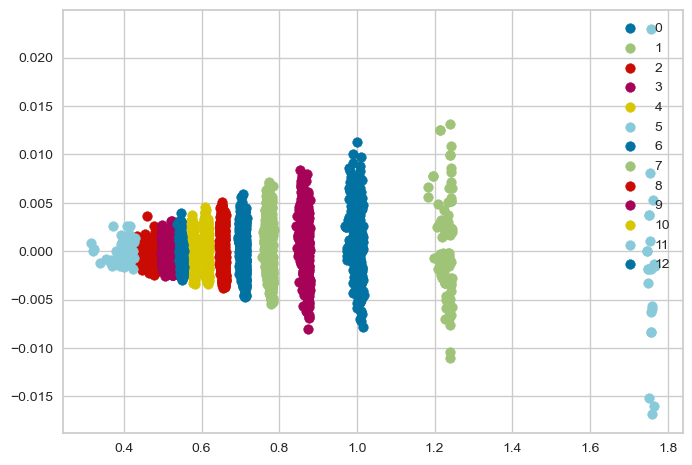

In [110]:
plot_clusters_kmeans(embeddings300, 13)

# Cluster with DBSCAN

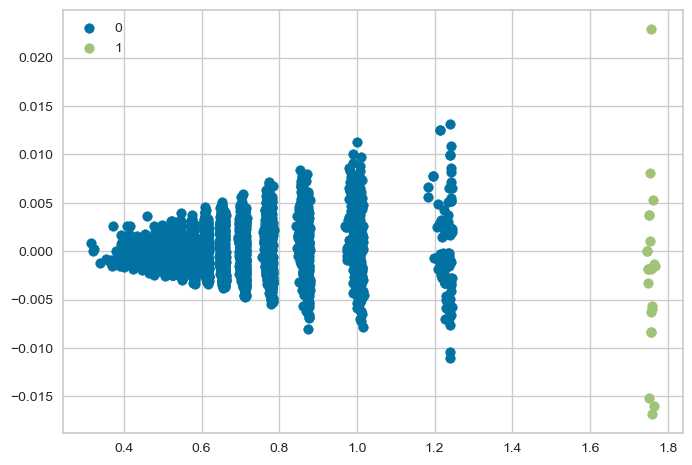

In [111]:
plot_clusters_dbscan(embeddings300, 0.5)

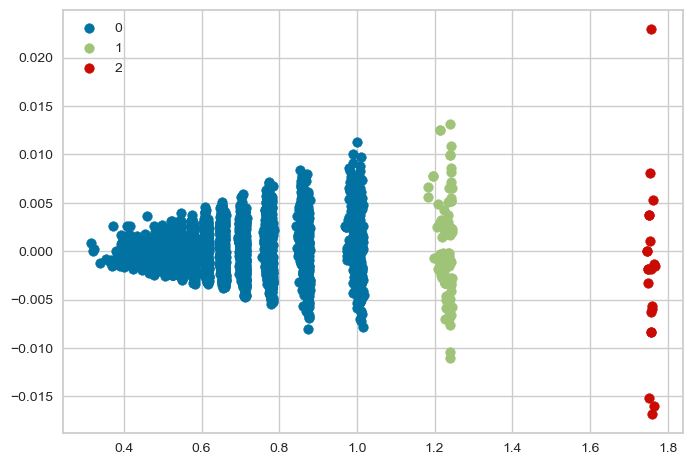

In [112]:
plot_clusters_dbscan(embeddings300, 0.1)

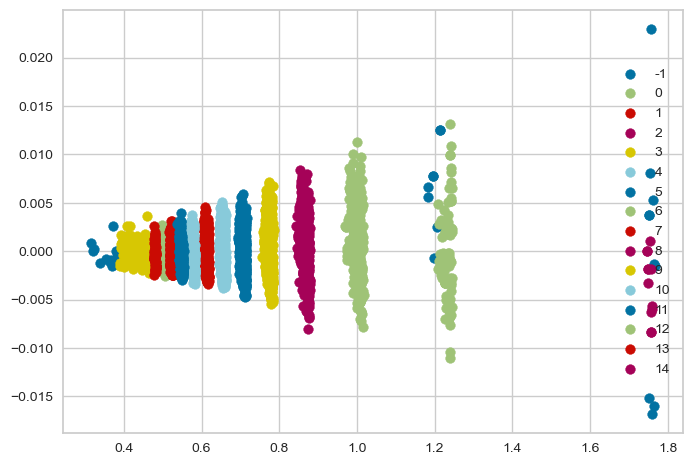

In [113]:
plot_clusters_dbscan(embeddings300, 0.005)

DBSCAN is clearly performing worse than KMeans for this dataset.

# Clustering with Gaussian Mixtures

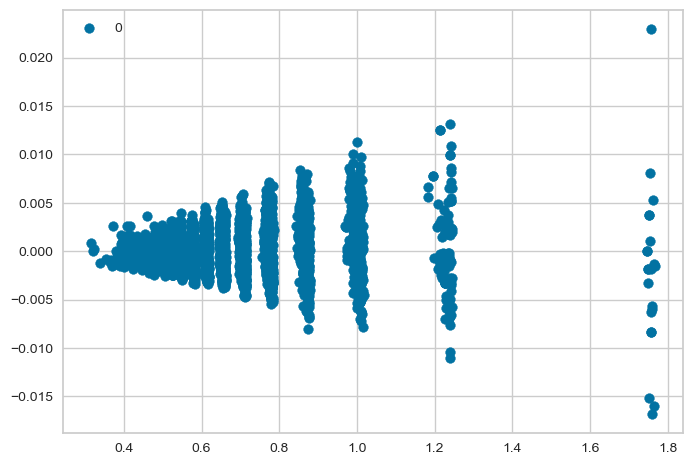

In [114]:
plot_clusters_gaussian(embeddings300, 1)

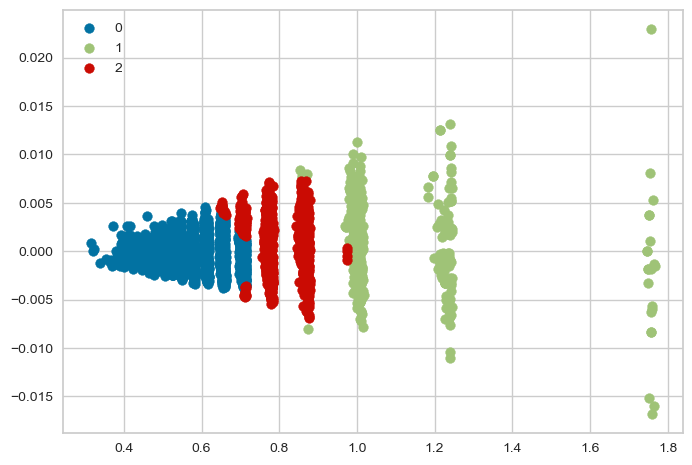

In [115]:
plot_clusters_gaussian(embeddings300, 3)

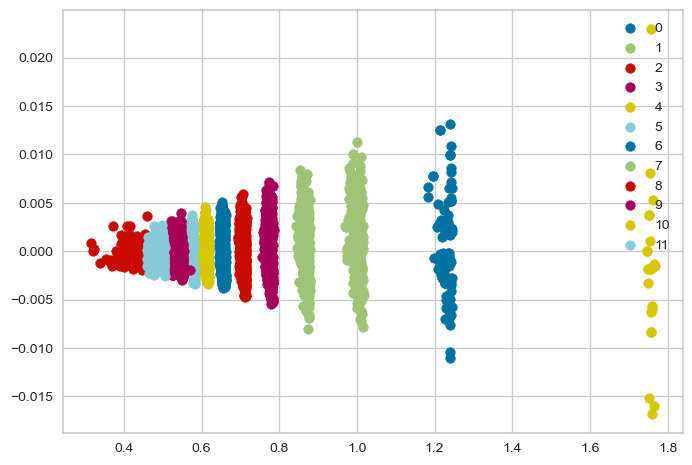

In [116]:
plot_clusters_gaussian(embeddings300, 12)

## Preliminary conclusions
We have tried three types of models: KMeans, DBSCAN and Gaussian Mixtures, and KMeans is performing much better than the other two for this dataset. <br>
We have also tried different thresholds for dropping the less common descriptors, and dropping all the terms that appear less than 300 times greatly improves the performance of the model, as shown by the Silhouette Score and by the clusters visualizations. <br>
However, this removes 88% of our descriptors. To make sure that the principal characteristics of the wines are preserved, we have done a new reduction of the tasting notes descriptors (see the EDA notebook).

### New reduction of the tasting notes descriptors

Elbow visualization: Inertia


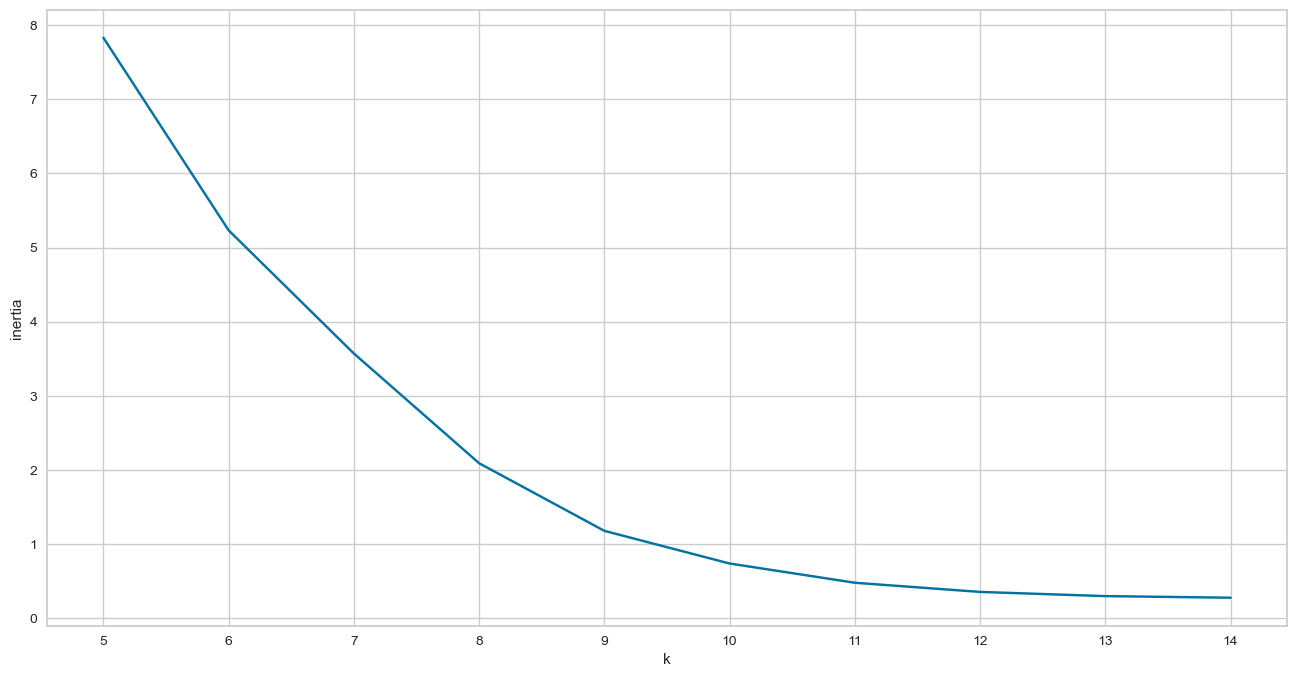

Elbow visualization: Distortion Score (KElbowVisualizer)


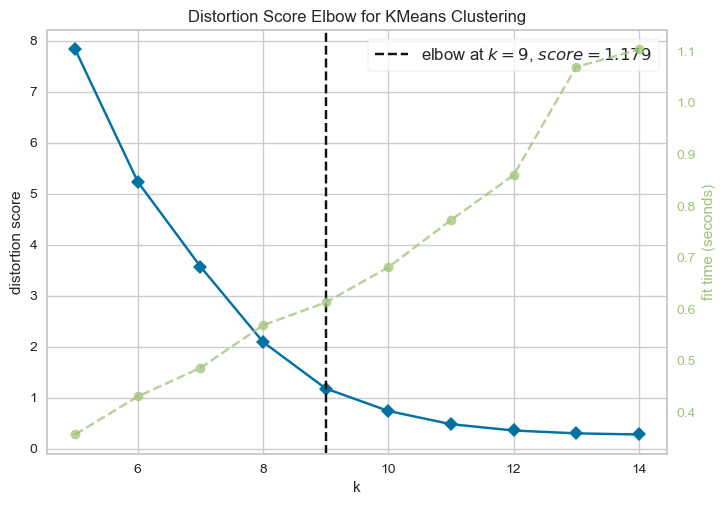

Silhouette score


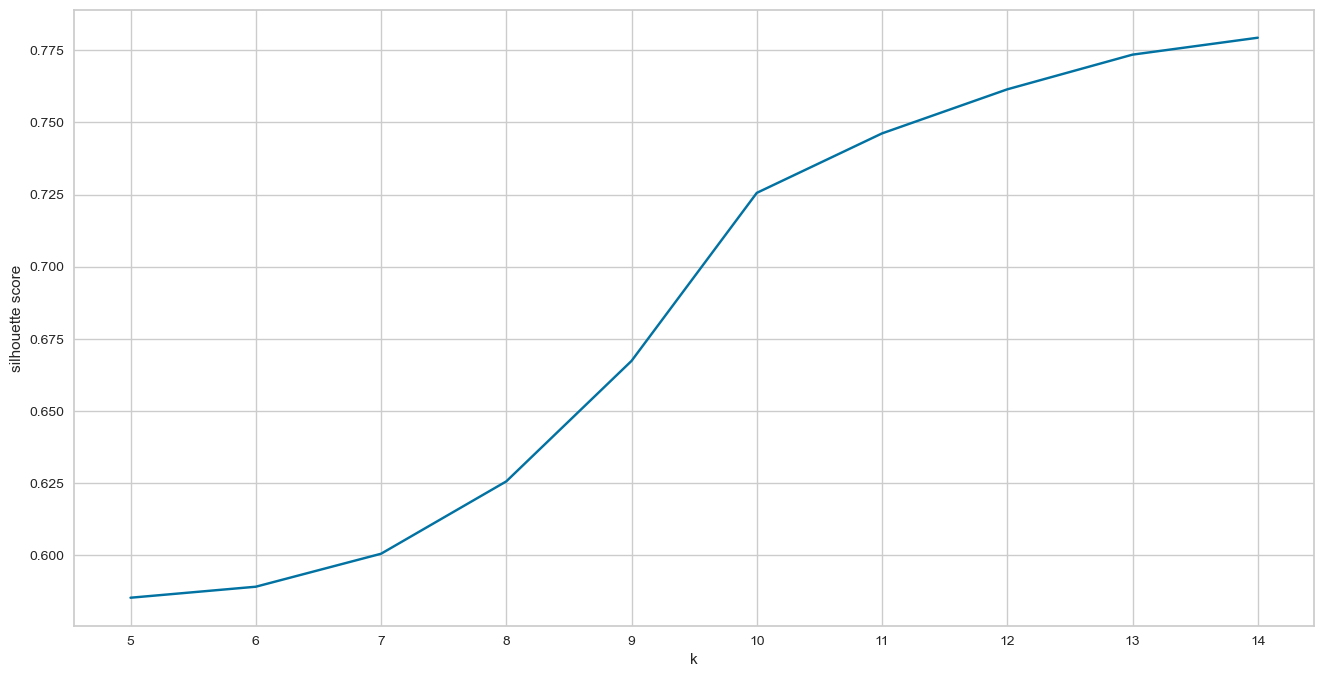

In [117]:
w2v_model, new_embeddings = embeddings_and_find_k(text_data, "notes_norm_removed_new_reduction_dropped", mink=5, maxk=15)

In [118]:
# Get the vocabulary of the Word2Vec model
word2vec_vocabulary = list(set(w2v_model.wv.index_to_key))
word2vec_vocabulary

['toasty',
 'green_fruit',
 'flavoursome',
 'red_fruit',
 'complex',
 'unctuous',
 'rich',
 'ageing',
 'smooth',
 'black_fruit',
 'elegant',
 'stone_fruit',
 'tannins',
 'balanced',
 'tropical_fruit',
 'balsamic',
 'long',
 'wood',
 'full',
 'mineral',
 'citrus_fruit',
 'rounded',
 'crunchy',
 'structured',
 'good_acidity',
 'powerful',
 'white_fruit',
 'fresh',
 'herbs',
 'finish',
 'aromatic',
 'spices',
 'dried_cooked_fruits',
 'floral',
 'silky',
 'persistent',
 'pleasant',
 'bottle_aging']

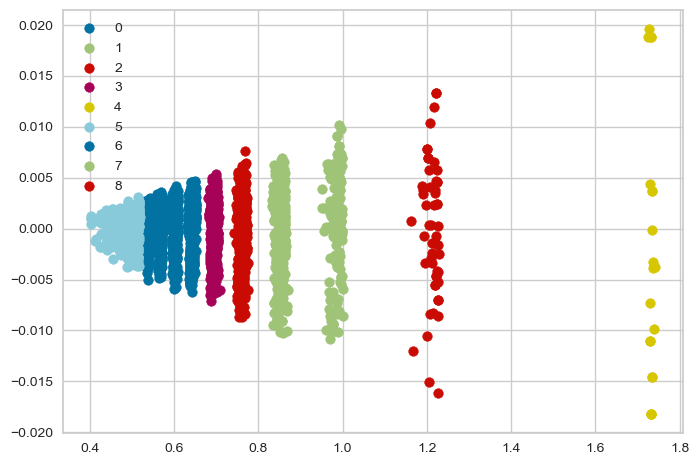

In [119]:
plot_clusters_kmeans(new_embeddings, 9)

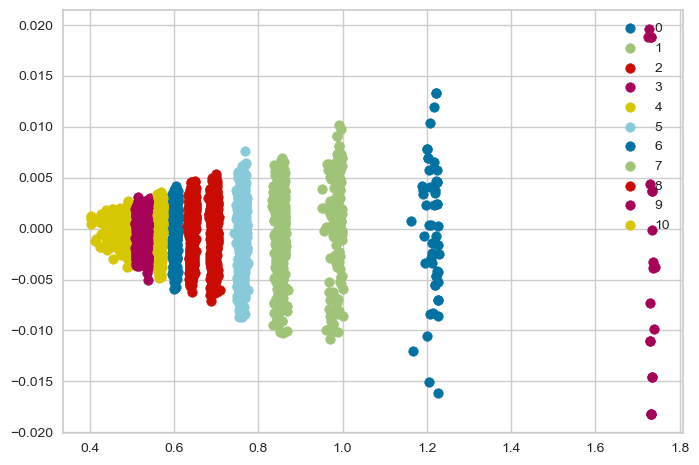

In [120]:
plot_clusters_kmeans(new_embeddings, 11)

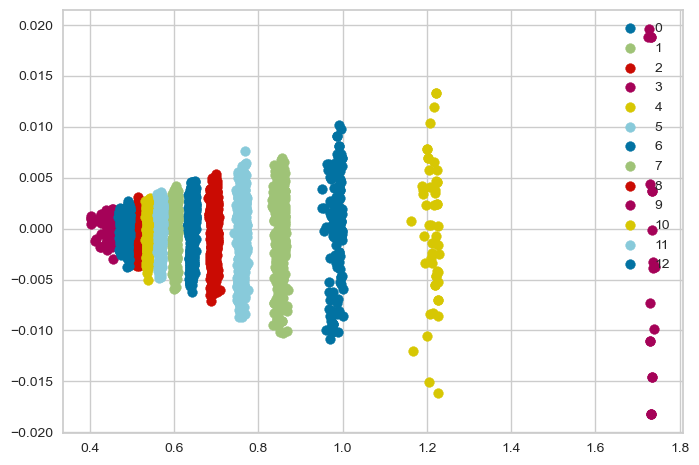

In [121]:
plot_clusters_kmeans(new_embeddings, 13)

In [122]:
for k in [9, 11, 13]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_embeddings)
    clusters = kmeans.predict(new_embeddings)
    metrics = clustering_metrics(new_embeddings, clusters)
    evaluation_results[f"Kmeans embeddings with {k} clusters in notes_norm_removed_new_reduction_dropped"] = metrics
        
evaluation_results

{'Kmeans encoded': {'Silhouette': 0.005148911981253527},
 'Kmeans TF-IDF': {'Silhouette': 0.0011708158746504905},
 'DBSCAN encoded': {'Silhouette': -0.18711865109908404},
 'DBSCAN TF-IDF 0.5 eps 2 min samples': {'Silhouette': -0.12380840500361548},
 'DBSCAN TF-IDF 0.3 eps 2 min samples': {'Silhouette': -0.11765577888893797},
 'Kmeans Embeddings': {'Silhouette': 0.49546614},
 'Reduced tasting notes + encoding': {'Silhouette': 0.011371676352794449},
 'Reduced tasting notes + td idf': {'Silhouette': 0.028068851513071116},
 'Reduced tasting notes + embeddings': {'Silhouette': 0.52737004},
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced': {'Silhouette': 0.012412601773760289},
 'Kmeans one hot notes_norm_removed_reduced50': None,
 'Kmeans one hot with 9 clusters in notes_norm_removed_reduced100': {'Silhouette': 0.018287928536725197},
 'Kmeans one hot notes_norm_removed_reduced150': None,
 'Kmeans one hot with 11 clusters in notes_norm_removed_reduced200': {'Silhouette': 0.0155

In [123]:
len(evaluation_results)

40

## Explore the clusters
We will have a look into the clusters obtained with K=11 and with K=13.

In [124]:
def explore_clusters(df, notes_column, cluster_column, cluster):
    cluster_df = df[df[cluster_column]==cluster]

    print(f"CLUSTER {cluster}")
    print(f"The size of this cluster is {len(cluster_df)} wines")
    
    # Type of wine
    ax = sns.countplot(y=cluster_df["type_wine"], order=cluster_df["type_wine"].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Count")
    plt.ylabel("Type of wine")
    plt.show()
    
    # Region (Geographical Indication)
    plt.figure(figsize=(15,12))
    ax = sns.countplot(y=cluster_df["region_gi"], order=cluster_df["region_gi"].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Count")
    plt.ylabel("Geographical Indication")
    plt.show()
        
    # Tasting notes
    cluster_df["tasting_notes_lists"] = cluster_df[notes_column].str.split()
    cluster_df = cluster_df.reset_index(drop=True)
    
    corpus = []
    for i in range(cluster_df.shape[0]): 
        corpus += cluster_df["tasting_notes_lists"][i] 
        
    mostCommon = Counter(corpus).most_common(10)
    
    words = []
    freq = []
    for word, count in mostCommon:
        words.append(word)
        freq.append(count)

    ax = sns.barplot(x=freq, y=words)
    ax.bar_label(ax.containers[0])
    plt.title(f"Top 10 Most Frequently Occuring Words (Cluster {cluster})")
    plt.show()

In [125]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(new_embeddings)
clusters11 = kmeans.predict(new_embeddings)
text_data["cluster11"] = clusters11

In [126]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(new_embeddings)
clusters13 = kmeans.predict(new_embeddings)
text_data["cluster13"] = clusters13

In [127]:
# text_data.head()

### K=11

In [128]:
text_data["cluster11"].value_counts()

0     593
8     555
2     492
10    477
5     472
7     416
9     317
1     279
6     140
4      55
3      20
Name: cluster11, dtype: int64

CLUSTER 0
The size of this cluster is 593 wines


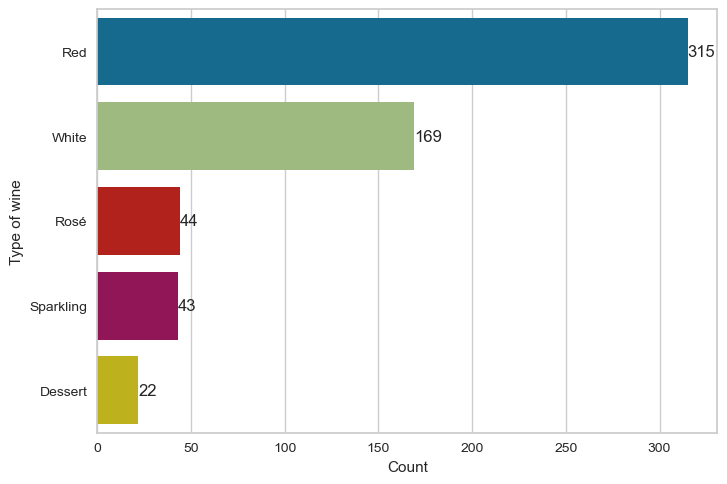

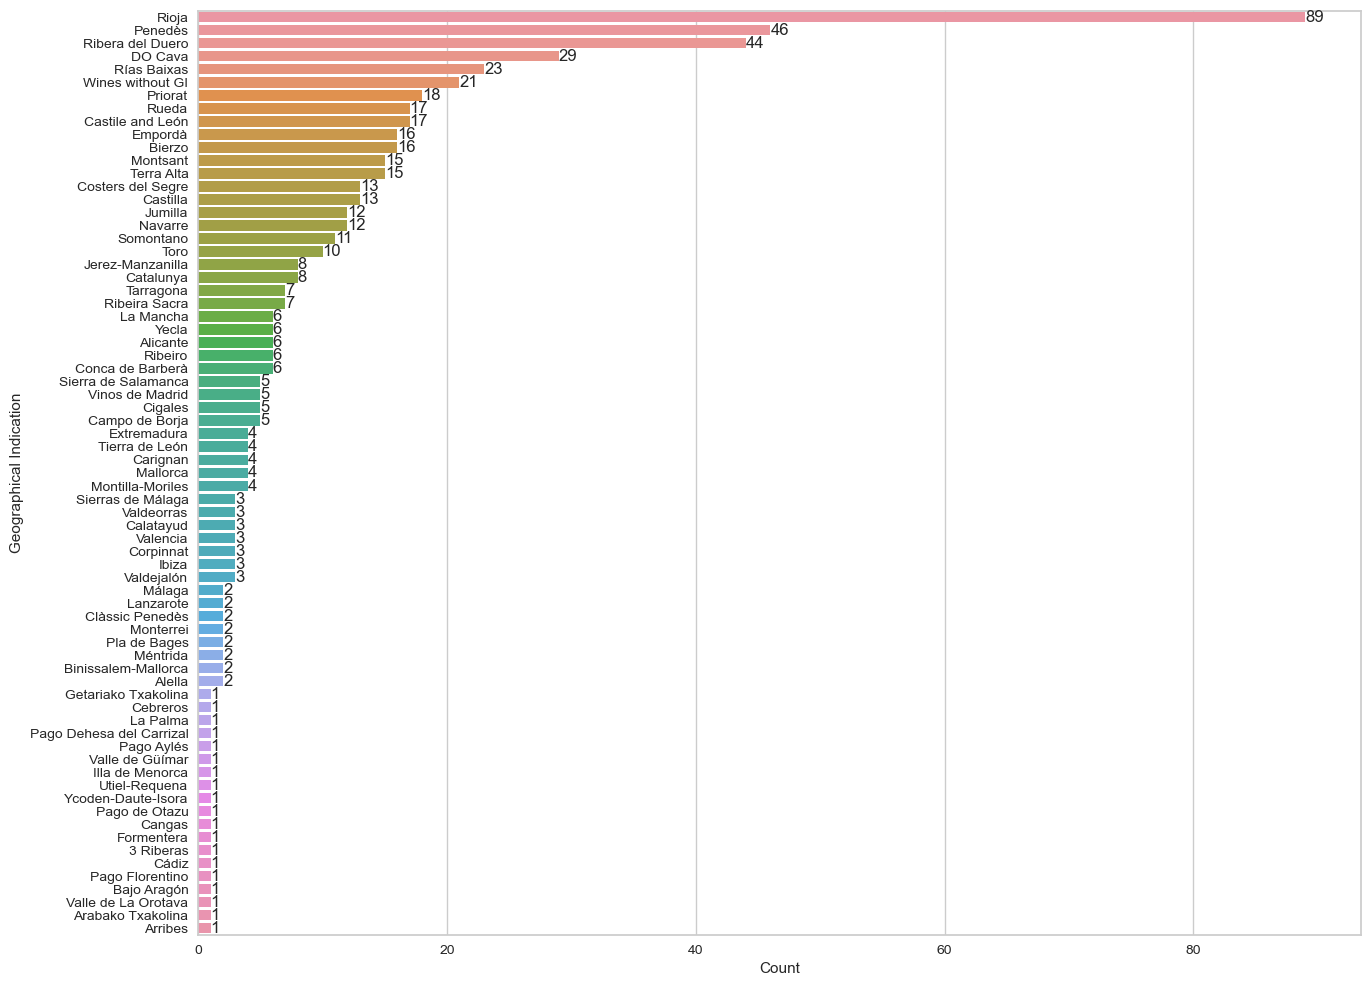

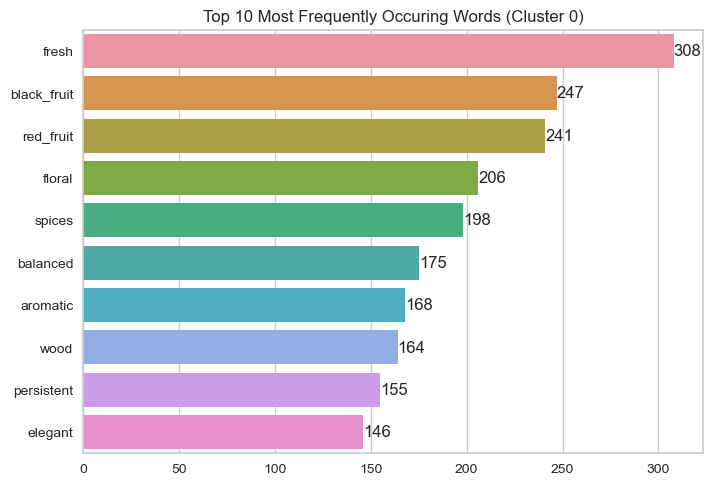

CLUSTER 1
The size of this cluster is 279 wines


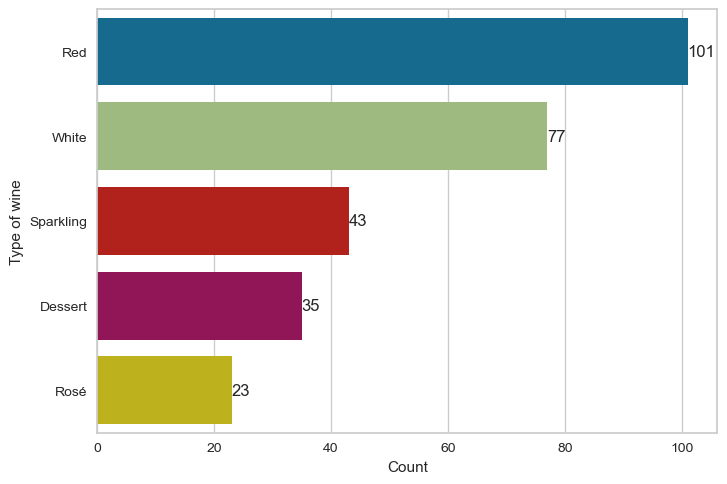

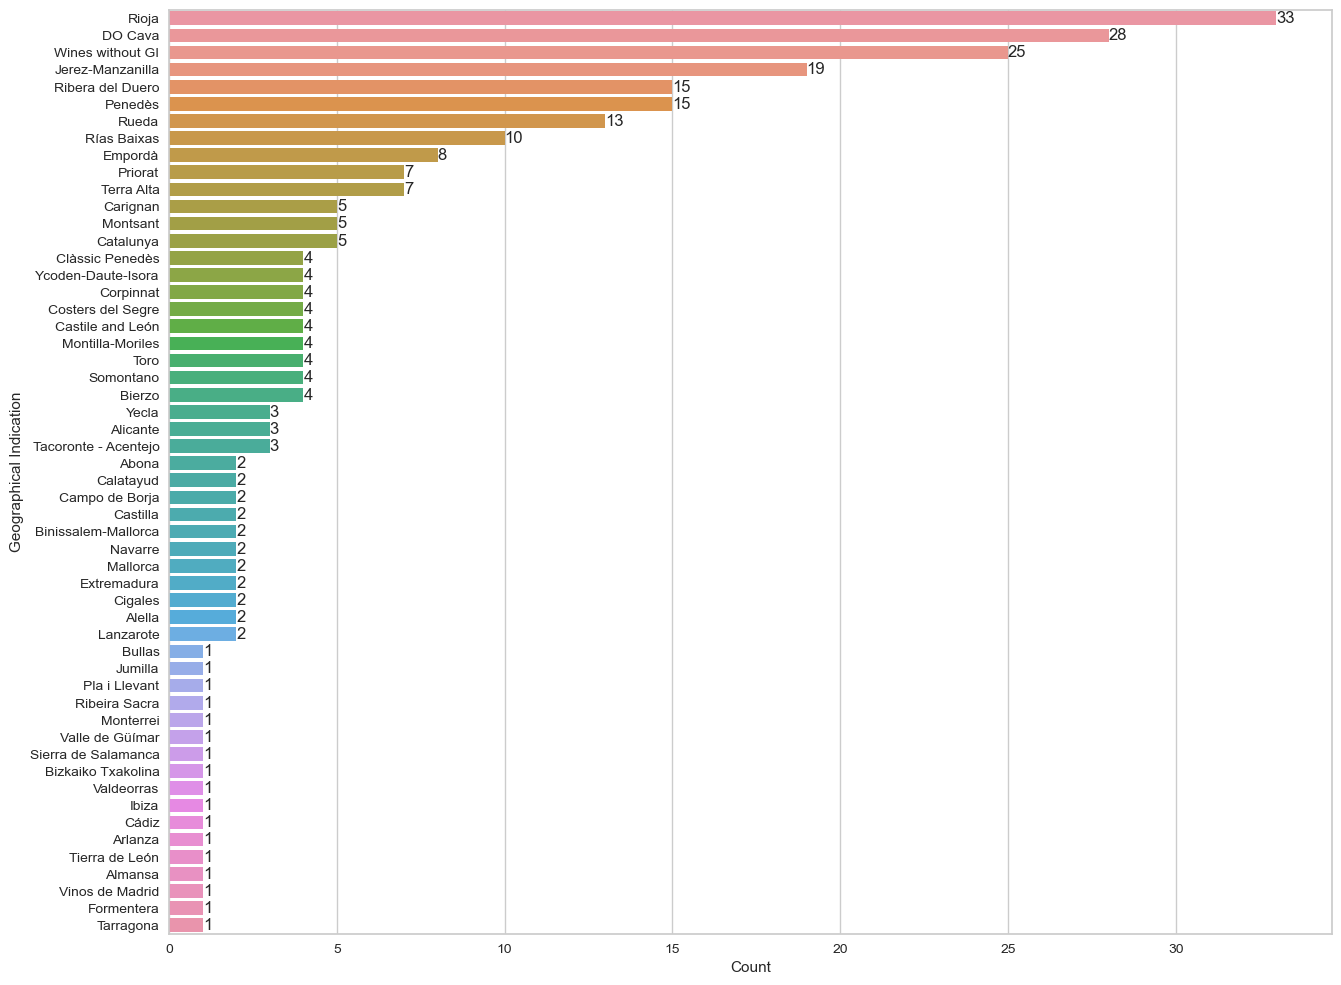

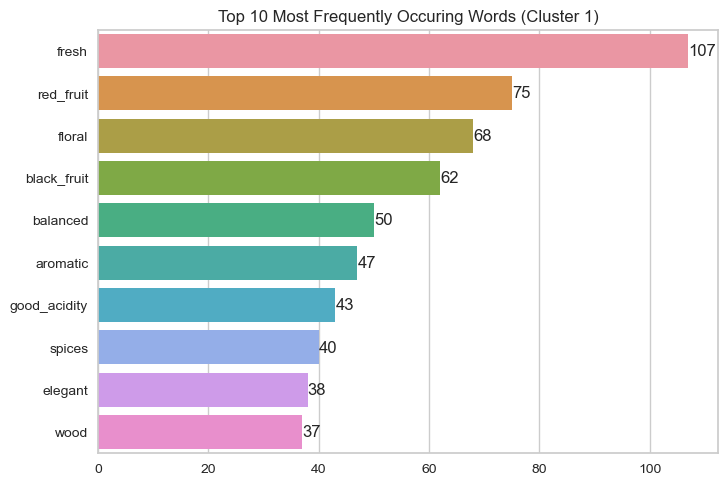

CLUSTER 2
The size of this cluster is 492 wines


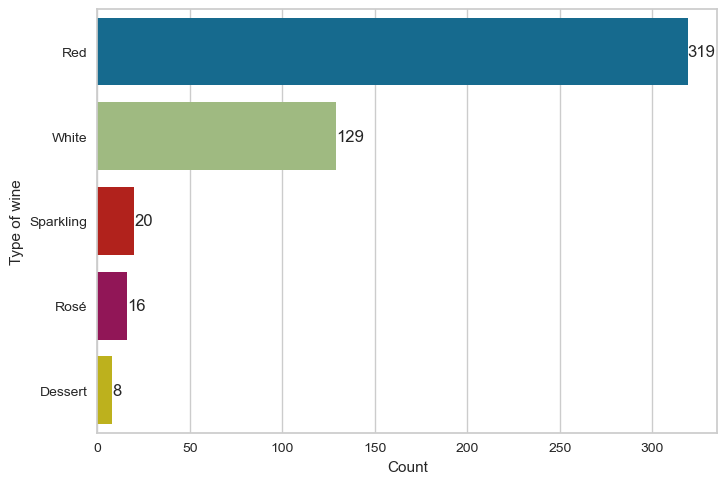

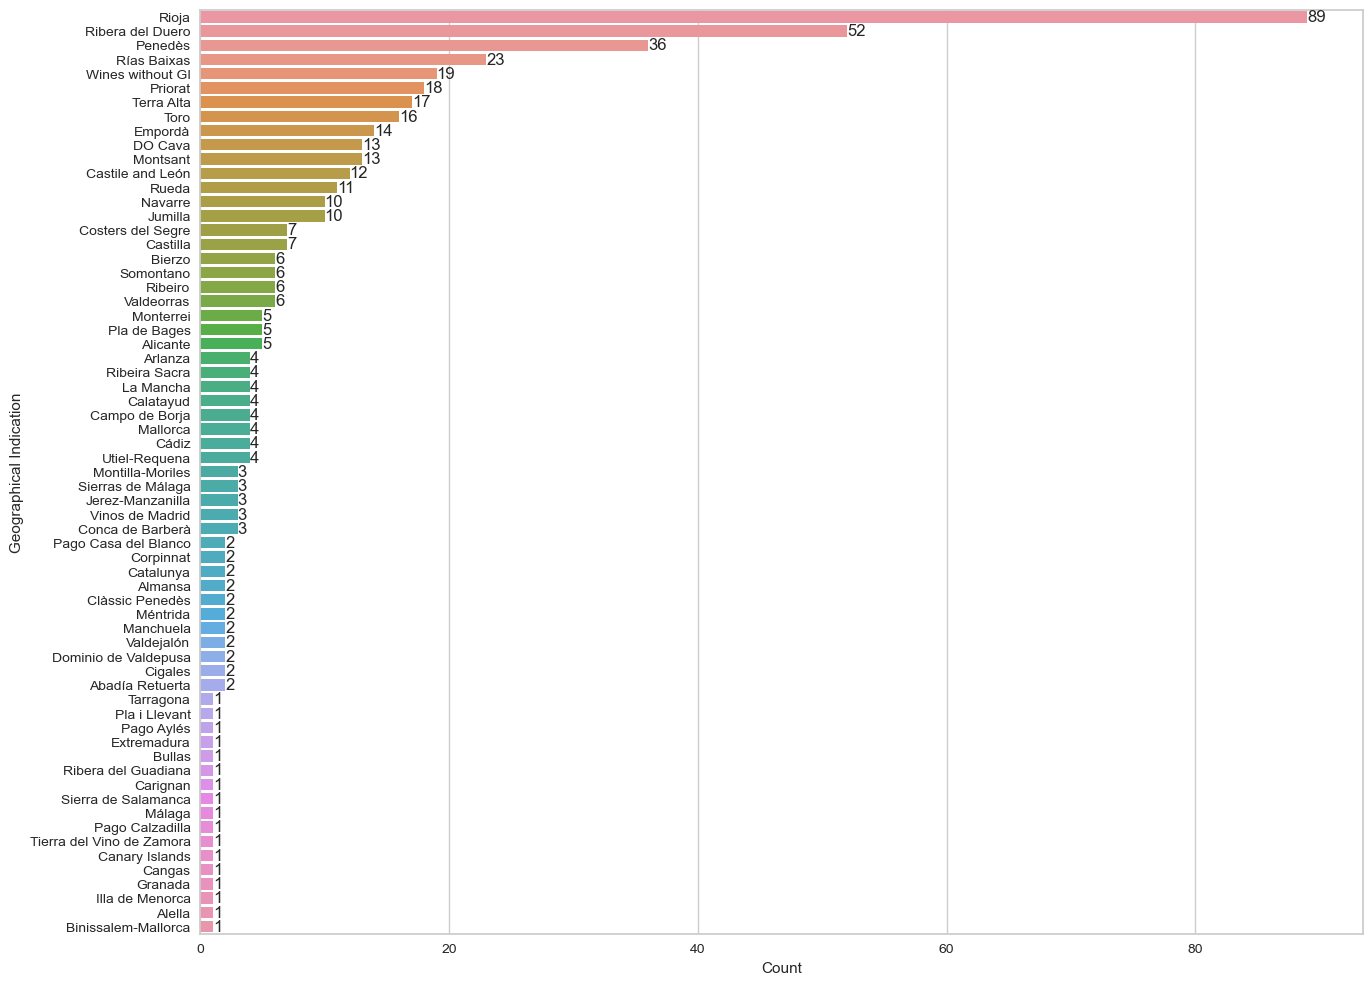

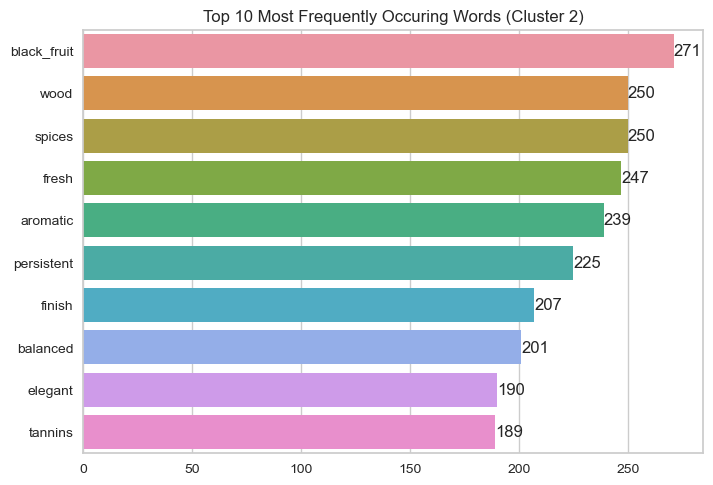

CLUSTER 3
The size of this cluster is 20 wines


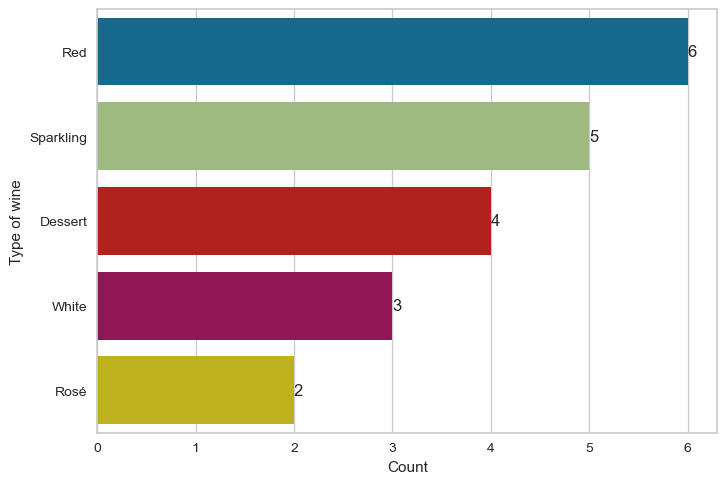

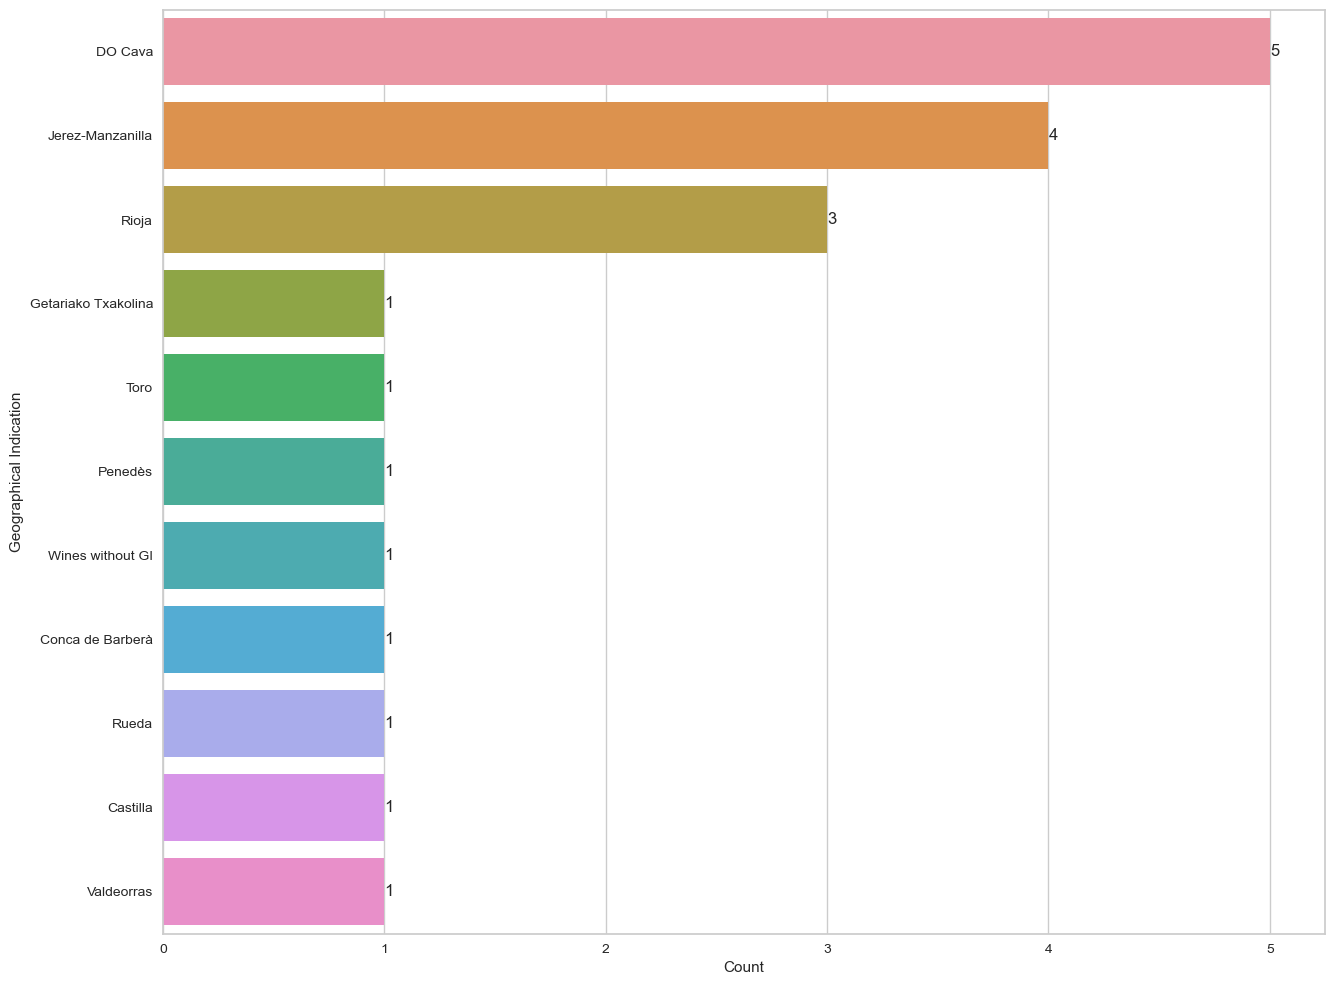

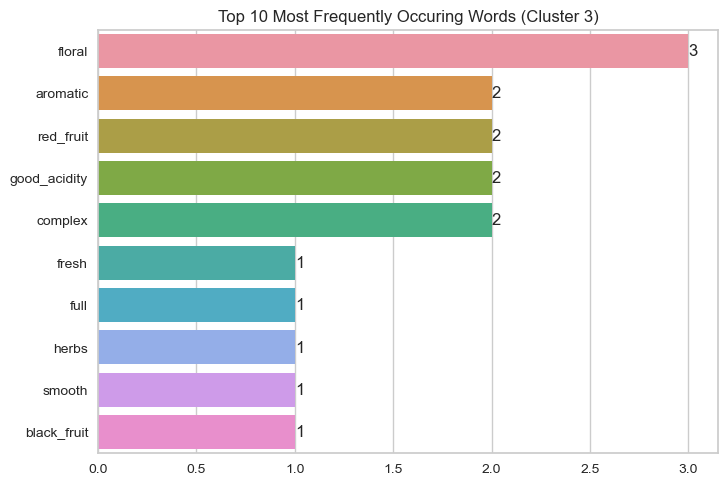

CLUSTER 4
The size of this cluster is 55 wines


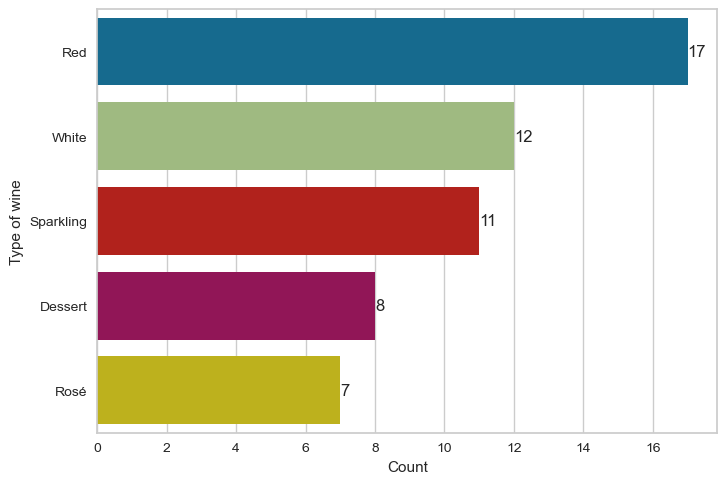

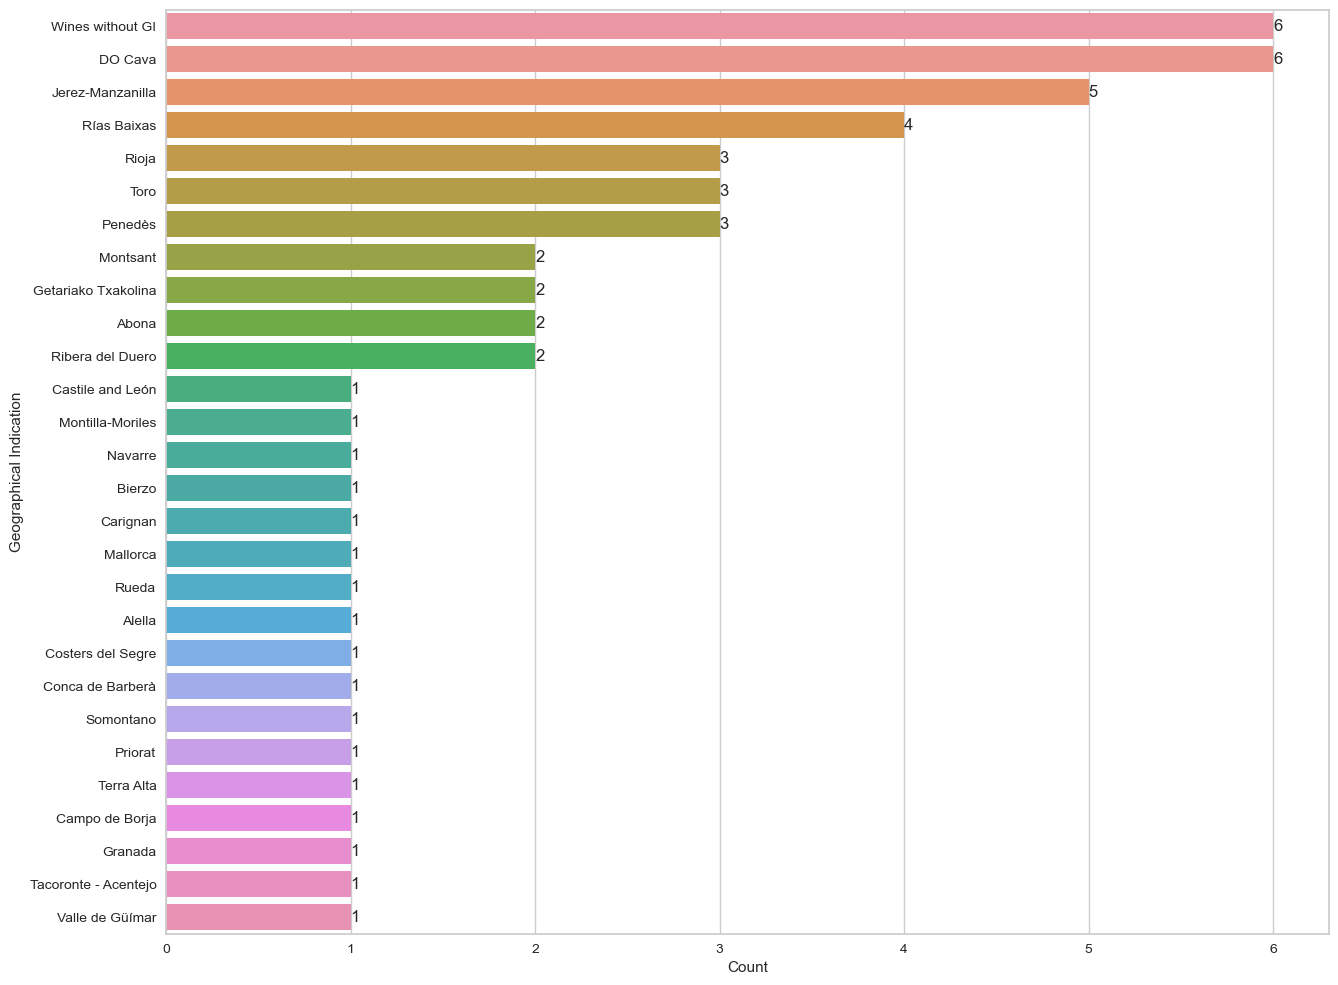

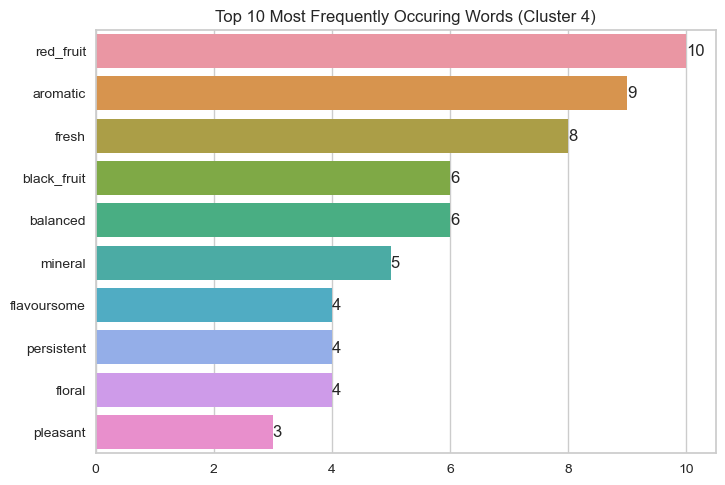

CLUSTER 5
The size of this cluster is 472 wines


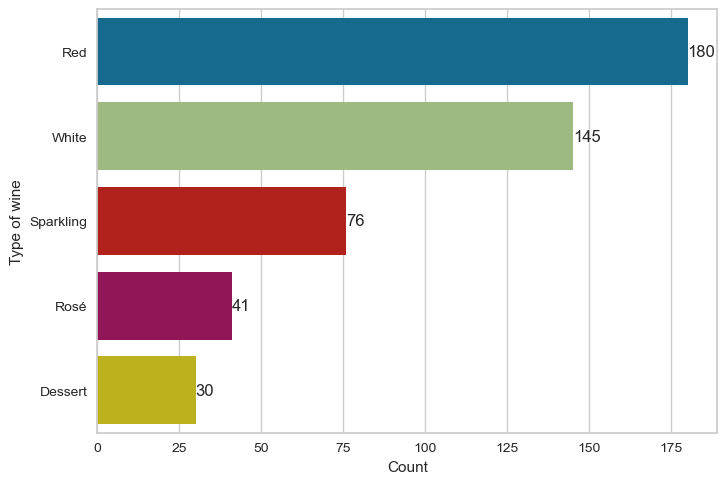

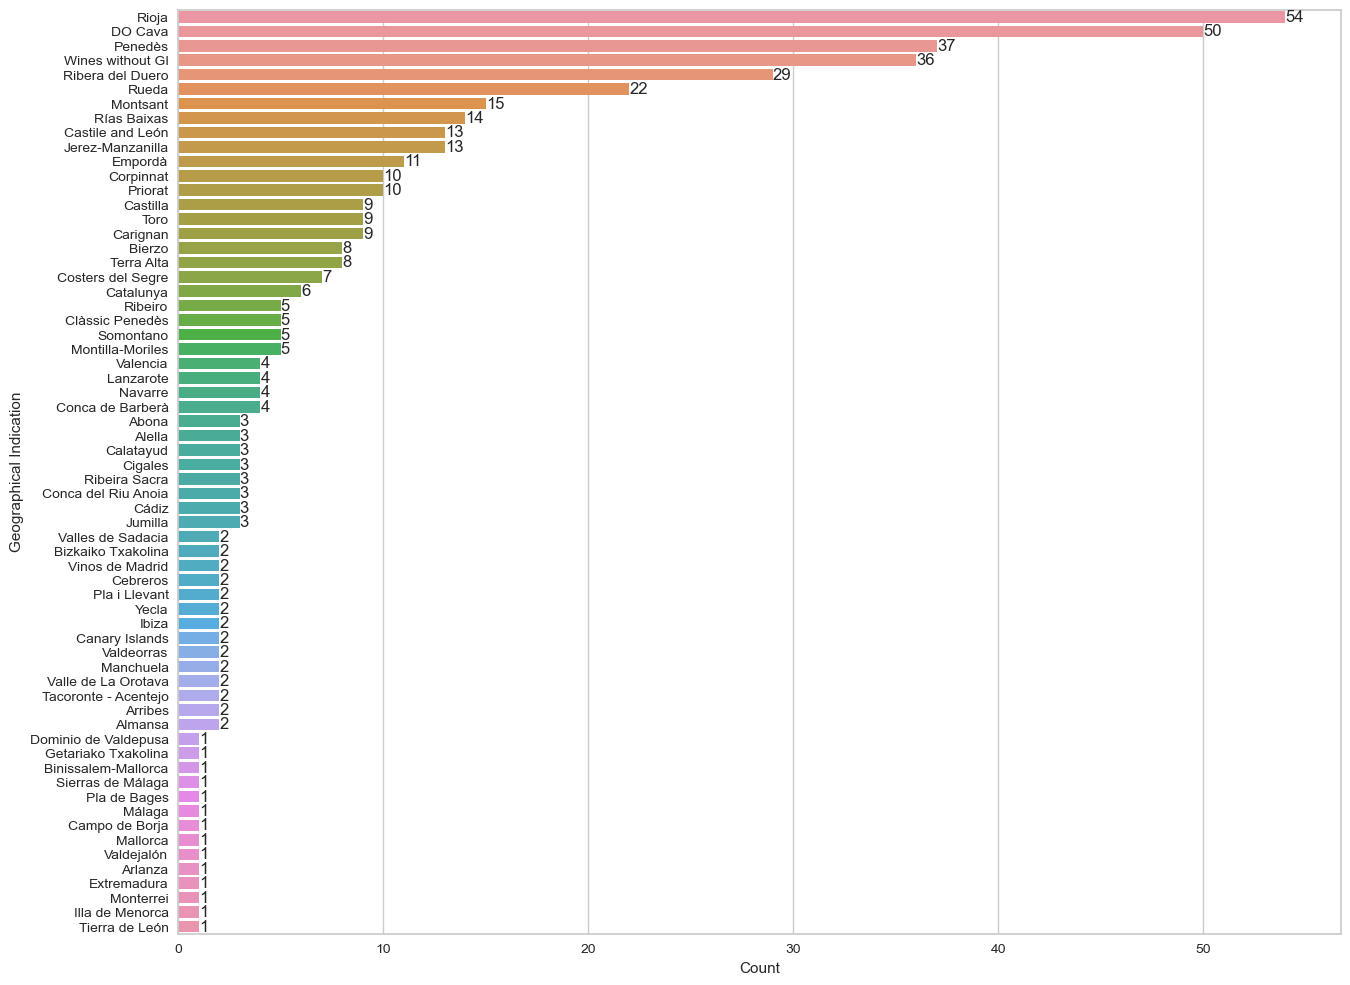

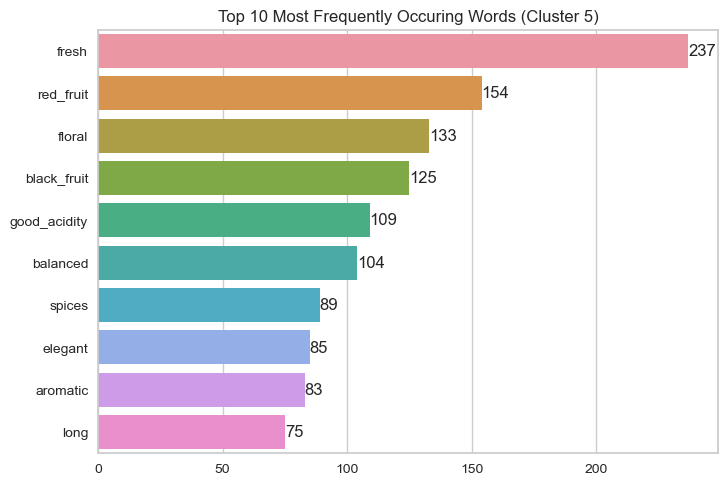

CLUSTER 6
The size of this cluster is 140 wines


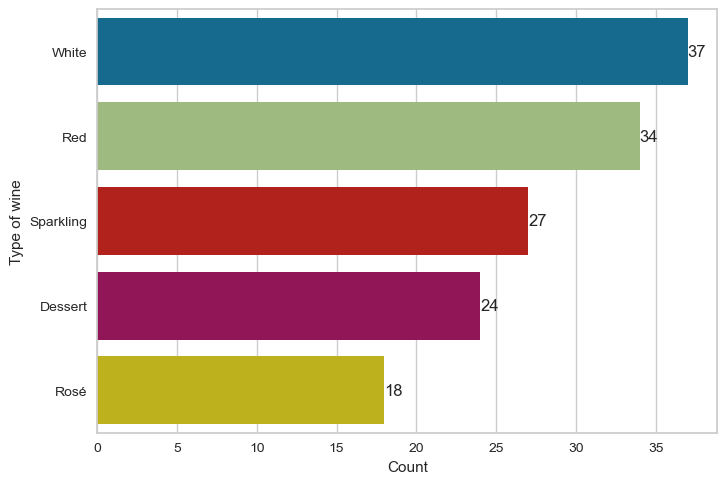

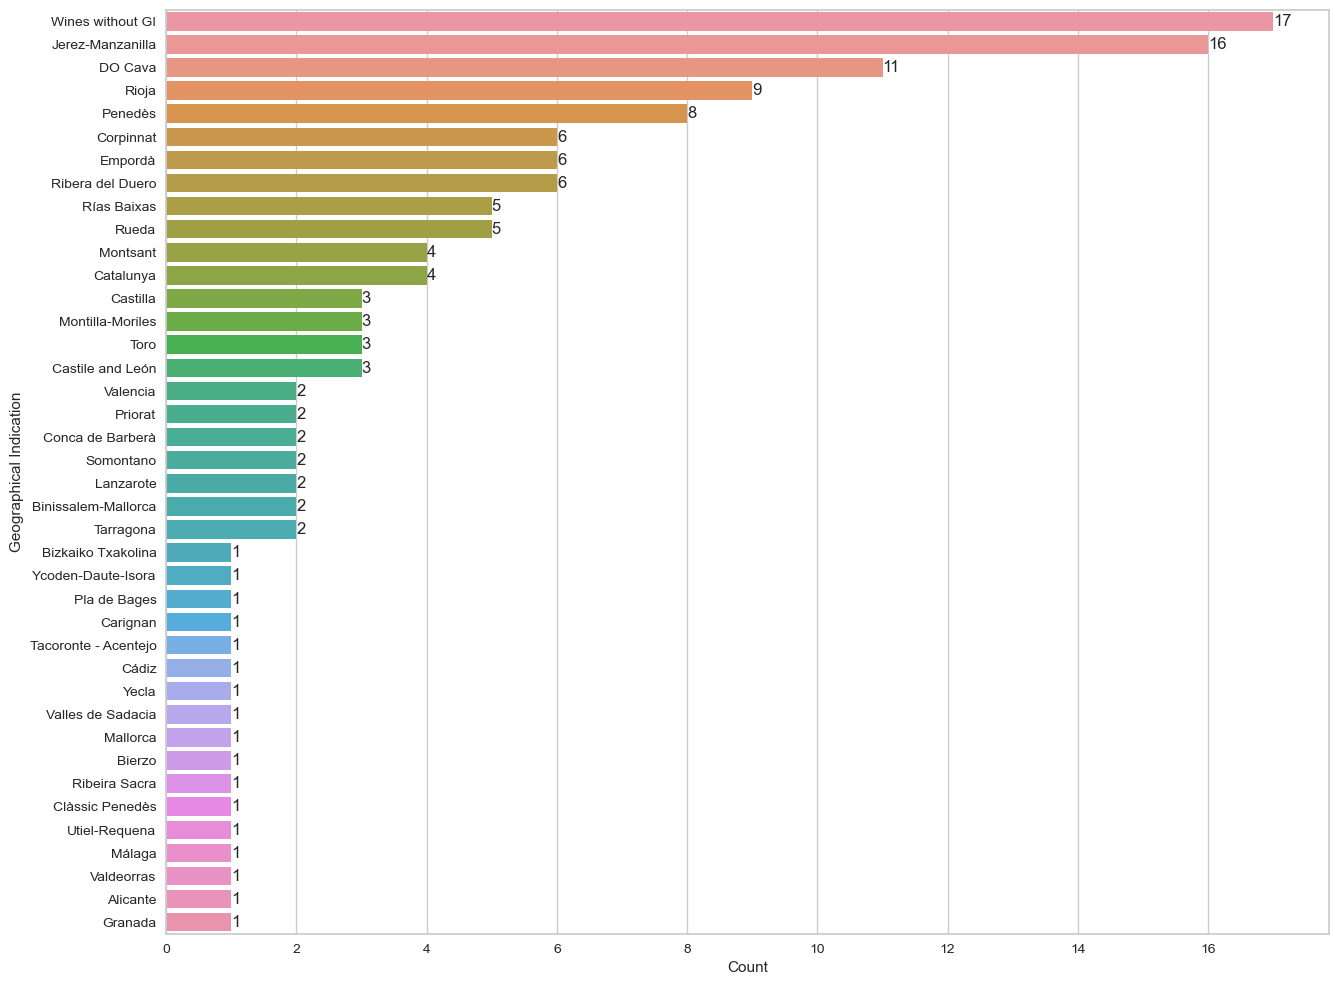

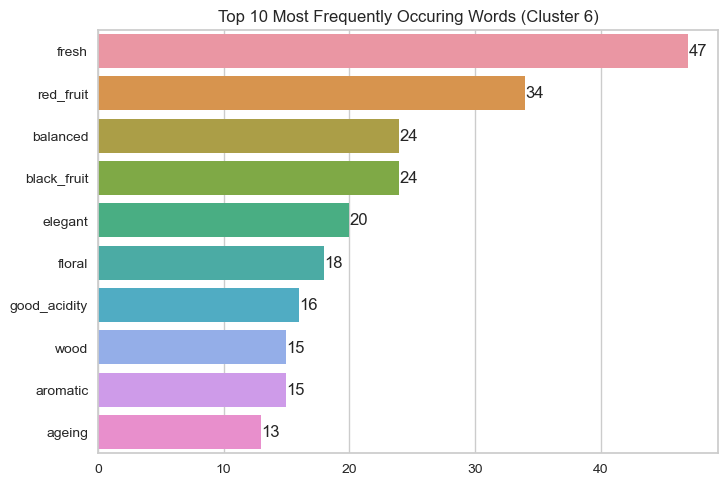

CLUSTER 7
The size of this cluster is 416 wines


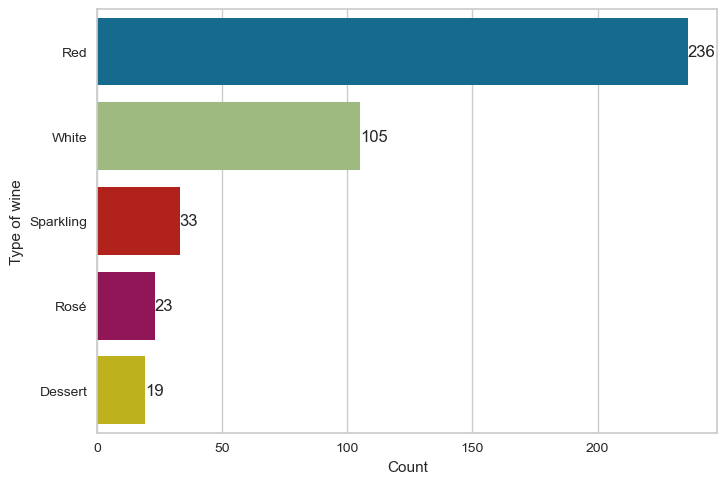

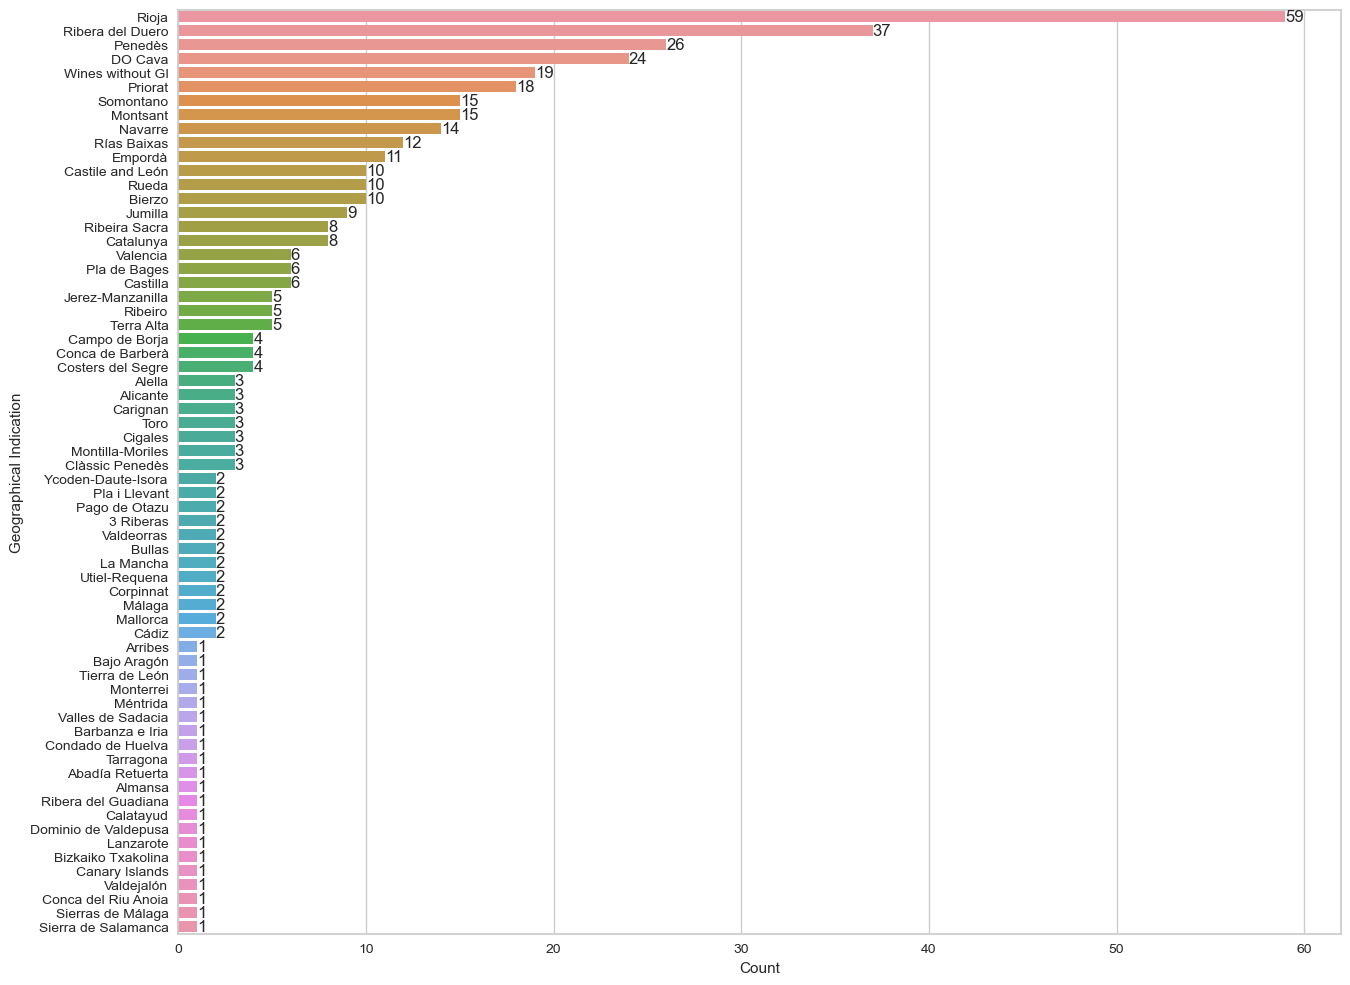

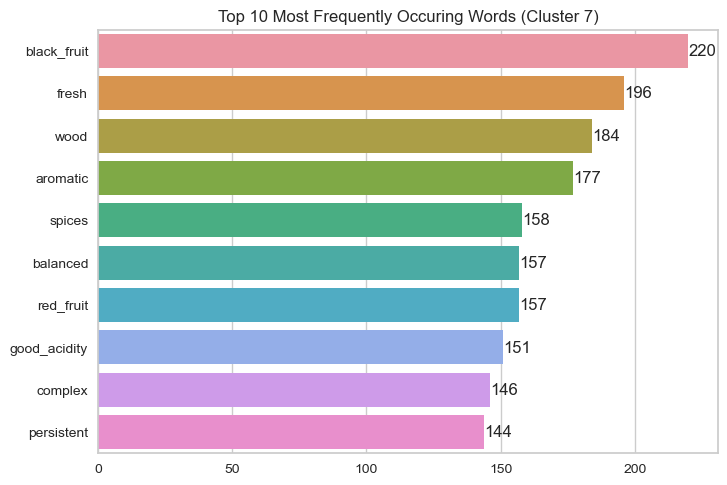

CLUSTER 8
The size of this cluster is 555 wines


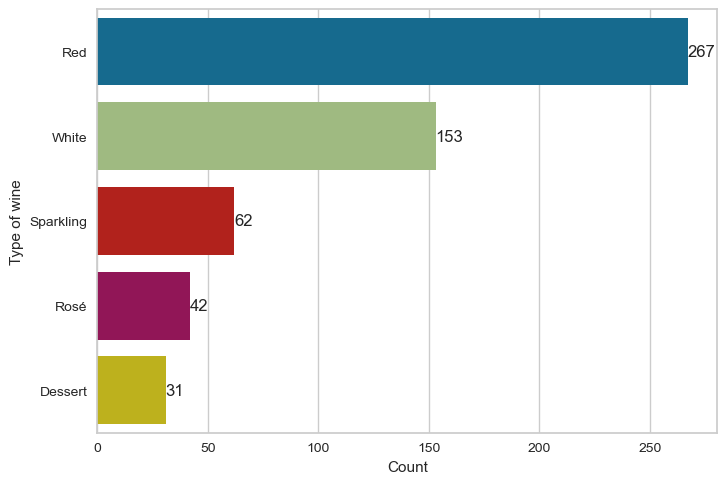

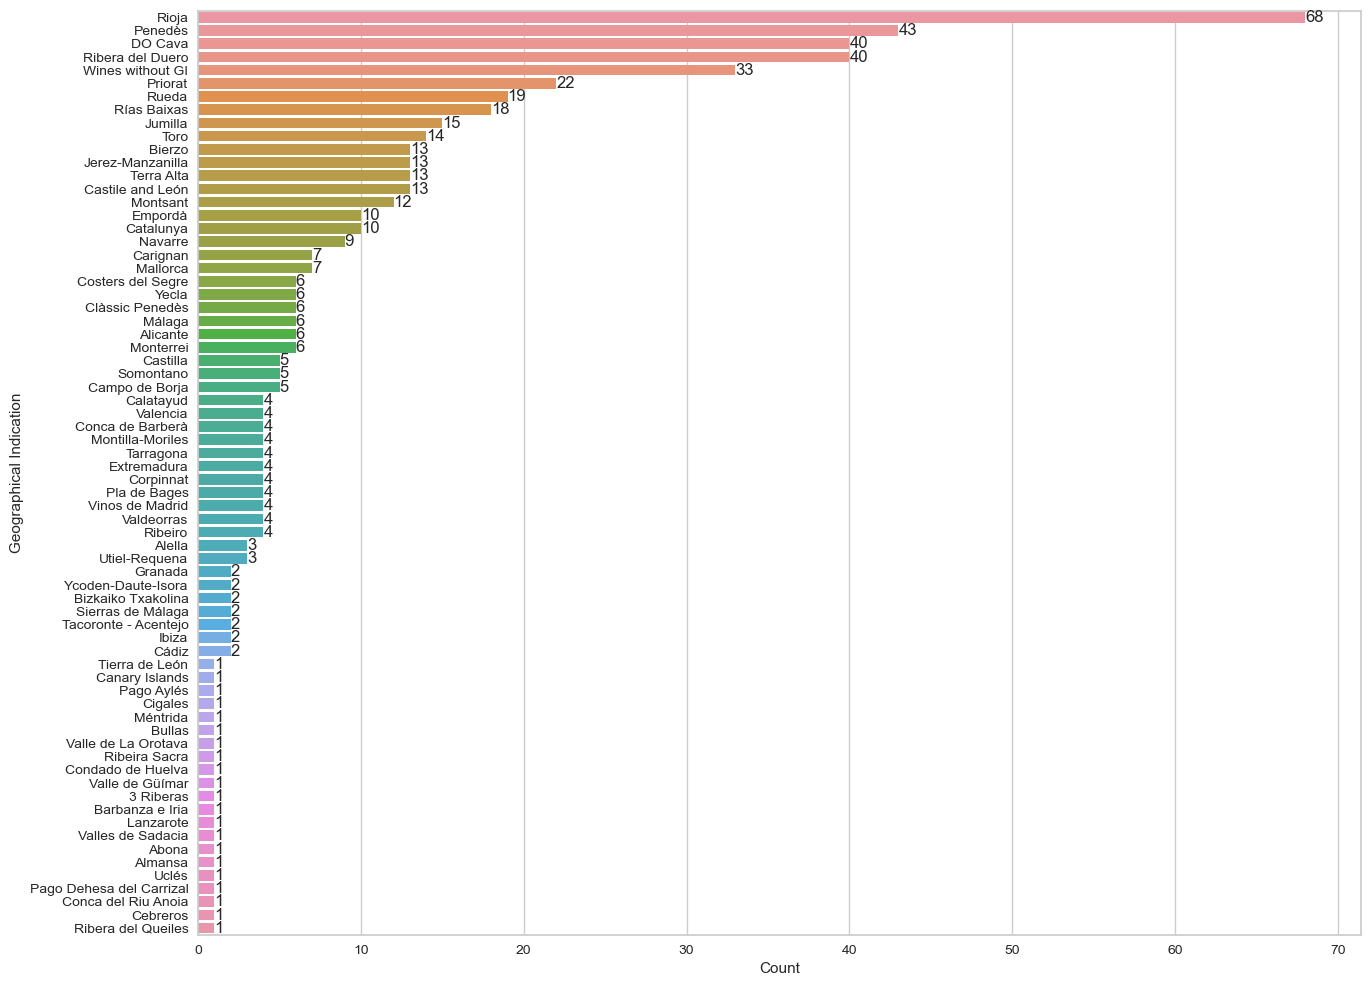

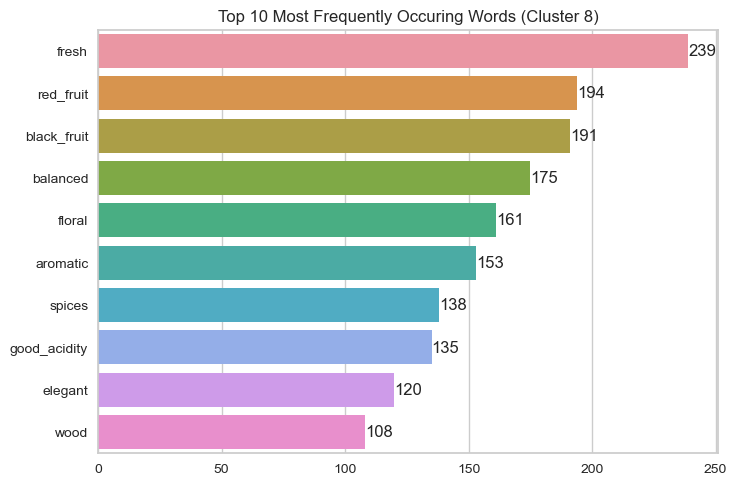

CLUSTER 9
The size of this cluster is 317 wines


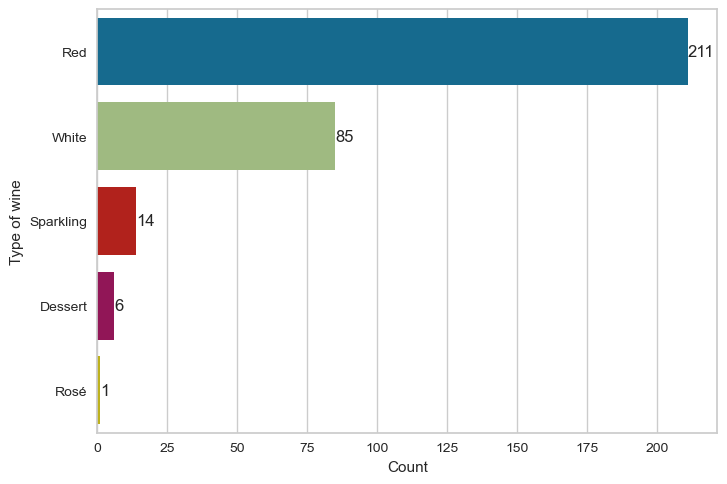

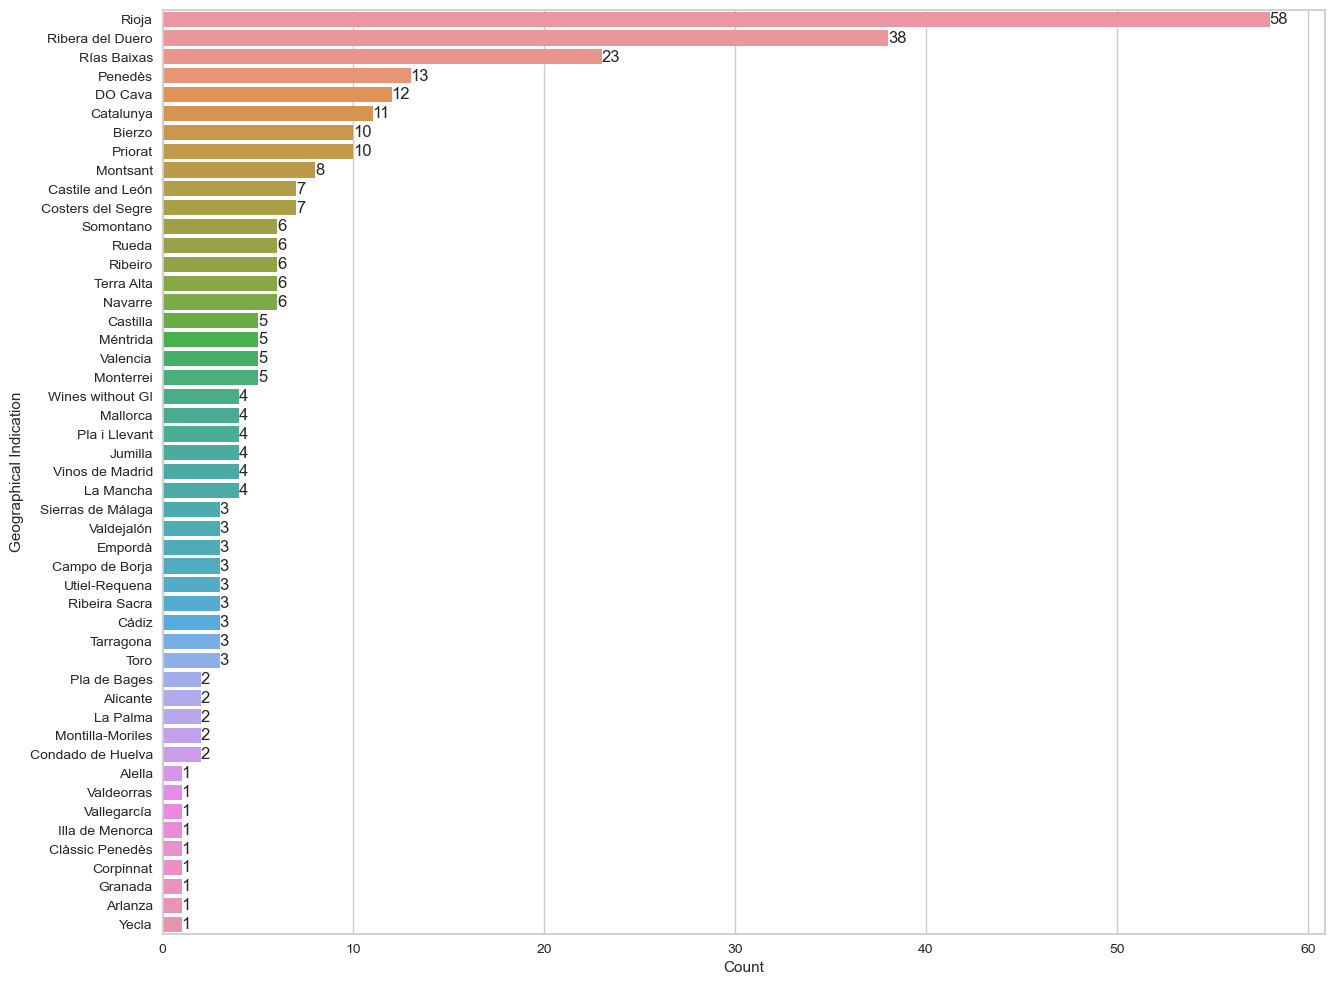

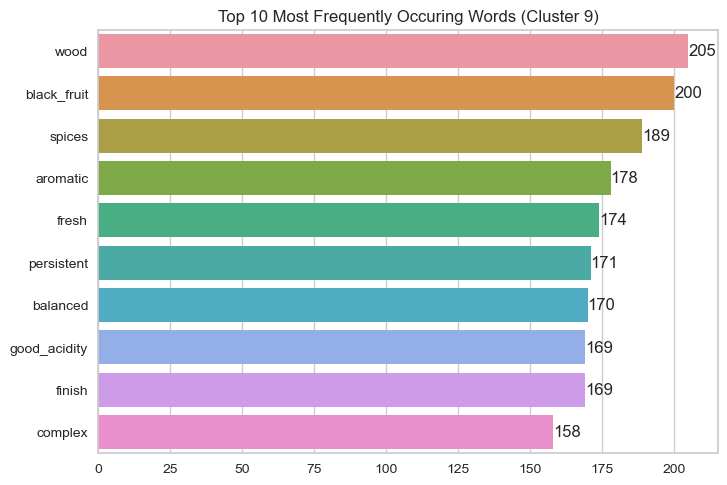

CLUSTER 10
The size of this cluster is 477 wines


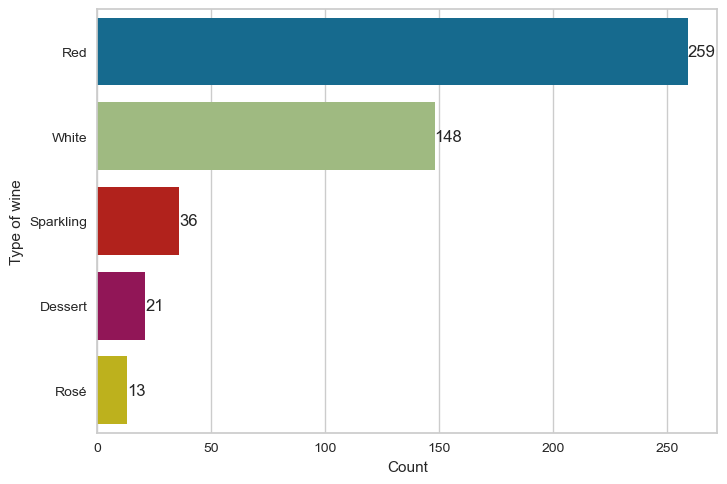

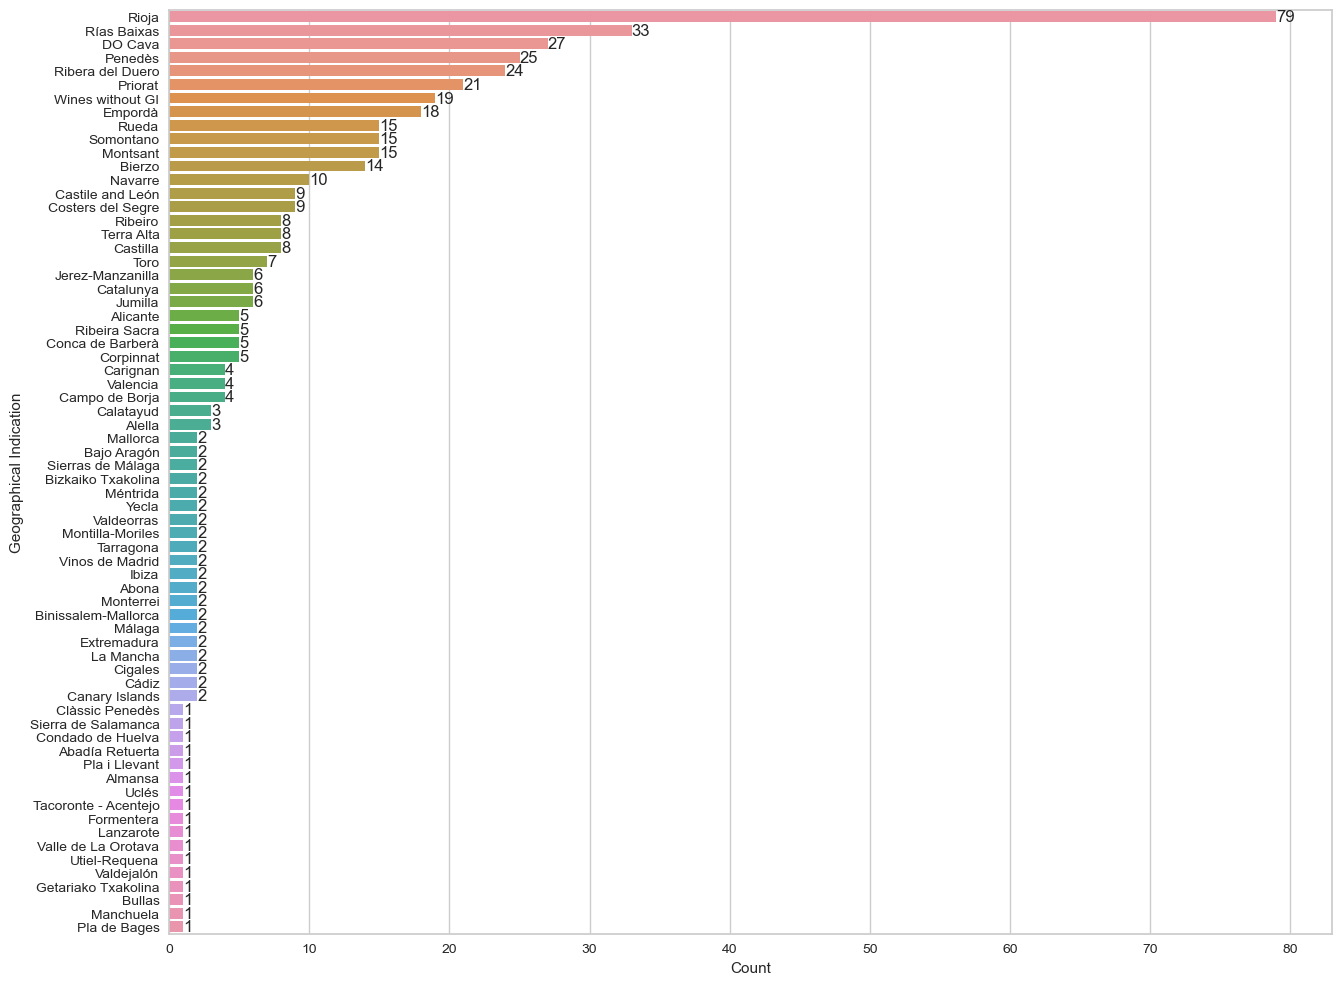

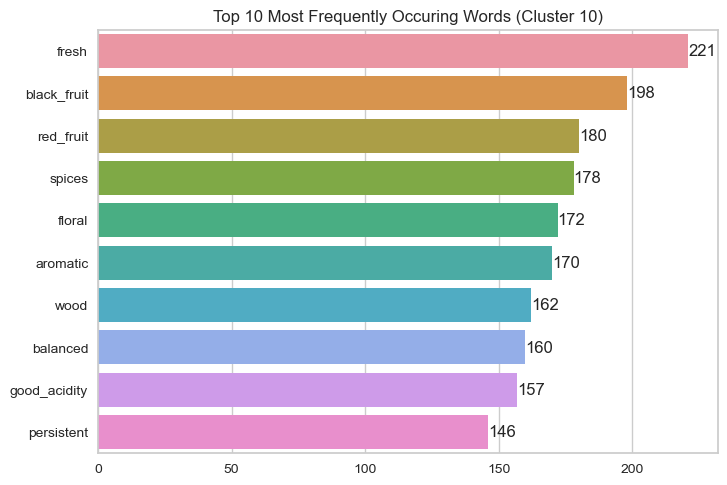

In [129]:
for cluster in range(0,11):
    explore_clusters(text_data, "notes_norm_removed_new_reduction_dropped", "cluster11", cluster)

In [130]:
text_data[text_data["cluster11"]==3]

wine    year  \
30                             Rioja Bordón Blanco 2022  2022.0   
282                            Txomin Etxaniz Rosé 2021  2021.0   
625                                    Viore Tinto 2021  2021.0   
912                              Atrium Chardonnay 2022  2022.0   
1211       Canals & Munné Dionysus Brut Nature Eco 2020  2020.0   
1391                                     Corriente 2020  2020.0   
1392                             Fino Quinta de Osborne     NaN   
1434                        Montsant Artesà Brut Nature     NaN   
1477                             Tío Pepe Fino Muy Seco     NaN   
1644                  Naterra Rosé 2020 (Bag in box 3L)     NaN   
1802        Bertha Cardús Brut Nature Gran Reserva 2018  2018.0   
2050                    Clos Montblanc Merlot Únic 2018  2018.0   
2490                 González Byass Leonor Palo Cortado     NaN   
2678  Lustau Almacenista Oloroso Pata de Gallina (0....     NaN   
2843           ADN Canals Brut Nature Gran Reserva 2014  2014.0   
3262              Martivillí Fermentado En Barrica 2018  2018.0   
3390             Tutusaus Gran Reserva Brut Nature 2017  2017.0   
3400                     Hello World Prieto Picudo 2017  2017.0   
3548                                        Tineta 2012  2012.0   
3690                     Lar de Paula Cepas Viejas 2005  2005.0   

                                    winery  price  bottle  type_wine  \
30                Bodegas Franco Españolas   9.95    0.75      White   
282                         Txomin Etxaniz  16.20    0.75       Rosé   
625                       Bodegas Riojanas   9.60    0.75        Red   
912               Propiedad Bodegas Torres  14.60    0.75      White   
1211                        Canals & Munné  14.60    0.75  Sparkling   
1391  Compañía de Vinos de Telmo Rodríguez  14.00    0.75        Red   
1392                               Osborne  12.00    0.75    Dessert   
1434                       Caves Monastell  11.80    0.75  Sparkling   
1477                        González Byass  12.00    0.75    Dessert   
1644                       Maison Ginestet  29.20    3.00       Rosé   
1802                           Cava Bertha  21.00    0.75  Sparkling   
2050                        Clos Montblanc  14.60    0.75        Red   
2490                        González Byass  35.20     NaN    Dessert   
2678                         Emilio Lustau  23.15    0.50    Dessert   
2843                        Canals & Munné  18.40    0.75  Sparkling   
3262                 Angel Lorenzo Cachazo  15.20    0.75      White   
3390                            Valldolina  16.50    0.75  Sparkling   
3400                     Finca La Estacada   9.50    0.75        Red   
3548                       Bodegas Ordóñez  14.90    0.75        Red   
3690                          Lar de Paula  25.55     NaN        Red   

        type_wine_details type_agriculture              region  \
30                  White     Conventional            La Rioja   
282                  Rosé     Conventional             Euskadi   
625                   Red     Conventional     Castilla y León   
912                 White          Organic            Cataluña   
1211                 Cava          Organic            Cataluña   
1391                  Red          Organic            La Rioja   
1392          Fino sherry     Conventional           Andalucía   
1434                 Cava     Conventional            Cataluña   
1477          Fino sherry     Conventional           Andalucía   
1644                 Rosé          Organic    Wines without GI   
1802                 Cava     Conventional            Cataluña   
2050                  Red     Conventional            Cataluña   
2490  Palo Cortado sherry     Conventional           Andalucía   
2678       Oloroso sherry     Conventional           Andalucía   
2843                 Cava     Conventional            Cataluña   
3262                White     Conventional     Castilla y León   
3390    

### K=13

In [131]:
text_data["cluster13"].value_counts()

8     593
5     555
10    477
3     472
0     416
11    290
1     279
12    233
9     202
7     140
6      84
2      55
4      20
Name: cluster13, dtype: int64

CLUSTER 0
The size of this cluster is 416 wines


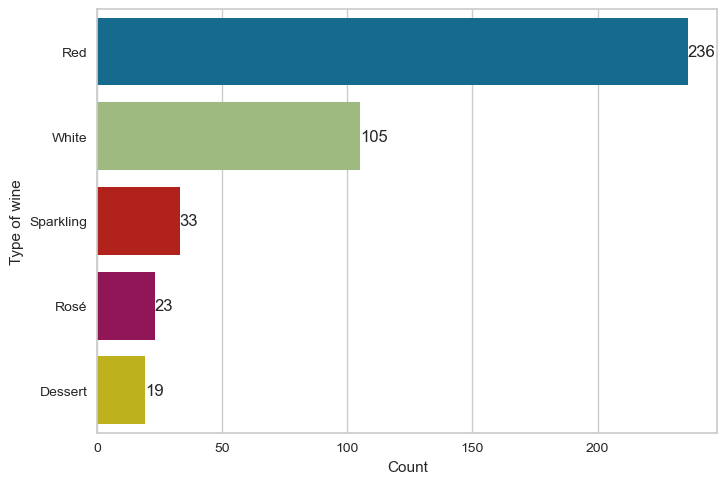

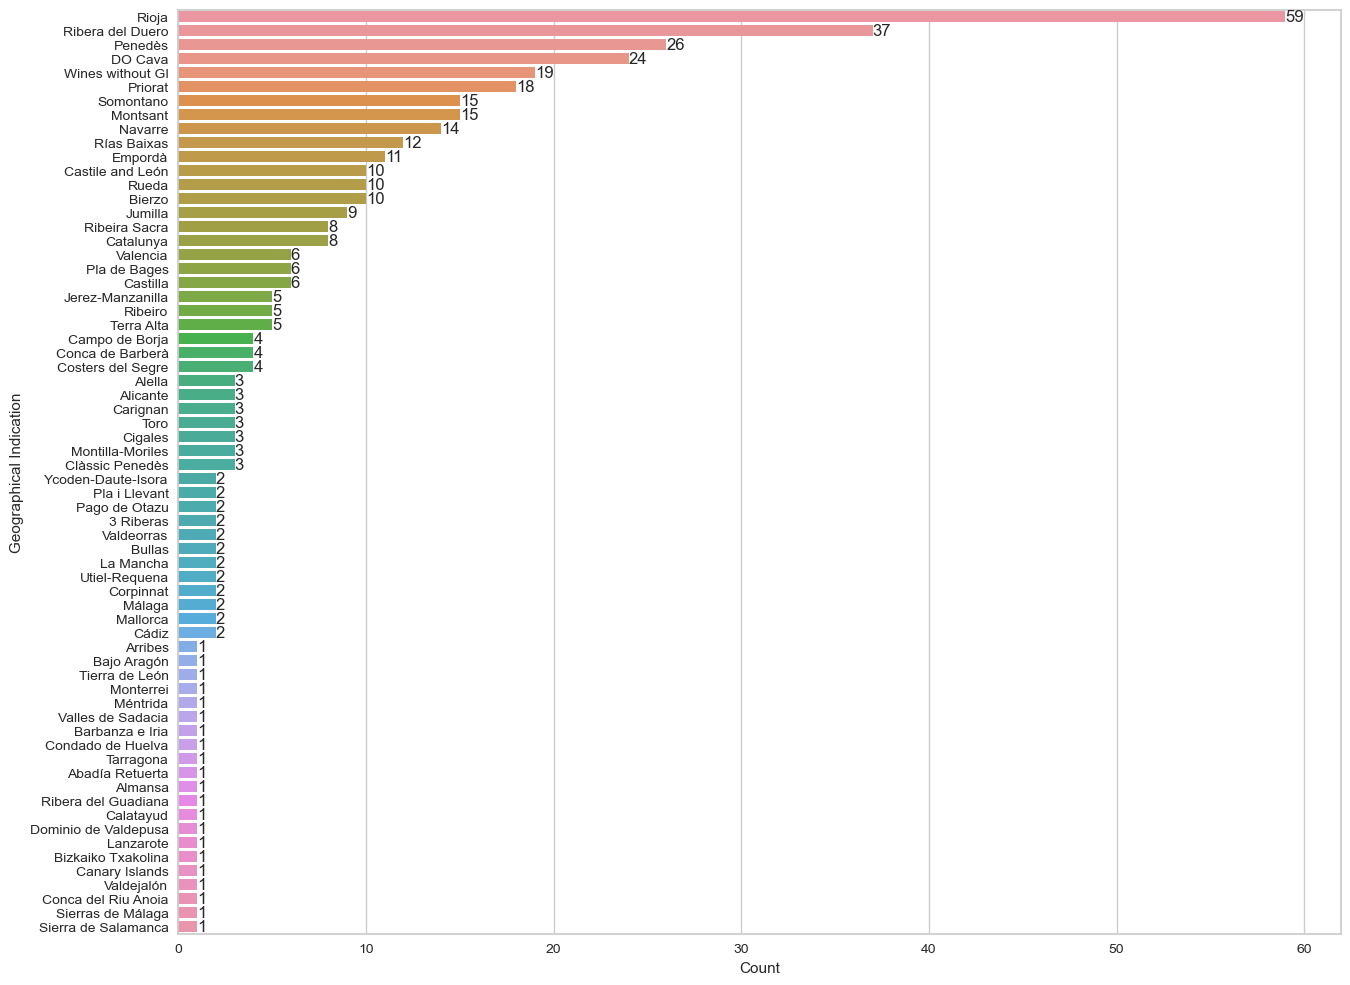

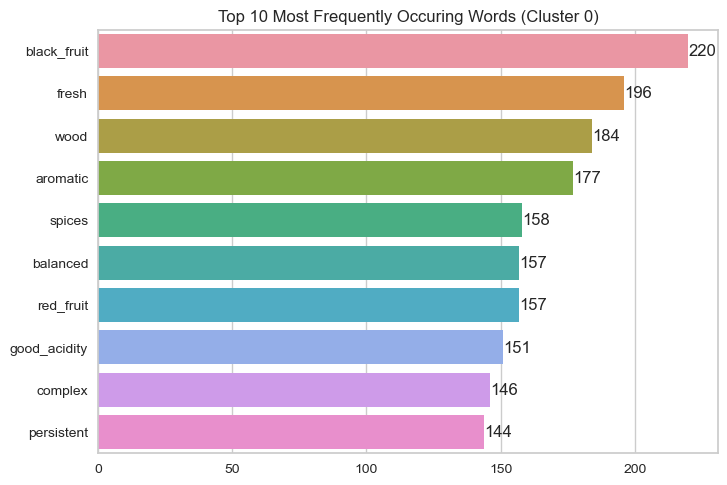

CLUSTER 1
The size of this cluster is 279 wines


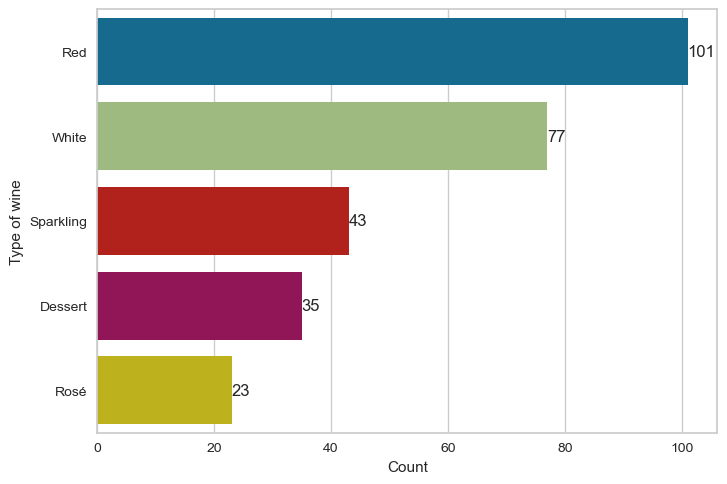

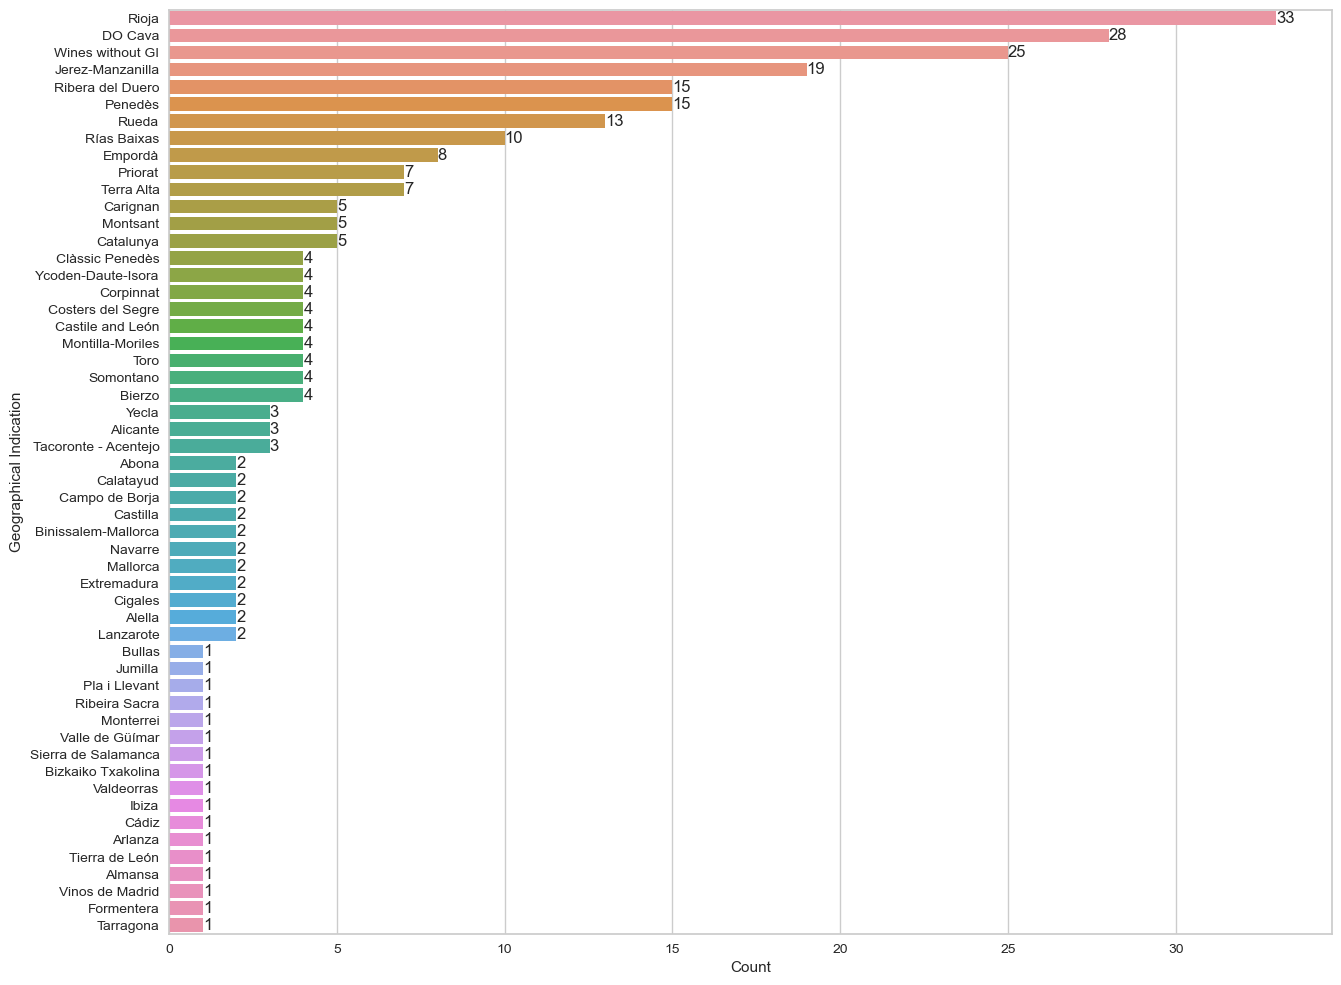

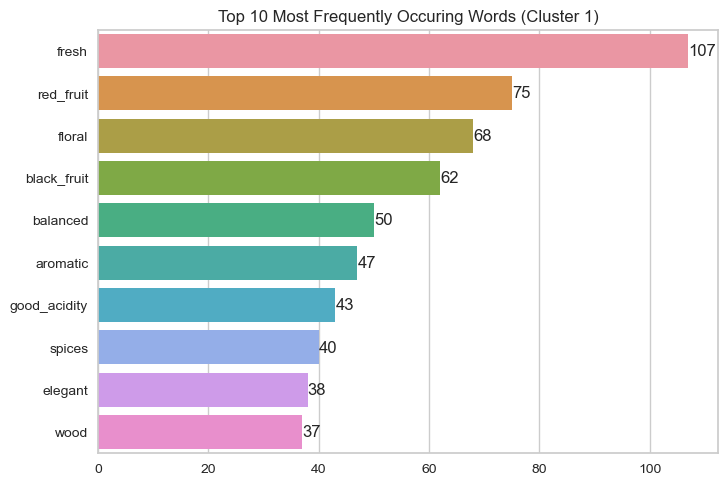

CLUSTER 2
The size of this cluster is 55 wines


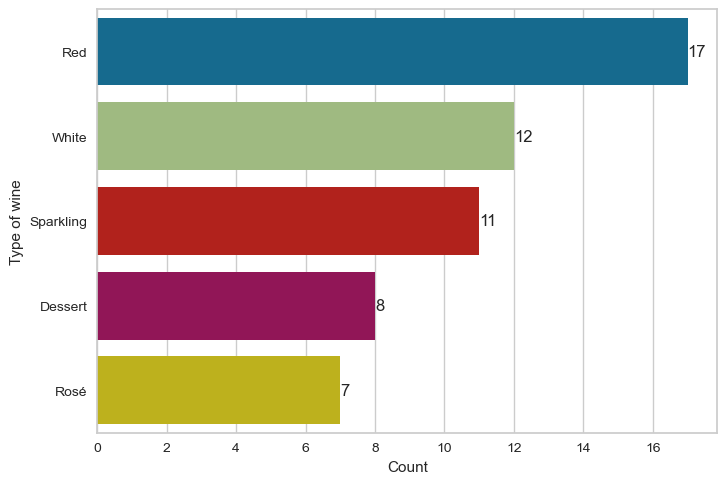

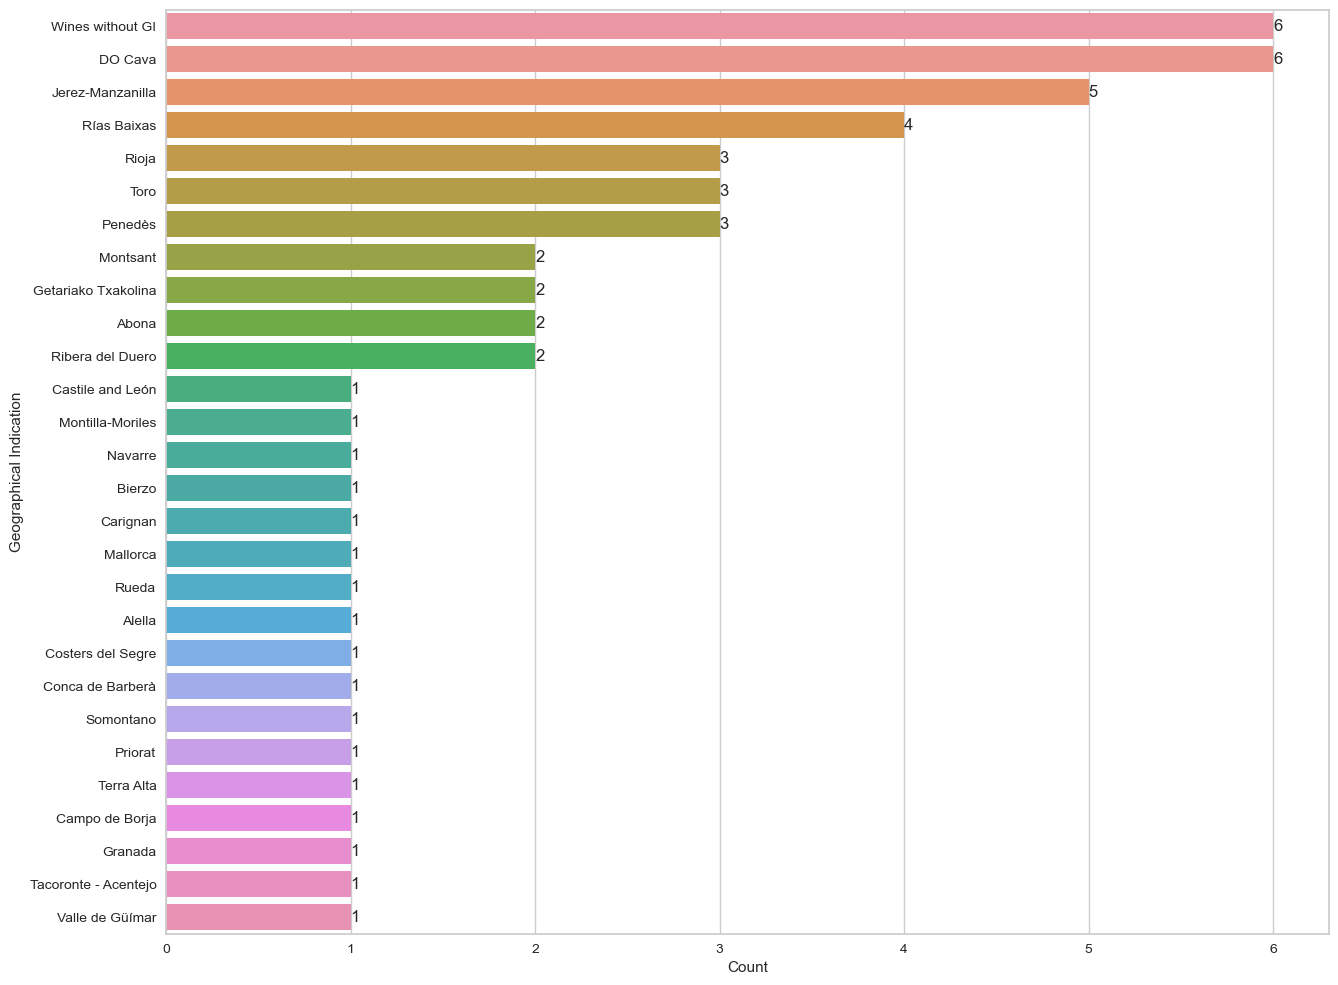

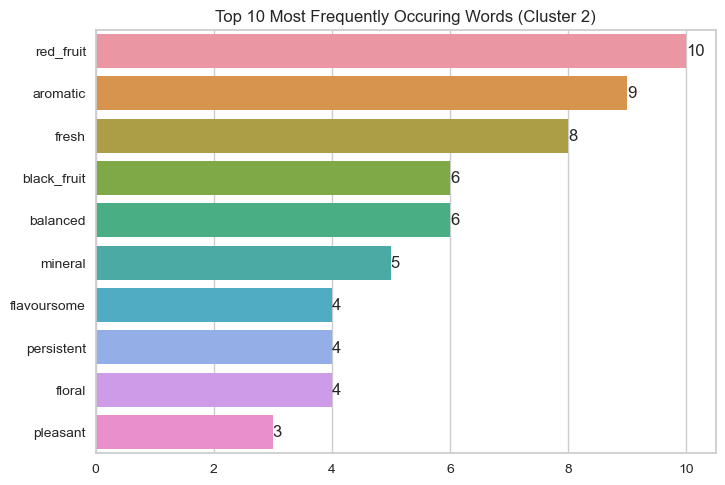

CLUSTER 3
The size of this cluster is 472 wines


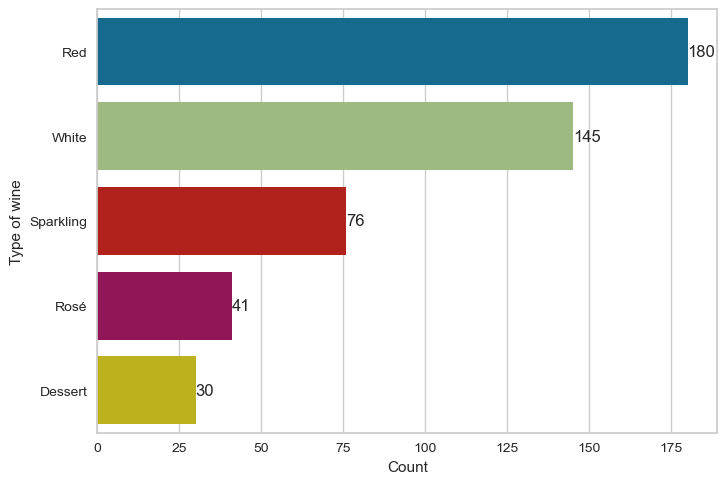

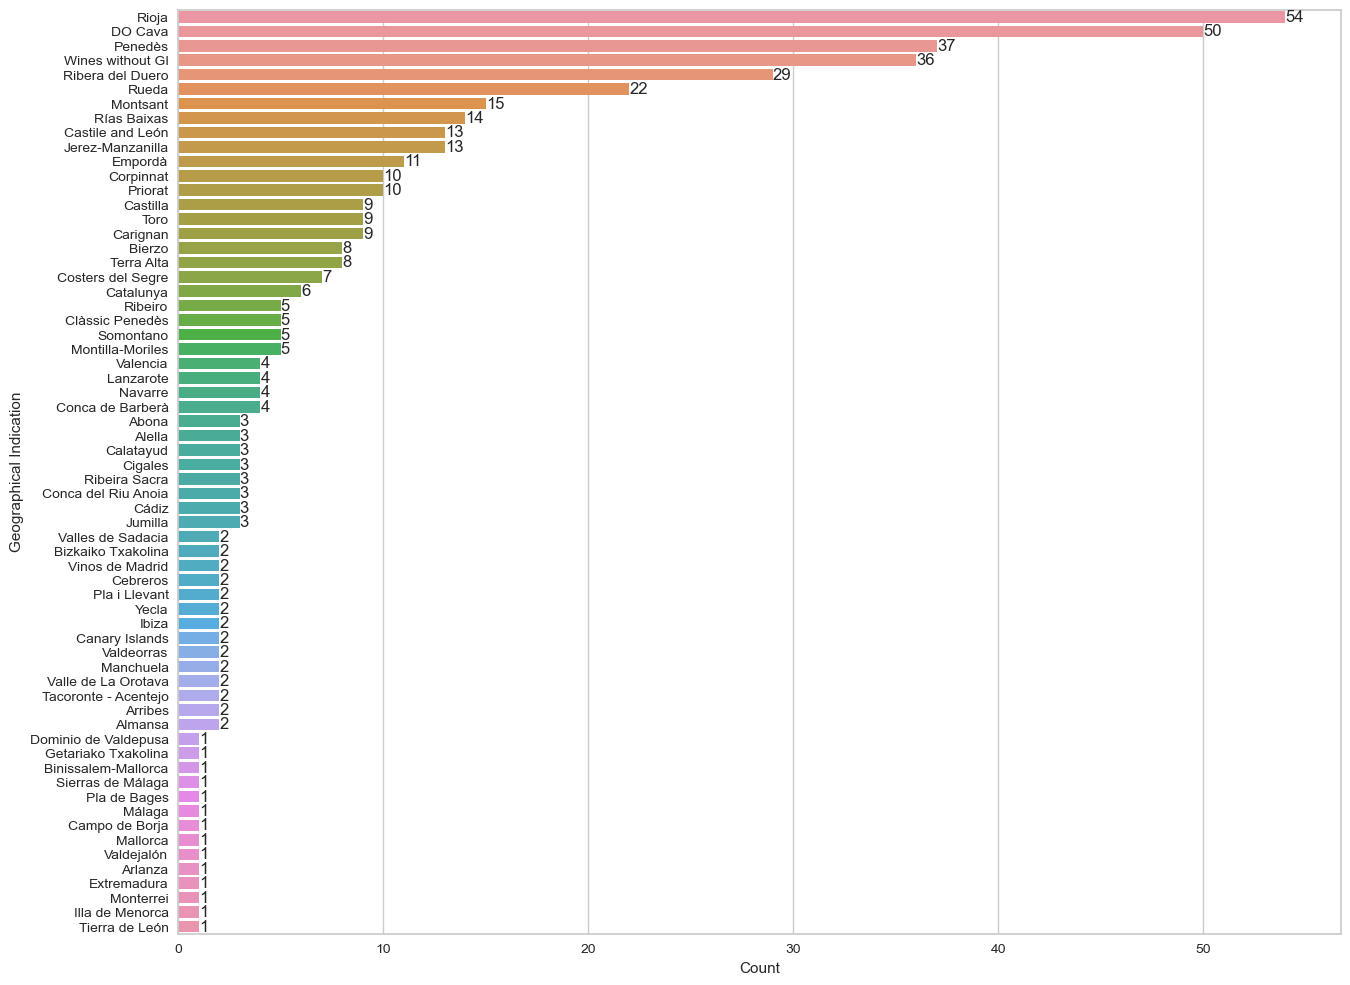

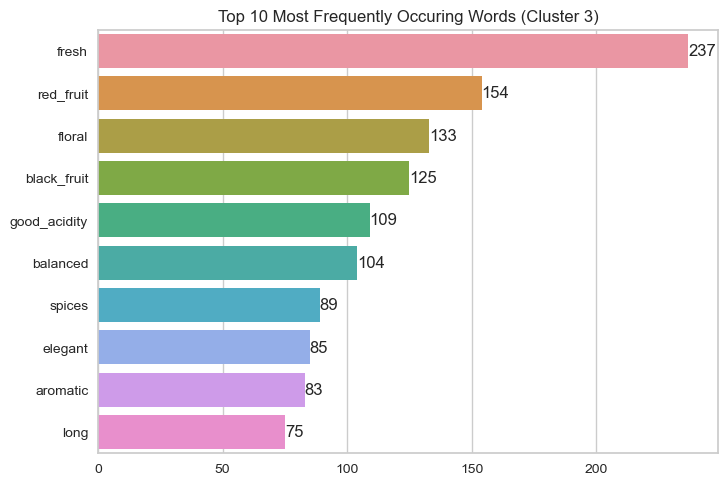

CLUSTER 4
The size of this cluster is 20 wines


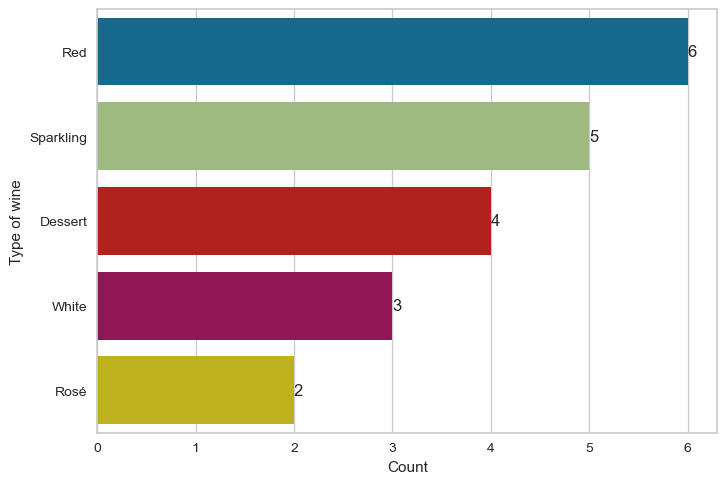

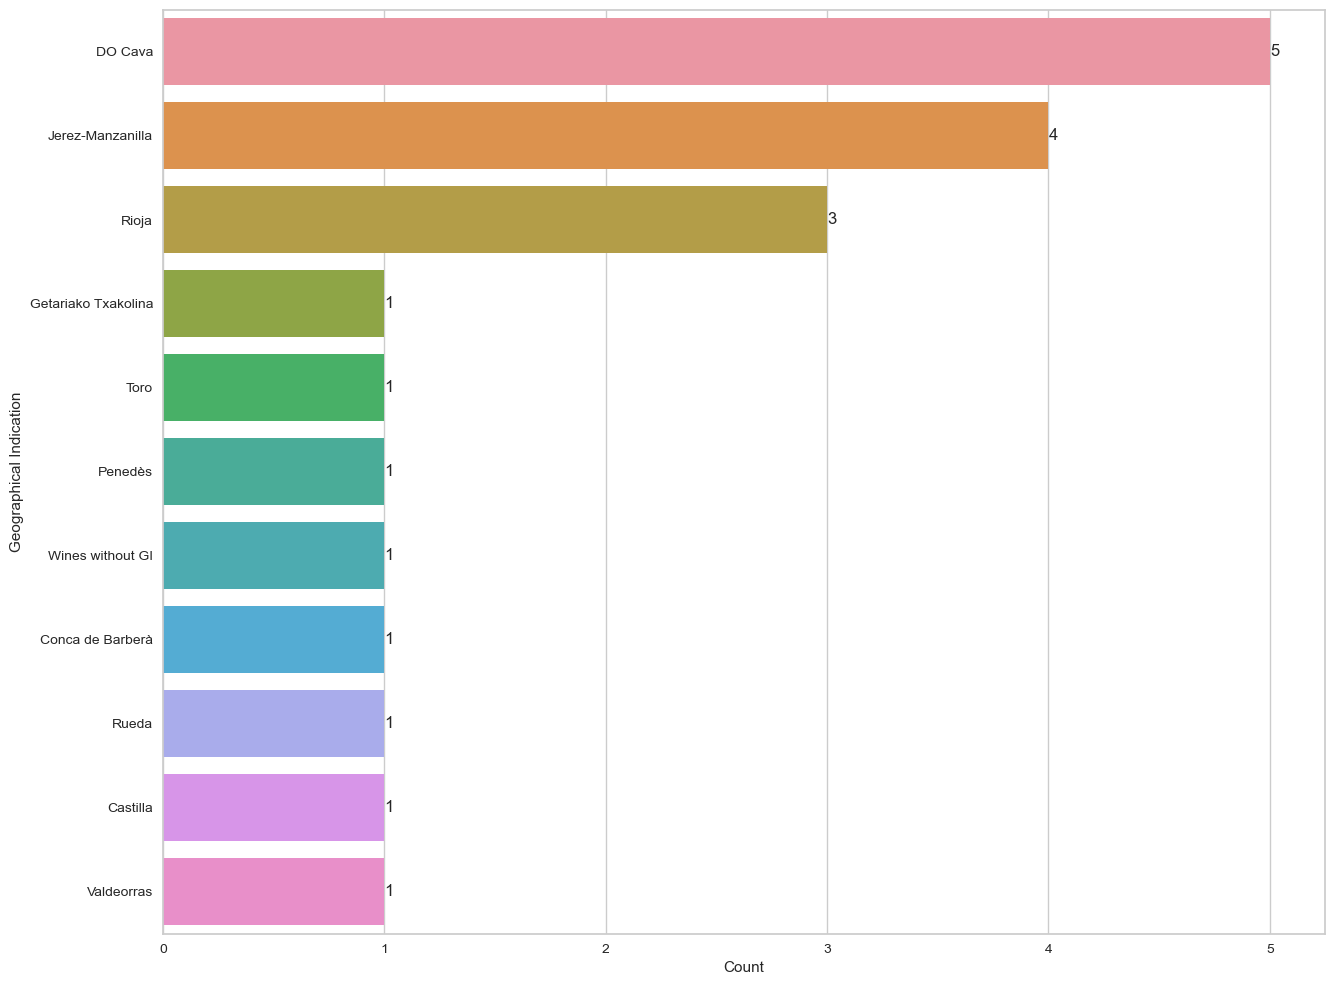

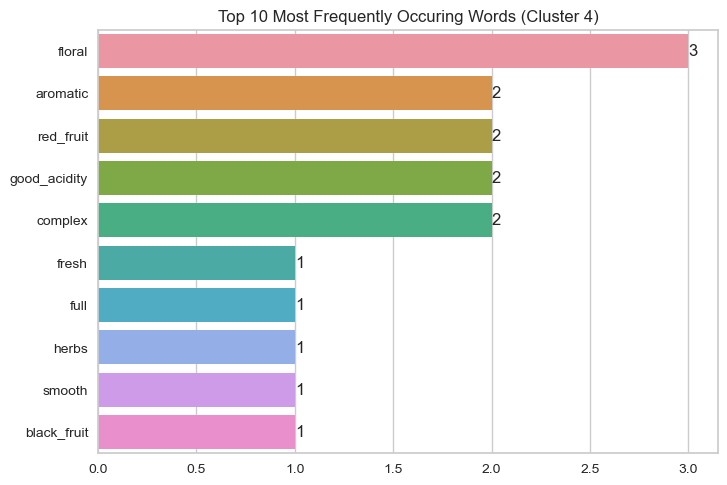

CLUSTER 5
The size of this cluster is 555 wines


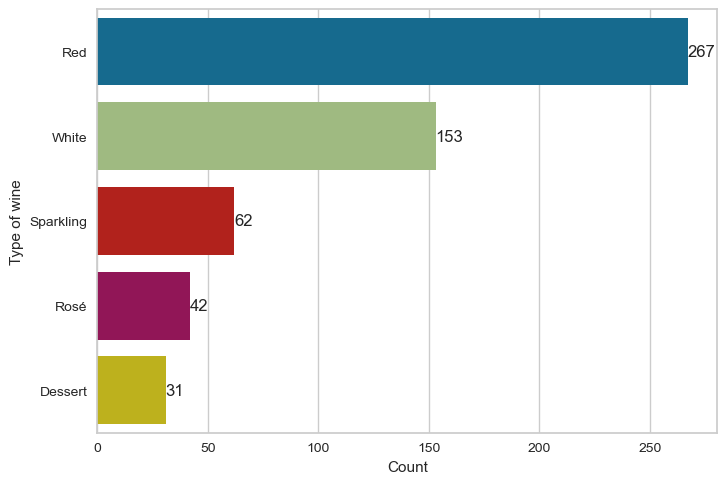

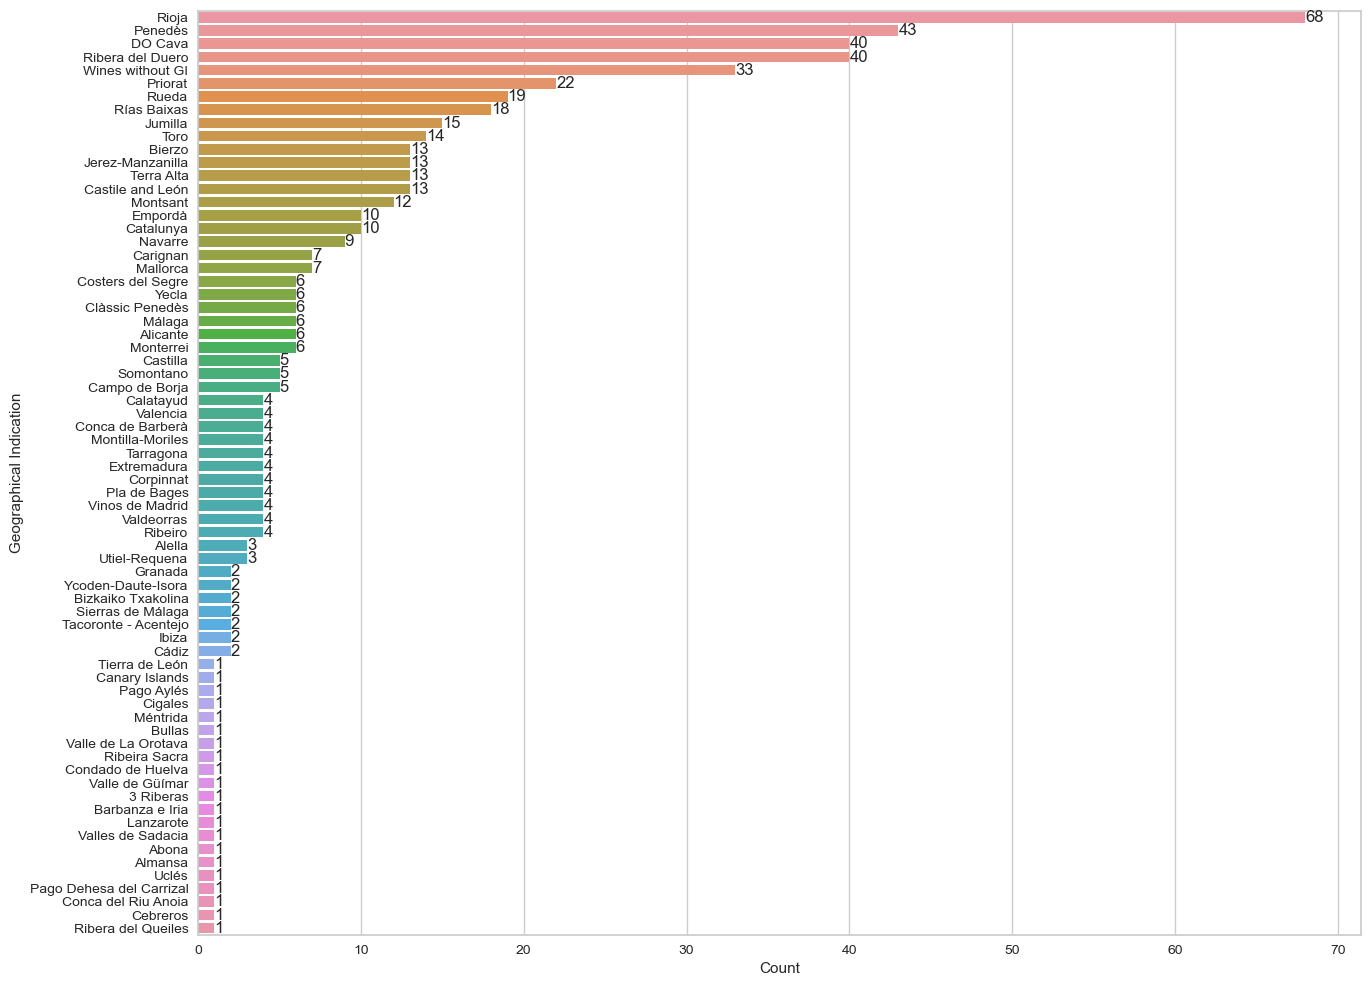

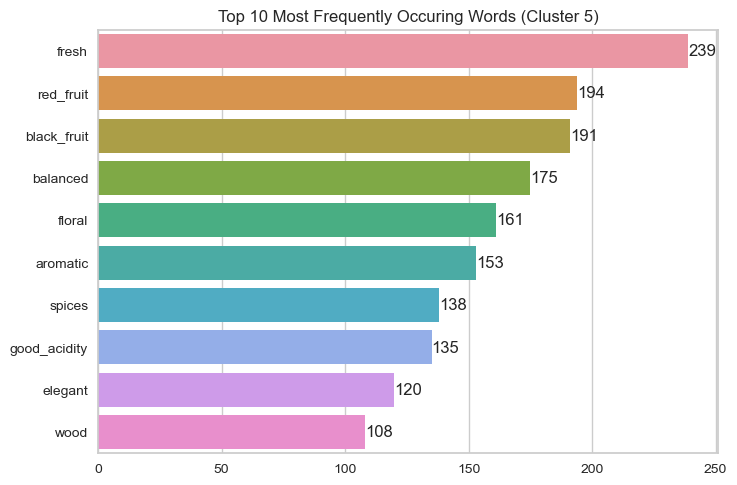

CLUSTER 6
The size of this cluster is 84 wines


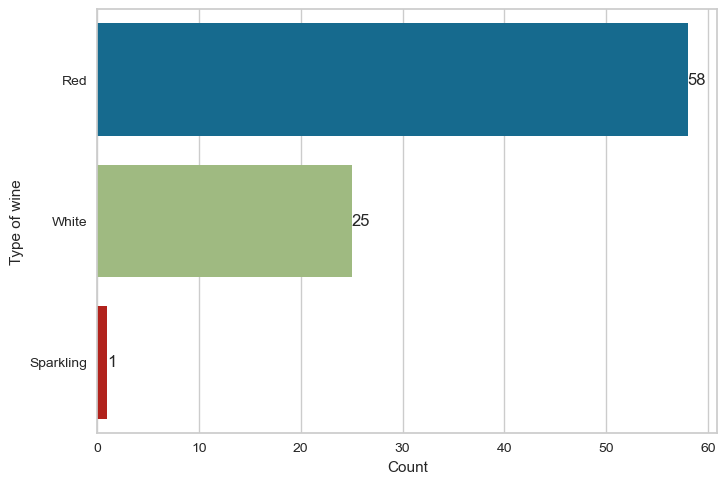

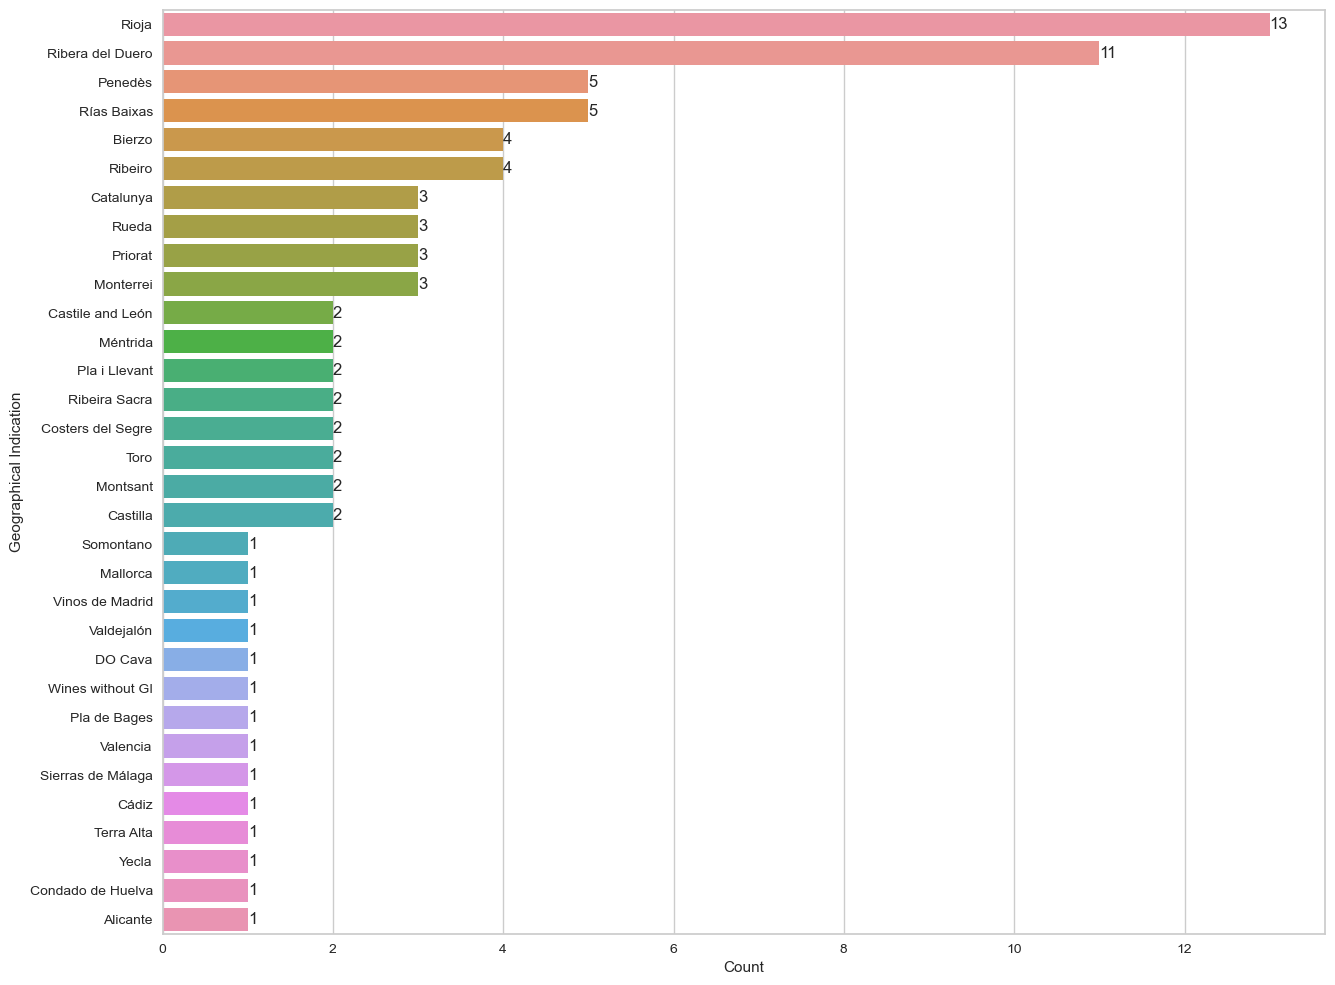

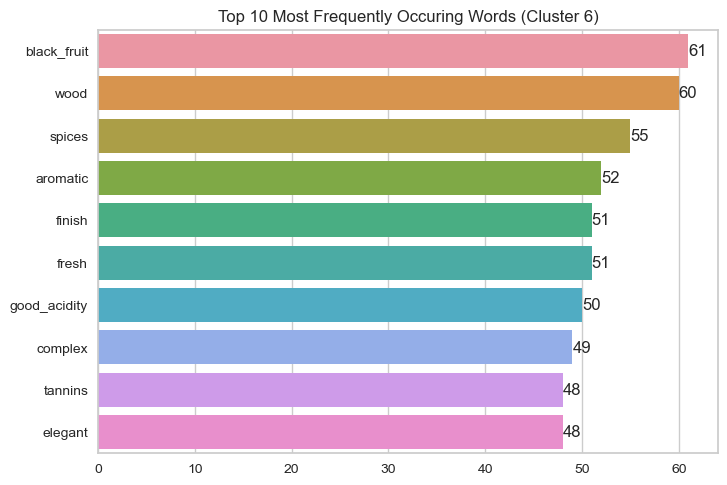

CLUSTER 7
The size of this cluster is 140 wines


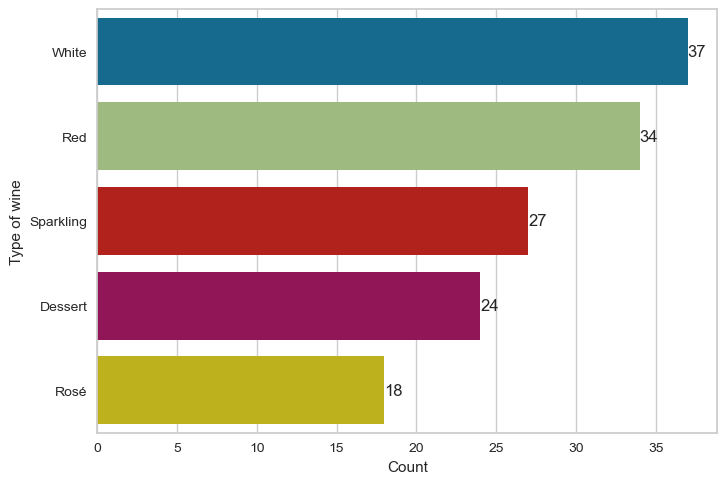

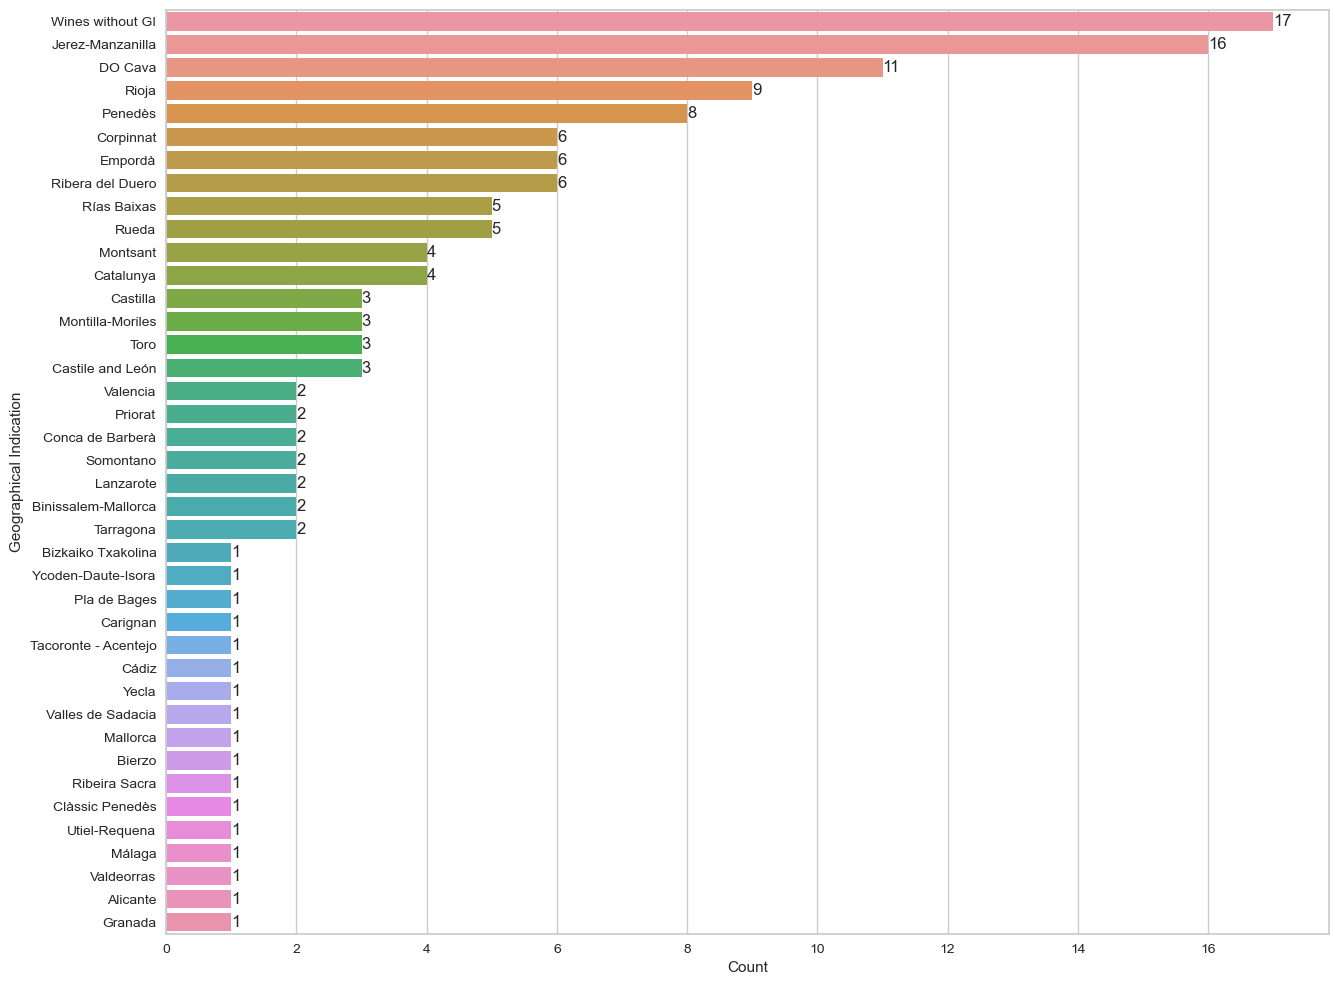

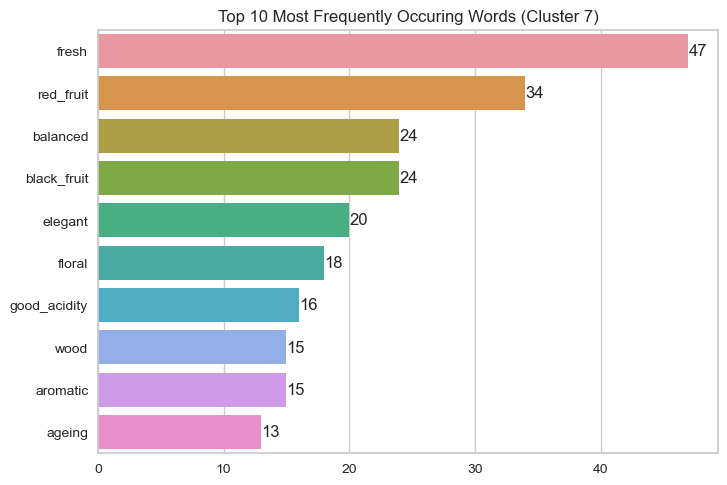

CLUSTER 8
The size of this cluster is 593 wines


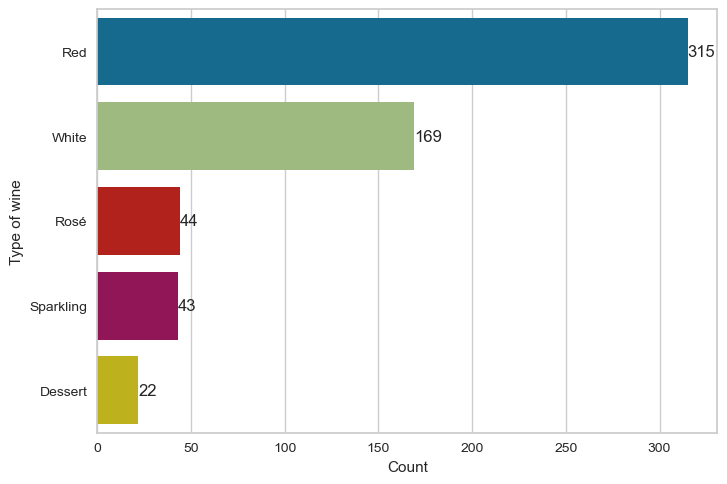

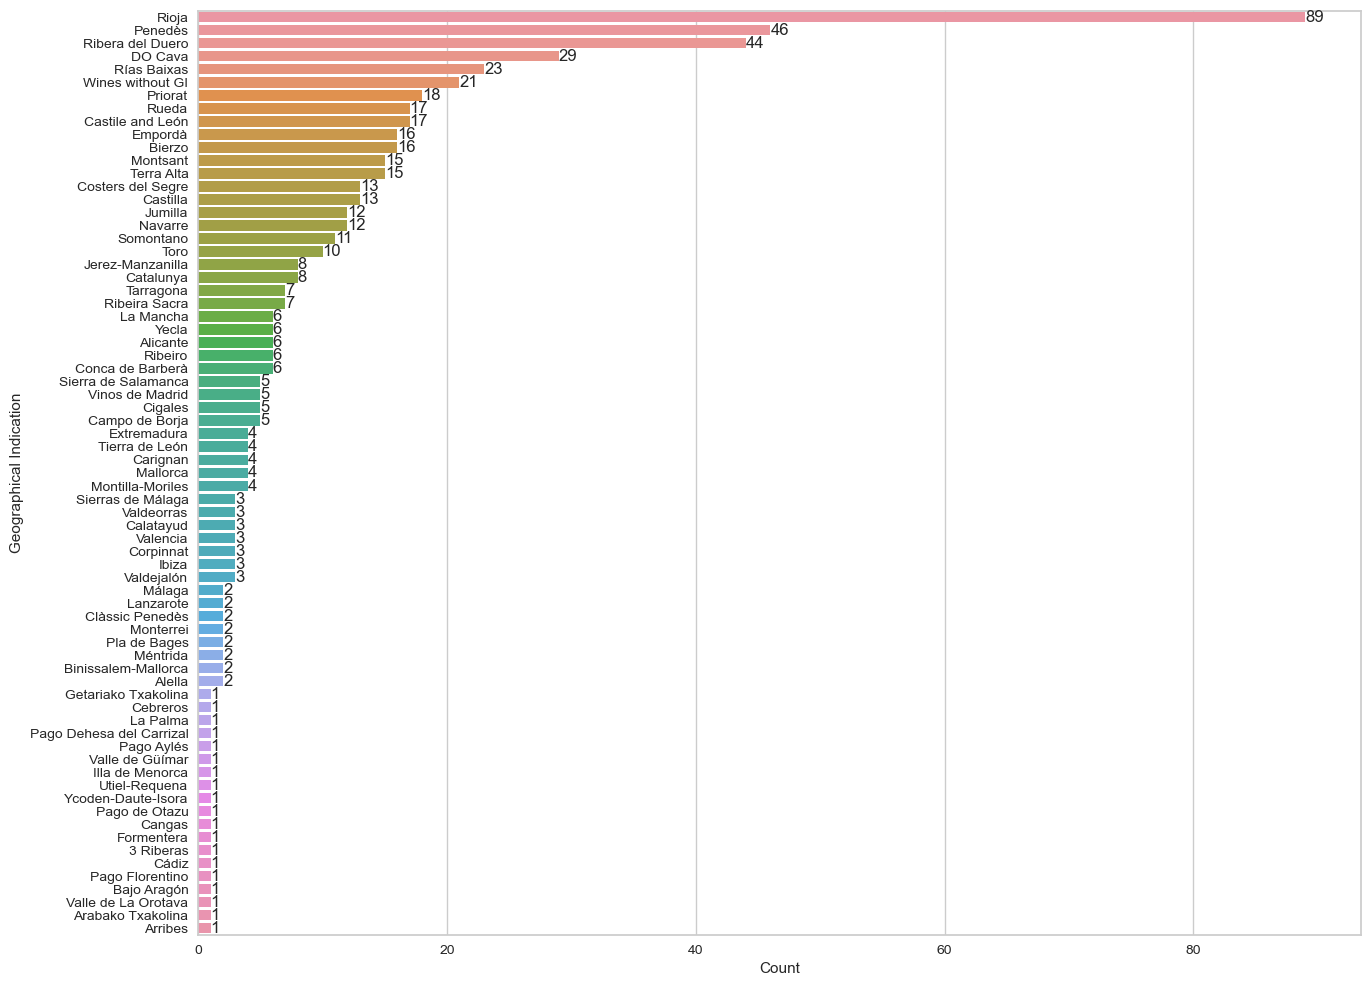

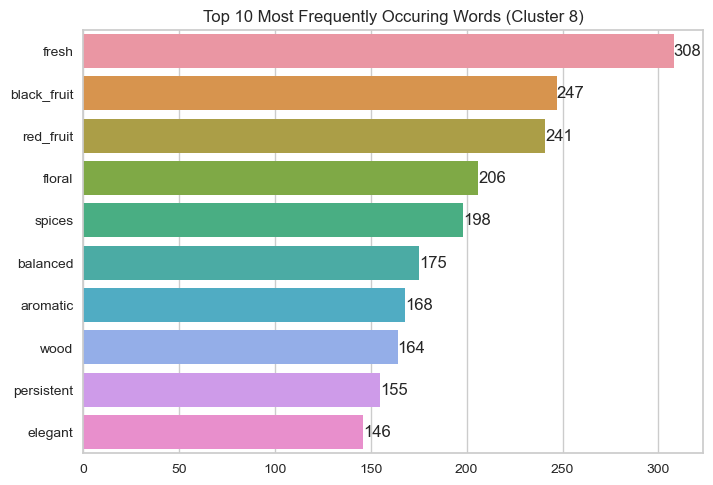

CLUSTER 9
The size of this cluster is 202 wines


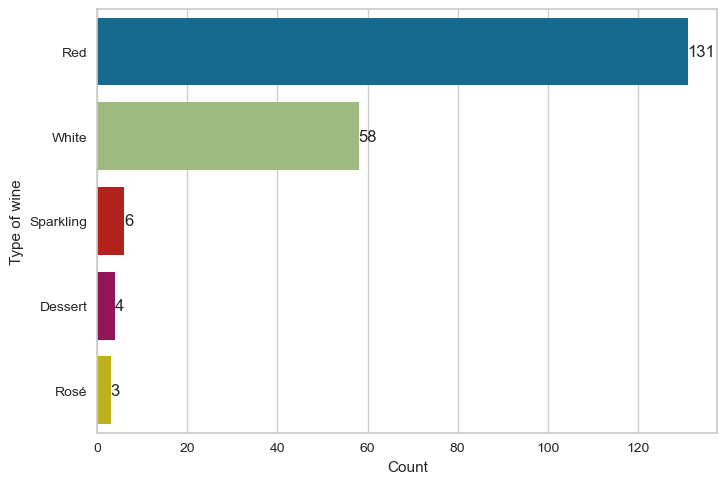

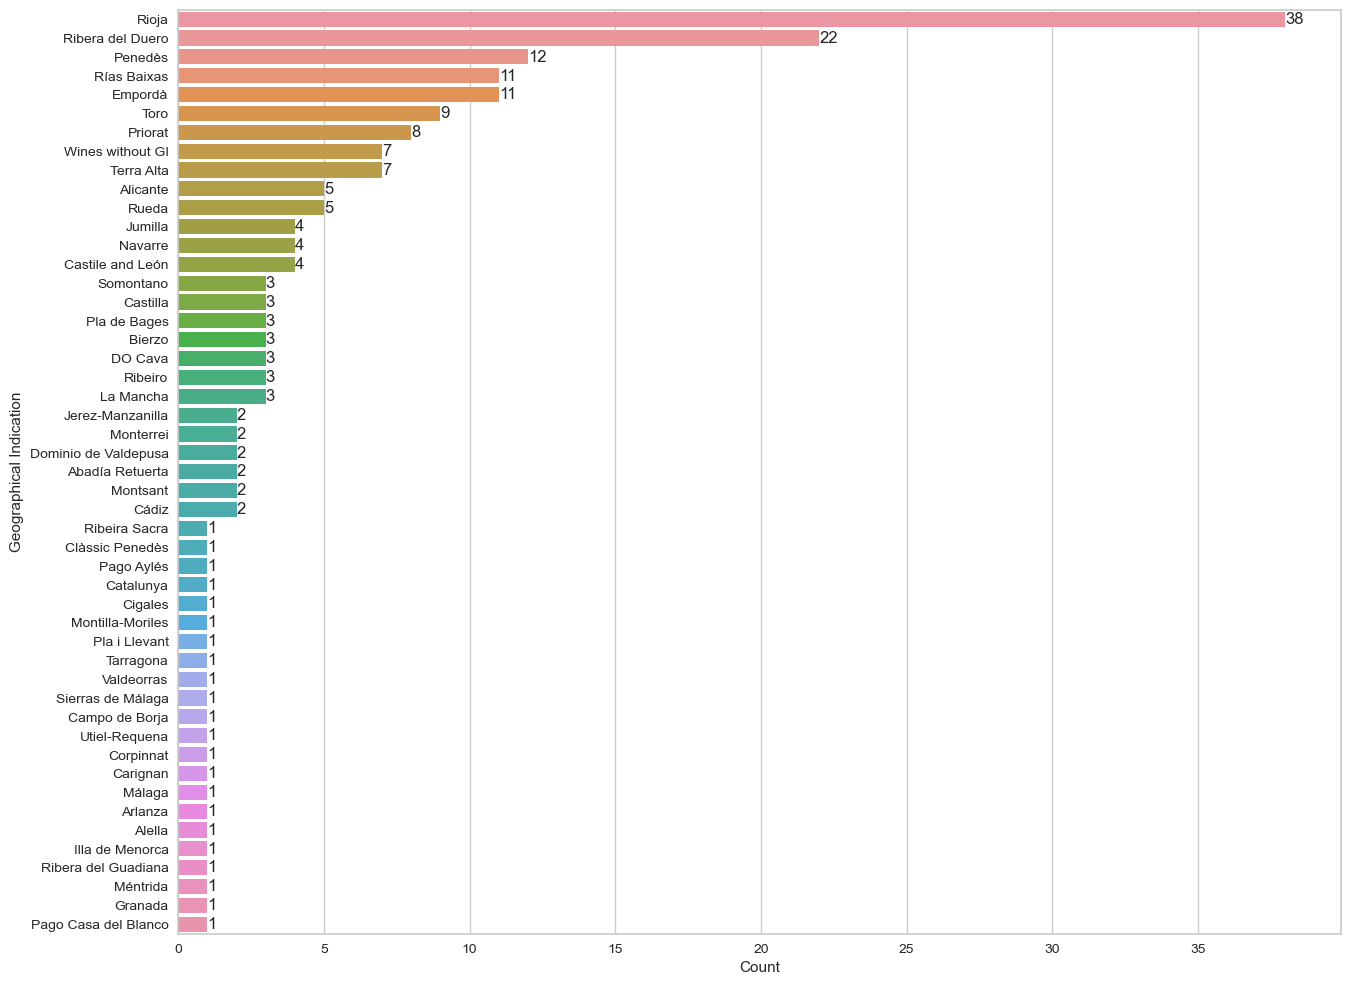

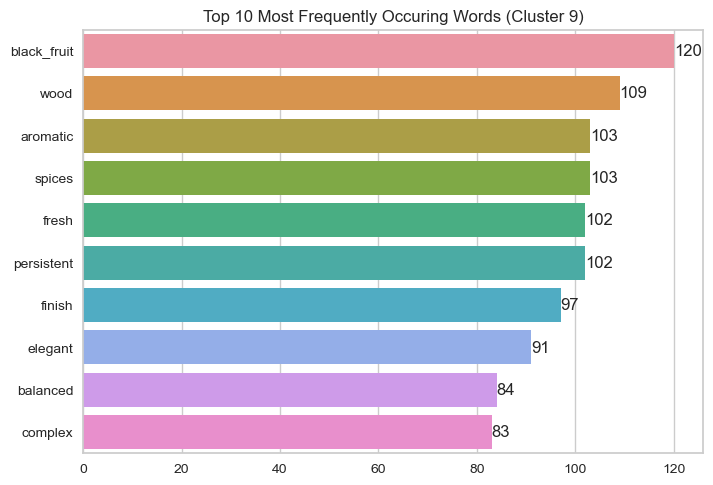

CLUSTER 10
The size of this cluster is 477 wines


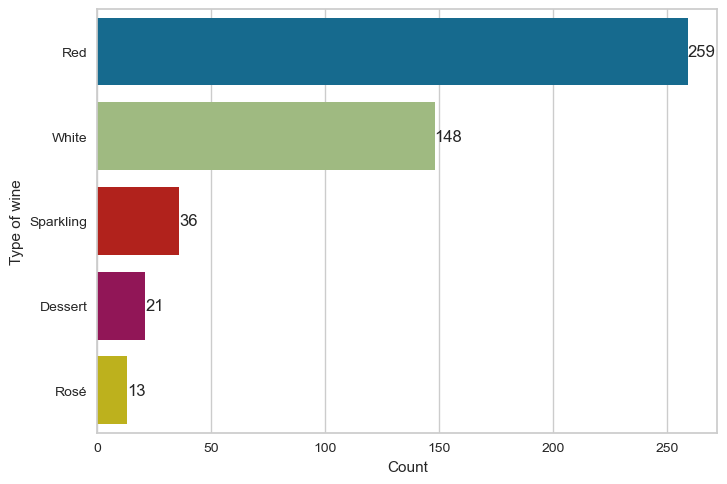

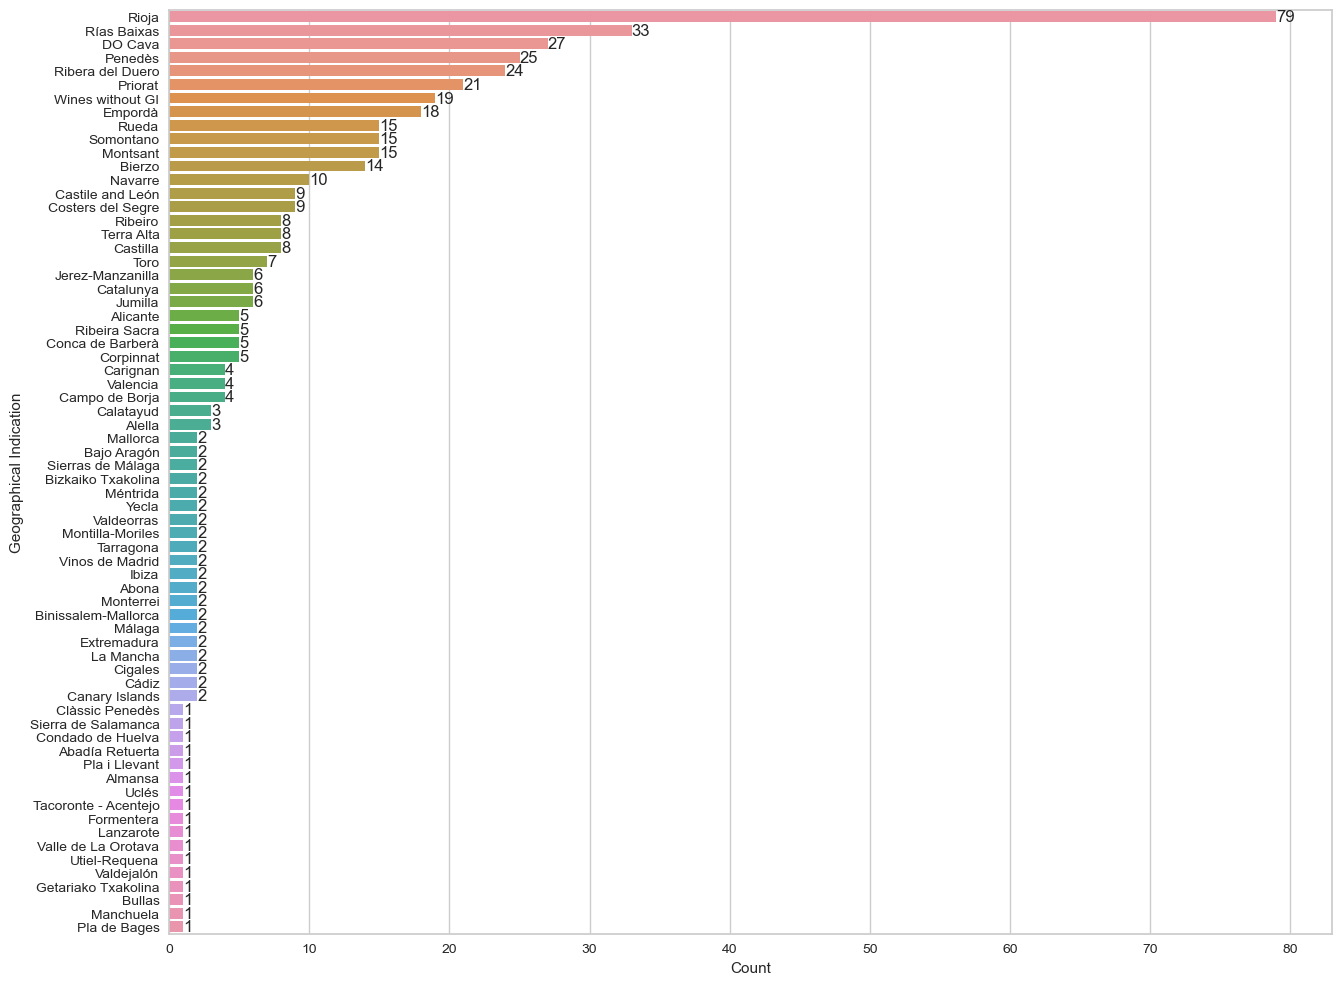

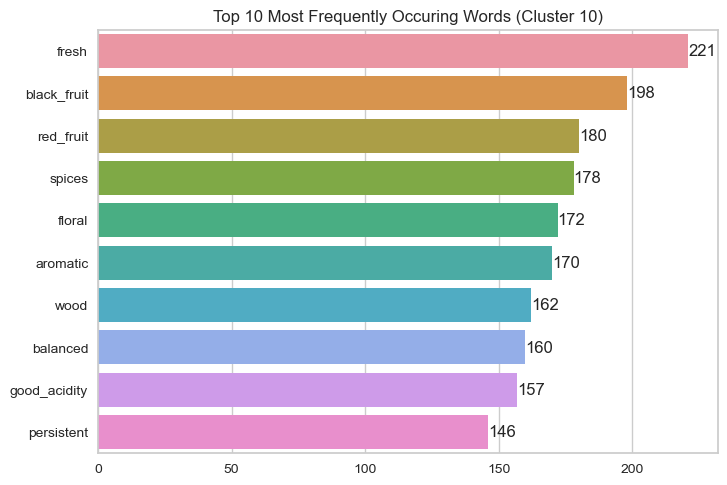

CLUSTER 11
The size of this cluster is 290 wines


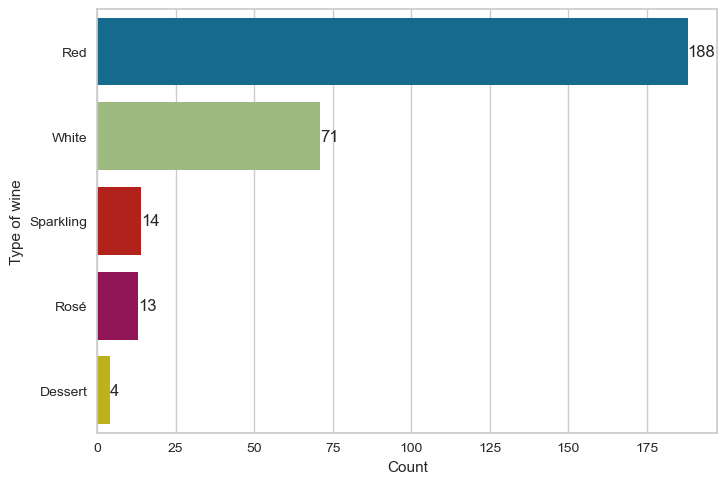

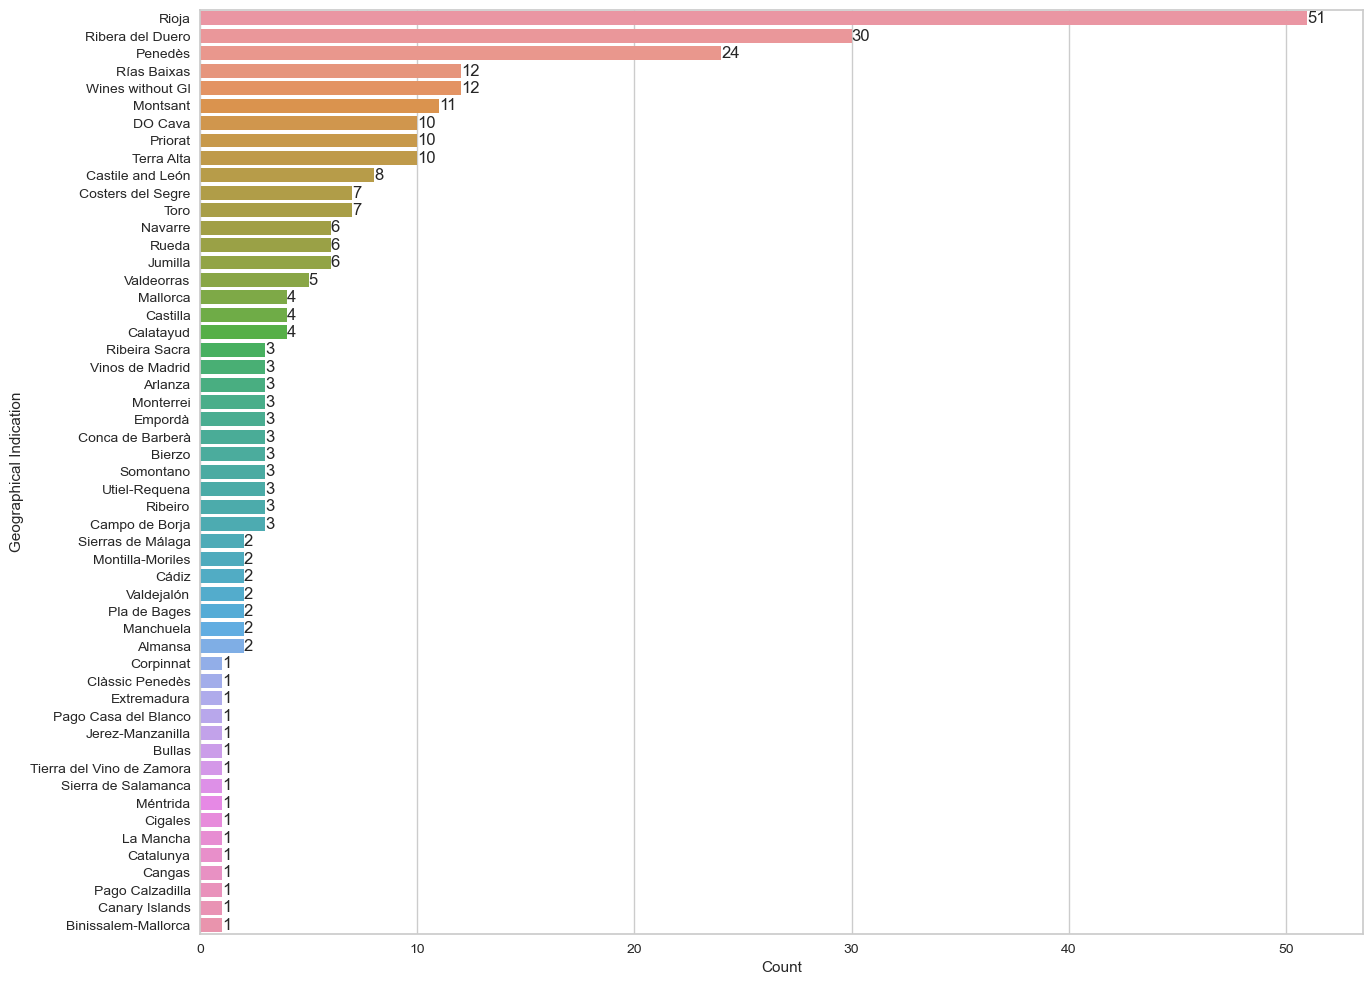

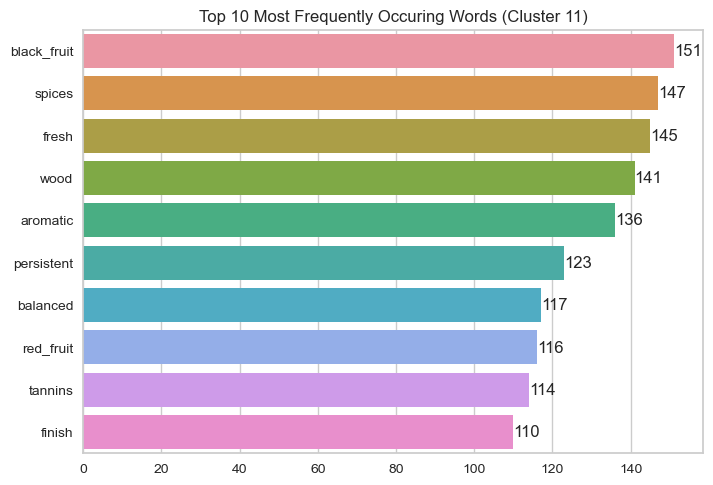

CLUSTER 12
The size of this cluster is 233 wines


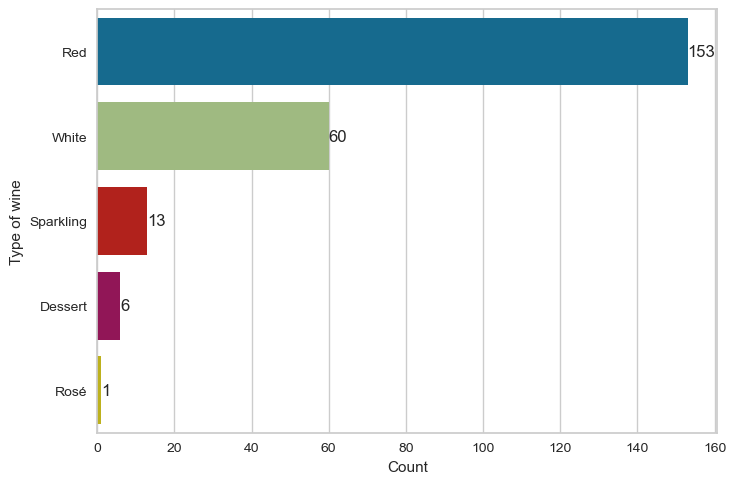

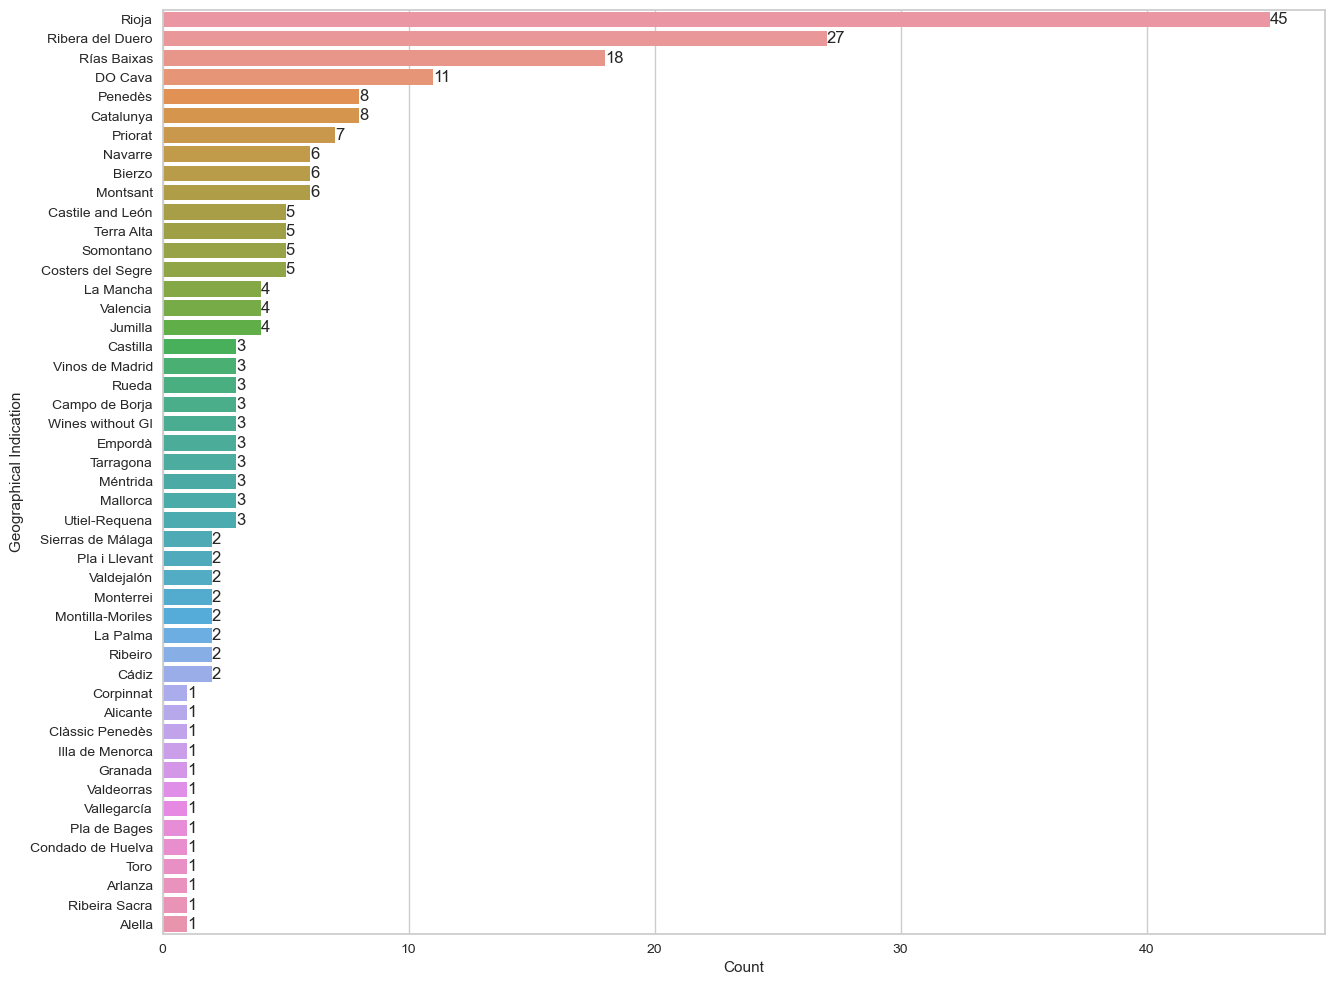

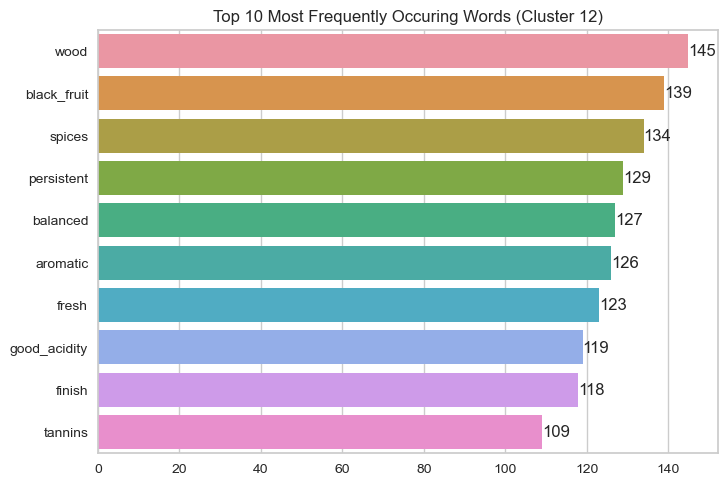

In [132]:
for cluster in range(0,13):
    explore_clusters(text_data, "notes_norm_removed_new_reduction_dropped", "cluster13", cluster)

# Add embeddings to final dataframe

In [133]:
vector = np.array(tfidf_embeddings).tolist()
text_data["embeddings"] = vector

In [134]:
text_data.columns

Index(['wine', 'year', 'winery', 'price', 'bottle', 'type_wine',
       'type_wine_details', 'type_agriculture', 'region', 'region_gi',
       'grapes', 'num_varieties', 'tasting_bouquet', 'tasting_mouth',
       'alcohol_content', 'customer_reviews', 'customer_reviews_number',
       'parker_score', 'parker_score_num', 'penin_score', 'image', 'url',
       'bouquet_norm', 'mouth_norm', 'parker_penin_score', 'tasting_notes',
       'notes_norm', 'bouquet_norm_removed', 'mouth_norm_removed',
       'notes_norm_removed', 'notes_norm_removed_joined',
       'notes_norm_removed_reduced', 'lists', 'notes_norm_removed_reduced50',
       'notes_norm_removed_reduced100', 'notes_norm_removed_reduced150',
       'notes_norm_removed_reduced200', 'notes_norm_removed_reduced250',
       'notes_norm_removed_reduced300', 'notes_norm_removed_new_reduction',
       'notes_norm_removed_new_reduction_dropped', 'tasting_vectors',
       'lists_notes_norm_removed_reduced', 'embeddings', 'column_list',
    

In [137]:
drop_cols = ['tasting_bouquet', 'tasting_mouth',
       'bouquet_norm', 'mouth_norm', 'notes_norm', 'bouquet_norm_removed',
       'mouth_norm_removed', 'notes_norm_removed', 'lists',
       'notes_norm_removed_joined', 'notes_norm_removed_reduced',
       'notes_norm_removed_reduced50', 'notes_norm_removed_reduced100',
       'notes_norm_removed_reduced150', 'notes_norm_removed_reduced200',
       'notes_norm_removed_reduced250', 'notes_norm_removed_reduced300',
       'notes_norm_removed_new_reduction', 'tasting_vectors',
       'lists_notes_norm_removed_reduced', 'column_list']

text_data = text_data.drop(drop_cols, axis=1)

In [138]:
text_data.head()

wine    year                  winery  \
0            Ultreia Saint Jacques 2021  2021.0   Raúl Pérez Viticultor   
1                        Blanc Pescador     NaN                Perelada   
2  Bach Extrísimo Blanco Semidulce 2021  2021.0              Masia Bach   
3            José Pariente Verdejo 2022  2022.0  Bodegas José Pariente    
4             Coto de Imaz Reserva 2018  2018.0        El Coto de Rioja   

   price  bottle  type_wine type_wine_details type_agriculture  \
0   16.2    0.75        Red               Red     Conventional   
1    7.8    0.75  Sparkling   Frizzante white     Conventional   
2    9.4    0.75      White             White     Conventional   
3   16.2    0.75      White             White     Conventional   
4   13.0    0.75        Red               Red     Conventional   

             region         region_gi  ... parker_score_num penin_score  \
0   Castilla y León            Bierzo  ...              NaN         NaN   
1  Wines without GI  Wines without GI  ...              NaN         NaN   
2          Cataluña         Catalunya  ...              NaN         NaN   
3   Castilla y León             Rueda  ...              NaN         NaN   
4          La Rioja             Rioja  ...              NaN         NaN   

                                               image  \
0  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
1  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
2  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
3  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   
4  https://cdn.vinissimus.com/img/unsafe/p500x/pl...   

                                                 url  parker_penin_score  \
0  https://www.vinissimus.com/en/wine/ultreia-sai...                   0   
1  https://www.vinissimus.com/en/wine/blanc-pesca...                   0   
2  https://www.vinissimus.com/en/wine/bach-extris...                   0   
3  https://www.vinissimus.com/en/wine/jose-parien...                   0   
4  https://www.vinissimus.com/en/wine/coto-de-ima...                   0   

                                       tasting_notes  \
0  Red fruit / Mineral / Voluminous / Medium-bodi...   
1  Light / Pleasant / Sparkling / Aromatic / Frui...   
2  Good entry / Structured / Balanced / Good acid...   
3  Rich / Unctuous / Pleasant bitterness / White ...   
4  Fleshy / Powerful / Ripe tannins / Velvety / R...   

            notes_norm_removed_new_reduction_dropped  \
0               red_fruit mineral black_fruit floral   
1                                  pleasant aromatic   
2  structured balanced good_acidity persistent ar...   
3        rich unctuous white_fruit stone_fruit herbs   
4        powerful tannins black_fruit spices complex   

                                          embeddings cluster11 cluster13  
0  [0.019217824563384056, 0.0822993591427803, -0....         1         1  
1  [0.02167670428752899, 0.09844820201396942, -0....         4         2  
2  [0.010562989860773087, 0.05056765303015709, -0...         7         0  
3  [0.018634559586644173, 0.08308868110179901, -0...         5         3  
4  [0.015063327737152576, 0.0716298446059227, -0....         5         3  

[5 rows x 26 columns]

In [139]:
text_data.to_csv("wine_clusters.csv", index=False)

# Conclusion
KMeans with 13 clusters, embeddings250.

In [ ]:
def embeddings(df, column):
    # Embeddings
    df["column_list"] = df[column].str.split()
    notes = df["column_list"]
    w2v_model = Word2Vec(min_count=70,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    w2v_model.build_vocab(notes, progress_per=10000)
    w2v_model.train(notes, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    
    def custom_tokenizer(text):
        return text.split()

    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])

    tfidf_embeddings = []

    for idx in range(len(df)):
        tasting_note = df[column][idx]
        words = tasting_note.split()
        word_vectors = []
        for word in words:
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                word_tfidf_score = tfidf_matrix[idx, tfidf_vectorizer.vocabulary_[word]]
                word_vectors.append(word_vector * word_tfidf_score)
        if word_vectors:
            tfidf_avg_vector = np.mean(word_vectors, axis=0)
        else:
            tfidf_avg_vector = np.zeros(word2vec_model.vector_size)  # Handle cases where no valid word vector is found
        tfidf_embeddings.append(tfidf_avg_vector)
    
    return tfidf_embeddings

In [ ]:
embeddings = embeddings(text_data, "notes_norm_removed_reduced250")

In [ ]:
kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(embeddings)
clusters = kmeans.predict(embeddings)